In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.font_manager
import random 
from matplotlib import rcParams, cm
import scipy.stats as ss
import h5py
import glob
import seaborn as sns
import time
import os
import itertools
import timeit
import networkx as nx
import collections 
import scipy.io
from matplotlib import gridspec 
#For ROI Maps
from scipy.io import loadmat
from skimage import measure
from scipy import ndimage

#For Fitting Baselines
from scipy.optimize import curve_fit

#For Clustering
from sklearn.cluster.bicluster import SpectralBiclustering

/home/hanlabadmins/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.bicluster module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
%matplotlib notebook

In [3]:
%matplotlib inline

In [4]:
#matplotlib.font_manager._rebuild()
#Set matplotlib fonts for figures
rcParams['font.family'] = 'Arial'

# Get Filenames to Load

In [5]:
def makeAliFilenames(mouse_numbers, mouse_days, mouse_sessions):
    #Input lists of mouse numbers, days, and sessions to permute to give out directories and dictionary for filename
    directories = []
    filenames = {}
    for m_num in mouse_numbers:
        for m_day in mouse_days:
            for m_sess in mouse_sessions:
                if ((m_day != 2) | (m_sess != 2)): #Skip d2_s2.  Only do d5_s2
                    mouse_dir = 'ali{}_d{}_s{}/'.format(m_num, m_day, m_sess)
                    directories.append(mouse_dir)
                    if m_day == 2:
                        filenames[mouse_dir] = 'trace_kyleFinalwDoughnut_AllBGs_BinaryVideo.hdf5'
                    else:
                        filenames[mouse_dir] = 'trace_kyleFinalwDoughnut_AllBGs_matched_BinaryVideo.hdf5'
    return directories, filenames

In [6]:
def makeRebeccaFilenames(mouse_numbers, mouse_days, mouse_sessions):
    #Input lists of mouse numbers, days, and sessions to permute to give out directories and dictionary for filename
    directories = []
    filenames = {}
    for m_num in mouse_numbers:
        for m_day in mouse_days:
            for m_sess in mouse_sessions:
                mouse_dir = '{}/{}_d{}_s{}/'.format(m_num, m_num, m_day, m_sess)
                directories.append(mouse_dir)
                filenames[mouse_dir] = 'trace_kyleFinal_BinaryVideo.hdf5'
    return directories, filenames

In [7]:
def combineFilenames(base, dirs, fnDict):
    #Combine Filenames into list for multiple directories with a common base.  fnDict is a dictionary of the filename for each directory
    outFiles = []
    for d in dirs:
        outFiles.append(os.path.join(base+d+fnDict[d]))
    return outFiles

In [8]:
#Initialize Input Values
#Ali Mice

aliBase='/home/hanlabadmins/eng_handata_2/Kyle_Hansen/AliEyeBlink/'
aliMice, aliDays, aliSessions = ([24, 25, 26], [2, 5], [1, 2])
aliFolders, aliFilenames = makeAliFilenames(aliMice, aliDays, aliSessions)
aliFiles = combineFilenames(aliBase, aliFolders, aliFilenames)
#Rebecca Mice
rBase = '/home/hanlabadmins/eng_handata_2/eng_research_handata2/Kyle_Hansen/TonePuff-Rebecca/'

rMice, rDays, rSessions = ([2982,4540], [1,2,9], [1])
rFolders, rFilenames = makeRebeccaFilenames(rMice, rDays, rSessions)
rFiles = combineFilenames(rBase, rFolders, rFilenames)
#New Rebecca Mice
nrBase = '/home/hanlabadmins/eng_handata_2/eng_research_handata2/Kyle_Hansen/TonePuff_Rebecca2/'
nrMice, nrDays, nrSessions = ([2712, 2713,2714,8089], [1, 5], [1]) #Also have 2 as full imaging session.  Drop 2714 because of data quality
nrFolders, nrFilenames = makeRebeccaFilenames(nrMice, nrDays, nrSessions)
nrFiles = combineFilenames(nrBase, nrFolders, nrFilenames)
#Combine All Filenames into one List
allFiles = aliFiles + rFiles + nrFiles
print(allFiles)

['/home/hanlabadmins/eng_handata_2/Kyle_Hansen/AliEyeBlink/ali24_d2_s1/trace_kyleFinalwDoughnut_AllBGs_BinaryVideo.hdf5', '/home/hanlabadmins/eng_handata_2/Kyle_Hansen/AliEyeBlink/ali24_d5_s1/trace_kyleFinalwDoughnut_AllBGs_matched_BinaryVideo.hdf5', '/home/hanlabadmins/eng_handata_2/Kyle_Hansen/AliEyeBlink/ali24_d5_s2/trace_kyleFinalwDoughnut_AllBGs_matched_BinaryVideo.hdf5', '/home/hanlabadmins/eng_handata_2/Kyle_Hansen/AliEyeBlink/ali25_d2_s1/trace_kyleFinalwDoughnut_AllBGs_BinaryVideo.hdf5', '/home/hanlabadmins/eng_handata_2/Kyle_Hansen/AliEyeBlink/ali25_d5_s1/trace_kyleFinalwDoughnut_AllBGs_matched_BinaryVideo.hdf5', '/home/hanlabadmins/eng_handata_2/Kyle_Hansen/AliEyeBlink/ali25_d5_s2/trace_kyleFinalwDoughnut_AllBGs_matched_BinaryVideo.hdf5', '/home/hanlabadmins/eng_handata_2/Kyle_Hansen/AliEyeBlink/ali26_d2_s1/trace_kyleFinalwDoughnut_AllBGs_BinaryVideo.hdf5', '/home/hanlabadmins/eng_handata_2/Kyle_Hansen/AliEyeBlink/ali26_d5_s1/trace_kyleFinalwDoughnut_AllBGs_matched_BinaryVide

# Load Behavior Data

In [9]:
def loadFiles(allFiles, fieldName, whichData=None, multiIndex=False, fixedSize=None):
    #Get File Inputs
    firstf = allFiles[0]
    firstdir = firstf.split('/')[-2]
    f = h5py.File(firstf, 'r')
    if multiIndex: #Adjust indexing for first DataFrame if using a multi-index
        first_array = np.array(f[fieldName]).T
        index_iterables = [[firstdir], range(first_array.shape[1])]
        index = pd.MultiIndex.from_product(index_iterables, names=['mouse','cell_num'])
        df = pd.DataFrame(data=first_array, columns=index)
    else:
        if fixedSize == None:
            df = pd.DataFrame(data=np.array(f[fieldName]).T, columns=[firstdir])
        else:
            df = pd.DataFrame(data=np.array(f[fieldName]).T[:(fixedSize)], columns=[firstdir])
    
    df.index.name='Time'
    df_size = df.shape[0] #Determine Size of DataFrame
    for f in allFiles[1:]: #Loop through remaining files and add to DataFrame
        fdir = f.split('/')[-2] #Current Filename/Dir
        f = h5py.File(f, 'r')
        if multiIndex: #Iteratively add multiIndexed DataFrames
            data_arr = np.array(f[fieldName]).T
            index_iterables = [[fdir], range(data_arr.shape[1])]
            index = pd.MultiIndex.from_product(index_iterables, names=['mouse', 'cell_num'])
            df = df.join(pd.DataFrame(data=data_arr, columns=index))
        else:
            #print(f)
            #print(df.shape)
            #print(df_size)
            #print(np.array(f[fieldName]).T.shape)
            try: #Standard Loading
                df.loc[:,fdir] = np.array(f[fieldName]).T 
            except ValueError: #Exception cases where behavior was different size from other behavior sessions
                if (whichData == 'Ali'): #Ali26_d5_s2 and Ali25_d5_s2 are one frame short
                    df.loc[:,fdir] = np.insert(np.array(f[fieldName]).T, 0, np.array(f[fieldName]).T.mean())
                elif np.array(f[fieldName]).T.shape[0]<df_size:
                    temp = np.array(f[fieldName]).T
                    df.loc[:,fdir] = np.append(temp, temp.mean().reshape(1,-1), axis=0)
                elif (whichData == 'Rebecca'): #2982_d9_s1 is one frame longer
                    new_size = np.array(f[fieldName]).shape[1]
                    diff_size = abs(new_size-df_size)
                    df.loc[:,fdir] = np.array(f[fieldName]).T[:-diff_size]
    drop_index = df.index[df.isna().any(axis='columns')]
    df = df.drop(drop_index)
    return df

In [10]:
aliSounds = loadFiles(aliFiles, 'binSounds', whichData='Ali')
rSounds = loadFiles(rFiles, 'binSounds', whichData='Rebecca')
nrSounds = loadFiles(nrFiles, 'binSounds', whichData='Rebecca', fixedSize=39500)
sound_traces = pd.concat([aliSounds,rSounds,nrSounds], axis=1)

In [11]:
aliPuffs = loadFiles(aliFiles, 'binPuffs', whichData='Ali')
rPuffs = loadFiles(rFiles, 'binPuffs', whichData='Rebecca')
nrPuffs = loadFiles(nrFiles, 'binPuffs', whichData='Rebecca', fixedSize=39500)
puff_traces = pd.concat([aliPuffs,rPuffs,nrPuffs], axis=1)

In [12]:
aliTrials = loadFiles(aliFiles, 'binTrials', whichData='Ali')
rTrials = loadFiles(rFiles, 'binTrials', whichData='Rebecca')
nrTrials = loadFiles(nrFiles, 'binTrials', whichData='Rebecca', fixedSize=39500)
trial_traces = pd.concat([aliTrials,rTrials,nrTrials], axis=1)

In [13]:
aliEyeTraces = loadFiles(aliFiles, 'eyeTrace', whichData='Ali')
rEyeTraces = loadFiles(rFiles, 'eyeTrace', whichData='Rebecca')
nrEyeTraces = loadFiles(nrFiles, 'eyeTrace', whichData='Rebecca', fixedSize=39500)
eye_traces = pd.concat([aliEyeTraces,rEyeTraces,nrEyeTraces], axis=1)

In [14]:
eye_traces.head()

ali24_d2_s1  ali24_d5_s1  ali24_d5_s2  ali25_d2_s1  ali25_d5_s1  \
Time                                                                    
0          6459.0       9298.0       6433.0      10225.0      10499.0   
1          6437.0       9328.0       6539.0      10219.0      10460.0   
2          6430.0       9456.0       6723.0      10227.0      10430.0   
3          6420.0       9429.0       7753.0      10214.0      10482.0   
4          6413.0       9406.0       7087.0      10155.0      10449.0   

       ali25_d5_s2  ali26_d2_s1  ali26_d5_s1  ali26_d5_s2  2982_d1_s1  ...  \
Time                                                                   ...   
0     12470.742967      10384.0       9155.0  7481.449722      2706.0  ...   
1      9504.000000      10482.0       9181.0  8748.000000      2721.0  ...   
2      9461.000000      10523.0       9226.0  8710.000000      2813.0  ...   
3      9481.000000      10497.0       9195.0  8723.000000      2810.0  ...   
4      9424.000000      10442.0       9192.0  8754.000000      2816.0  ...   

      4540_d2_s1  4540_d9_s1  2712_d1_s1     2712_d5_s1  2713_d1_s1  \
Time                                                                  
0         3190.0      2750.0      1957.0  188893.200000      2800.0   
1         3227.0      2748.0      1976.0  192173.337255      2810.0   
2         3338.0      2753.0      2176.0  207815.039216      2811.0   
3         3369.0      2511.0      2246.0  209527.972549      2815.0   
4         3423.0      2594.0      2281.0  208186.466667      2741.0   

         2713_d5_s1  2714_d1_s1     2714_d5_s1  8089_d1_s1     8089_d5_s1  
Time                                                                       
0     399372.690196      1516.0  148764.901961      2633.0  245200.858824  
1     401255.066667      1603.0  143647.258824      2646.0  246733.380392  
2     402823.686275      1634.0  146470.937255      2686.0  248666.960784  
3     402039.380392      1652.0  146294.494118      2657.0  248269.674510  
4     386196.274510      1677.0  157413.388235      2655.0  247469.784314  

[5 rows x 23 columns]

In [15]:
sound_traces.head()

ali24_d2_s1  ali24_d5_s1  ali24_d5_s2  ali25_d2_s1  ali25_d5_s1  \
Time                                                                    
0             0.0          0.0          0.0          0.0          0.0   
1             0.0          0.0          0.0          0.0          0.0   
2             0.0          0.0          0.0          0.0          0.0   
3             0.0          0.0          0.0          0.0          0.0   
4             0.0          0.0          0.0          0.0          0.0   

      ali25_d5_s2  ali26_d2_s1  ali26_d5_s1  ali26_d5_s2  2982_d1_s1  ...  \
Time                                                                  ...   
0        0.010573          0.0          0.0          0.0         0.0  ...   
1        0.000000          0.0          0.0          0.0         0.0  ...   
2        0.000000          0.0          0.0          0.0         0.0  ...   
3        0.000000          0.0          0.0          0.0         0.0  ...   
4        0.000000          0.0          0.0          0.0         0.0  ...   

      4540_d2_s1  4540_d9_s1  2712_d1_s1  2712_d5_s1  2713_d1_s1  2713_d5_s1  \
Time                                                                           
0            0.0         0.0         0.0         0.0         0.0         0.0   
1            0.0         0.0         0.0         0.0         0.0         0.0   
2            0.0         0.0         0.0         0.0         0.0         0.0   
3            0.0         0.0         0.0         0.0         0.0         0.0   
4            0.0         0.0         0.0         0.0         0.0         0.0   

      2714_d1_s1  2714_d5_s1  8089_d1_s1  8089_d5_s1  
Time                                                  
0            0.0         0.0         0.0         0.0  
1            0.0         0.0         0.0         0.0  
2            0.0         0.0         0.0         0.0  
3            0.0         0.0         0.0         0.0  
4            0.0         0.0         0.0         0.0  

[5 rows x 23 columns]

# Remove Moving Average and Pull out Trial Blocks

In [16]:
def findPulses(inputTrace):
    #Find location of onset and offset of pulses
    #inputTrace = 1-D Numpy Array Trace of values assumed to be similar to a train of ttl pulses, where there is a clear onset and offset for each pulse.
    #locationTrace = Pseudo-logical 1-D trace, with 1s at pulse onset, and -1s at pulse offset, and 0s everywhere else
    
    shiftedInput = inputTrace - inputTrace.mean() #Shift to have mean 0 and baseline below 0
    changes = np.sign(shiftedInput) #Find where sign changes
    locationTrace = np.zeros(inputTrace.shape); #Initialize Output
    diffArray = np.diff(changes)
    locationTrace[np.insert(diffArray==2,0,0)] = 1 #Set onsets to 1
    locationTrace[np.insert(diffArray==-2,0,0)] = -1 #Set offsets to -1
    return locationTrace

In [17]:
def makeBehavTrialBlocks(trace_df, behav_df):
    #Make Blocks of Trials for plain index behavior, and return df with those trial blocks removed
    #Pre-defined Values
    tot_block_time = 201 #201 timepoints is about 10 seconds
    before_sound_time = 40 #40 timepoints before the puff 2 seconds
    after_sound_time = tot_block_time - before_sound_time - 1 #Time after sound.  Subtract 1 as index between before sound and after sound is included as "spot"
    #Shorten behav_df to length of trace_df
    behav_length = behav_df.shape[0]
    trace_length = trace_df.shape[0]
    if behav_length > trace_length:
        behav_df = behav_df.loc[:(trace_length-1),:]
    #Make Trial Blocks for Each Mouse
    trace_blocks=[]
    trace_noBlocks_df = trace_df.copy()
    for mouse in trace_df:
        soundPulses = findPulses(behav_df.loc[:,mouse])
        sound_on_inds = behav_df.index[soundPulses == 1]
        if sound_on_inds[-1]+after_sound_time > trace_df.loc[:,mouse].shape[0]: #Get rid of last pulse on at end of recording
            sound_on_inds = sound_on_inds[:-1]
        cur_block = np.zeros((sound_on_inds.shape[0], tot_block_time))
        for idx, spot in enumerate(sound_on_inds):
            cur_block[idx,:] = trace_df.loc[(spot-before_sound_time):(spot+after_sound_time),mouse].values
            trace_noBlocks_df.loc[:, mouse] = trace_noBlocks_df.loc[:, mouse].drop(range((spot-before_sound_time), (spot+after_sound_time)))
        trace_blocks.append(cur_block)
    return np.stack(trace_blocks), trace_noBlocks_df.dropna().reset_index(drop=True)

In [18]:
# Make above a function 
def notrialblocks_last40_trials(trace_df,behav_df):
    norm_df = (trace_df - trace_df.mean(axis=0)) / trace_df.mean(axis=0)
    windSize=20
    wind_df = norm_df.subtract(norm_df.rolling(windSize).mean())

    trace_df=wind_df
    tot_block_time = 201 #201 timepoints is about 10 seconds
    before_sound_time = 40 #40 timepoints before the puff 2 seconds
    after_sound_time = tot_block_time - before_sound_time - 1 #Time after sound.  Subtract 1 as index between before sound and after sound is included as "spot"
    #Shorten behav_df to length of trace_df
    behav_length = behav_df.shape[0]
    trace_length = trace_df.shape[0]
    if behav_length > trace_length:
        behav_df = behav_df.loc[:(trace_length-1),:]
    #Make Trial Blocks for Each Mouse
    trace_blocks=[]
    trace_noBlocks_df = trace_df.copy()
    soundPulses = findPulses(behav_df)
    sound_on_inds = behav_df.index[soundPulses == 1]
    if sound_on_inds[-1]+after_sound_time > trace_df.shape[0]: #Get rid of last pulse on at end of recording
        sound_on_inds = sound_on_inds[:-1]
    sound_on_inds = sound_on_inds[20:60]
    start =sound_on_inds[0]-before_sound_time
    short_df = trace_df[start:]
    trace_noBlocks_df = short_df.copy()
    for idx, spot in enumerate(sound_on_inds):
        trace_noBlocks_df= trace_noBlocks_df.drop(range((spot-before_sound_time), (spot+after_sound_time)))
    trace_noBlocks_df=trace_noBlocks_df.dropna().reset_index(drop=True)

    return trace_noBlocks_df

In [19]:
# Make above a function 
def notrialblocks_last20_trials(trace_df,behav_df):
    norm_df = (trace_df - trace_df.mean(axis=0)) / trace_df.mean(axis=0)
    windSize=20
    wind_df = norm_df.subtract(norm_df.rolling(windSize).mean())

    trace_df=wind_df
    tot_block_time = 201 #201 timepoints is about 10 seconds
    before_sound_time = 40 #40 timepoints before the puff 2 seconds
    after_sound_time = tot_block_time - before_sound_time - 1 #Time after sound.  Subtract 1 as index between before sound and after sound is included as "spot"
    #Shorten behav_df to length of trace_df
    behav_length = behav_df.shape[0]
    trace_length = trace_df.shape[0]
    if behav_length > trace_length:
        behav_df = behav_df.loc[:(trace_length-1),:]
    #Make Trial Blocks for Each Mouse
    trace_blocks=[]
    trace_noBlocks_df = trace_df.copy()
    soundPulses = findPulses(behav_df)
    sound_on_inds = behav_df.index[soundPulses == 1]
    if sound_on_inds[-1]+after_sound_time > trace_df.shape[0]: #Get rid of last pulse on at end of recording
        sound_on_inds = sound_on_inds[:-1]
    sound_on_inds = sound_on_inds[20:40]
    start =sound_on_inds[0]-before_sound_time
    short_df = trace_df[start:]
    trace_noBlocks_df = short_df.copy()
    for idx, spot in enumerate(sound_on_inds):
        trace_noBlocks_df= trace_noBlocks_df.drop(range((spot-before_sound_time), (spot+after_sound_time)))
    trace_noBlocks_df=trace_noBlocks_df.dropna().reset_index(drop=True)

    return trace_noBlocks_df

In [20]:
def norm_MA_block(trace_df, windSize, sounds):
    #Normalize traces, take moving window of windSize, and make trial blocks
    norm_df = (trace_df - trace_df.mean(axis=0)) / trace_df.mean(axis=0)
    wind_df = norm_df.subtract(norm_df.rolling(windSize).mean())
    blocks, allButBlocks = makeBehavTrialBlocks(wind_df, sounds)
    return blocks, allButBlocks

In [21]:
aliEyeBlocks, aliAllButEyeBlocks = norm_MA_block(aliEyeTraces, 20, aliSounds)
rEyeBlocks, rAllButEyeBlocks = norm_MA_block(rEyeTraces, 20, rSounds)
nrEyeBlocks, nrAllButEyeBlocks = norm_MA_block(nrEyeTraces, 20, nrSounds)

In [22]:
rAllButEyeBlocks['2982_d9_s1']

0        0.016267
1        0.010279
2        0.006075
3       -0.001641
4       -0.058275
           ...   
27270    0.020586
27271    0.016901
27272    0.013215
27273    0.009559
27274    0.007918
Name: 2982_d9_s1, Length: 27275, dtype: float64

# Determine Behavior Eyeblink Thresholds

In [23]:
def linear_func(x, a, b):
    return a*x + b

In [24]:
def curve_fit_wrapper(y, x, func):
    #Wrap curve_fit to match Pandas DataFrame Use and return only parameters, not covariance
    return curve_fit(func, x, y)[0]

In [25]:
def generate_line_wrapper(params, x, func):
    #Apply Funcion in a way that works with Pandas DataFrame
    return func(x, *params)

In [26]:
def pick_thresh_idx_wrapper(bool_arr):
    return bool_arr.index[bool_arr == True][-1]

In [27]:
def calcThresholds(trace_df, drop_thresh, pct_fit, make_plots):
    #Calculate thresholds for each trace by removing linearized value
    #Sort each trace
    sorted_traces = trace_df.apply(np.sort, axis=0)
    #Calculate indexes for use
    Ntot = sorted_traces.shape[0]
    Nhalf = np.floor(Ntot/2).astype(int)
    Nfit = np.floor(Ntot * pct_fit).astype(int)
    fit_start = np.floor((Ntot-Nfit)/2).astype(int)
    fit_end = Ntot-fit_start
    #Generate X Data and Fit Line
    x_tot = np.arange(0, Ntot)
    fitted_params = sorted_traces.loc[fit_start:fit_end,:].apply(curve_fit_wrapper, args=(x_tot[fit_start:(fit_end+1)], linear_func)) #Add 1 to fit end because of np/pd differences in indexing
    fit_lines = fitted_params.apply(generate_line_wrapper, args=(x_tot, linear_func))
    #Adjust traces by fit line and determine thresholds
    shift_traces = sorted_traces.subtract(fit_lines)
    half_thresh = (shift_traces < drop_thresh).loc[:Nhalf,:]
    thresh_idxs = half_thresh.apply(pick_thresh_idx_wrapper)
    pick_thresh = []
    for idx, col in zip(thresh_idxs, thresh_idxs.index):
        pick_thresh.append(sorted_traces.loc[idx, col])
    if make_plots: #Make Plots of Interest
        #Fixed Plot Parameters
        maxWidth = 3.
        #Dynamic Parameters
        Nplots = sorted_traces.shape[1]
        layoutR, layoutC = [np.ceil(Nplots/maxWidth).astype(int), int(min(Nplots, maxWidth))]
        all_ax = sorted_traces.plot(subplots=True, figsize=(9,layoutR*5), layout=(layoutR, layoutC), legend=False)
        step=0
        for ax_row in all_ax:
            for sel_ax in ax_row:
                fit_lines.iloc[:,step].plot(ax=sel_ax, legend=True, linestyle='--', color='k')
                step+=1
    return pd.DataFrame(data=np.array(pick_thresh).reshape(1,-1), columns=thresh_idxs.index.tolist())

In [28]:
aliEyeThresholds = calcThresholds(aliAllButEyeBlocks, -0.02, 0.95, 0)
aliEyeThresholds

ali24_d2_s1  ali24_d5_s1  ali24_d5_s2  ali25_d2_s1  ali25_d5_s1  \
0    -0.056923    -0.083445    -0.049021    -0.094611    -0.106464   

   ali25_d5_s2  ali26_d2_s1  ali26_d5_s1  ali26_d5_s2  
0    -0.044256    -0.054119    -0.046476    -0.060289

In [29]:
rEyeThresholds = calcThresholds(rAllButEyeBlocks, -0.02, 0.95, 0)
rEyeThresholds

2982_d1_s1  2982_d2_s1  2982_d9_s1  4540_d1_s1  4540_d2_s1  4540_d9_s1
0   -0.128594   -0.207848    -0.07293   -0.096246   -0.085931   -0.117443

In [30]:
nrEyeThresholds = calcThresholds(nrAllButEyeBlocks, -0.02, 0.95, 0)
nrEyeThresholds

2712_d1_s1  2712_d5_s1  2713_d1_s1  2713_d5_s1  2714_d1_s1  2714_d5_s1  \
0   -0.127987    -0.09615   -0.094401   -0.106988   -0.131883   -0.115779   

   8089_d1_s1  8089_d5_s1  
0    -0.12457   -0.082427

# Use Thresholds to Generate Trial Behavior Scoring

In [31]:
def binaryBehaviorScoring(blocks, thresholds, make_plots):
    #Take blocks (trial by trial blocks as np.array) and use thresholds (pandas df) to determine values
    #Fixed Parameters
    start=40
    end=52
    #Thresholding
    blockMins = blocks[:,:,start:end].min(axis=2)
    binScoring = pd.DataFrame(columns=thresholds.columns)
    for idx, mouse in enumerate(thresholds):
        binScoring.loc[:,mouse] = blockMins[idx,:] < thresholds.loc[0,mouse]
    if make_plots:
        #Fixed Plot Parameters
        maxWidth = 2.
        endView = 60
        cmax = .1
        cmin = -.1
        #Dynamic Parameters
        Nplots = thresholds.shape[1]
        layoutR, layoutC = [np.ceil(Nplots/maxWidth).astype(int), int(min(Nplots, maxWidth))]
        fig, all_ax = plt.subplots(figsize=(9, layoutR*4), nrows=layoutR, ncols=layoutC)
        fig.tight_layout()
        try: #Reshape if only one row of axes indexes
            all_ax.shape[1]
        except:
            all_ax = all_ax.reshape(1,-1)
        step=0
        for ax_row in all_ax:
            for sel_ax in ax_row:
                if step == Nplots:
                    sel_ax.set_axis_off()
                else:
                    sns.heatmap(blocks[step,:,:endView], ax=sel_ax, vmin=cmin, vmax=cmax, cmap=plt.get_cmap("bwr"))
                    sel_ax.axvline(x=start, linestyle='-.', color='k')
                    sel_ax.axvline(x=end, linestyle='--', color='k')
                    sel_ax.set_title(thresholds.columns[step])
                    step+=1
    return binScoring

## Finding spontaneous blink rate  

In [32]:
def spont_blink_rate(block_df,threshold):
    b = np.zeros(block_df.shape[0]-9)
    for i in range(block_df.shape[0]-10):
        a = block_df.loc[i:i+11]
        minimum = a.min(axis=0)
        b[i]=minimum < threshold
    c = np.argwhere(b==True).shape[0]
    rate = c/int(block_df.shape[0]-9)*100
    return rate 

### First session 

In [33]:
ali24_spont_rate_FS=spont_blink_rate(aliAllButEyeBlocks['ali24_d2_s1'],aliEyeThresholds['ali24_d2_s1'])
ali25_spont_rate_FS=spont_blink_rate(aliAllButEyeBlocks['ali25_d2_s1'],aliEyeThresholds['ali25_d2_s1'])
ali26_spont_rate_FS=spont_blink_rate(aliAllButEyeBlocks['ali26_d2_s1'],aliEyeThresholds['ali26_d2_s1'])
print(ali24_spont_rate_FS,ali25_spont_rate_FS,ali26_spont_rate_FS)

10.150869137422106 11.850880069968296 9.637039466491744


In [34]:
spont_2712_rate_FS=spont_blink_rate(nrAllButEyeBlocks['2712_d1_s1'],nrEyeThresholds['2712_d1_s1'])
spont_2713_rate_FS=spont_blink_rate(nrAllButEyeBlocks['2713_d1_s1'],nrEyeThresholds['2713_d1_s1'])
spont_2714_rate_FS=spont_blink_rate(nrAllButEyeBlocks['2714_d1_s1'],nrEyeThresholds['2714_d1_s1'])
spont_8089_rate_FS=spont_blink_rate(nrAllButEyeBlocks['8089_d1_s1'],nrEyeThresholds['8089_d1_s1'])
print(spont_2712_rate_FS,spont_2713_rate_FS,spont_2714_rate_FS, spont_8089_rate_FS)

20.19279924048784 15.53713576279851 29.05134010078142 29.872927773314835


In [35]:
spont_2982_rate_FS=spont_blink_rate(rAllButEyeBlocks['2982_d1_s1'],rEyeThresholds['2982_d1_s1'])
spont_4540_rate_FS=spont_blink_rate(rAllButEyeBlocks['4540_d1_s1'],rEyeThresholds['4540_d1_s1'])
print(spont_2982_rate_FS,spont_4540_rate_FS)

27.97990170908824 22.196141714956354


In [36]:
spont_blink_rate_FS = [ali24_spont_rate_FS,ali25_spont_rate_FS,ali26_spont_rate_FS,spont_2982_rate_FS,spont_4540_rate_FS,spont_2712_rate_FS,spont_2713_rate_FS,spont_2714_rate_FS,spont_8089_rate_FS]
#print(np.mean(blink_rate_FS),np.std(blink_rate_FS))
df = {'Blink rate first session' : pd.Series(spont_blink_rate_FS, index=['ali24', 'ali25', 'ali26','2982','4540','2712','2713','2714','8089'])}
spont_blink_rate_FS_df= pd.DataFrame(df)
print(spont_blink_rate_FS_df.mean(),spont_blink_rate_FS_df.std())
spont_blink_rate_FS_df

Blink rate first session    19.607671
dtype: float64 Blink rate first session    8.195096
dtype: float64


Blink rate first session
ali24                 10.150869
ali25                 11.850880
ali26                  9.637039
2982                  27.979902
4540                  22.196142
2712                  20.192799
2713                  15.537136
2714                  29.051340
8089                  29.872928

In [37]:
spont_blink_rate_FS_df.describe()

Blink rate first session
count                  9.000000
mean                  19.607671
std                    8.195096
min                    9.637039
25%                   11.850880
50%                   20.192799
75%                   27.979902
max                   29.872928

### Last training session 

In [38]:
ali24_spont_rate_LS=spont_blink_rate(aliAllButEyeBlocks['ali24_d5_s1'],aliEyeThresholds['ali24_d5_s1'])
ali25_spont_rate_LS=spont_blink_rate(aliAllButEyeBlocks['ali25_d5_s1'],aliEyeThresholds['ali25_d5_s1'])
ali26_spont_rate_LS=spont_blink_rate(aliAllButEyeBlocks['ali26_d5_s1'],aliEyeThresholds['ali26_d5_s1'])
print(ali24_spont_rate_LS,ali25_spont_rate_LS,ali26_spont_rate_LS)

12.878539411829015 14.682409533180277 7.8113042527604675


In [39]:
spont_2982_rate_LS=spont_blink_rate(rAllButEyeBlocks['2982_d9_s1'],rEyeThresholds['2982_d9_s1'])
spont_4540_rate_LS=spont_blink_rate(rAllButEyeBlocks['4540_d9_s1'],rEyeThresholds['4540_d9_s1'])
print(spont_2982_rate_LS,spont_4540_rate_LS)

27.97623413775398 24.29399251815448


In [40]:
spont_2712_rate_LS=spont_blink_rate(nrAllButEyeBlocks['2712_d5_s1'],nrEyeThresholds['2712_d5_s1'])
spont_2713_rate_LS=spont_blink_rate(nrAllButEyeBlocks['2713_d5_s1'],nrEyeThresholds['2713_d5_s1'])
spont_2714_rate_LS=spont_blink_rate(nrAllButEyeBlocks['2714_d5_s1'],nrEyeThresholds['2714_d5_s1'])
spont_8089_rate_LS=spont_blink_rate(nrAllButEyeBlocks['8089_d5_s1'],nrEyeThresholds['8089_d5_s1'])
print(spont_2712_rate_LS,spont_2713_rate_LS,spont_2714_rate_LS, spont_8089_rate_LS)

18.421821368582485 30.238077849996348 25.308551814795884 28.65332651719857


In [41]:
spont_blink_rate_LS = [ali24_spont_rate_LS,ali25_spont_rate_LS,ali26_spont_rate_LS,spont_2982_rate_LS,spont_4540_rate_LS,spont_2712_rate_LS,spont_2713_rate_LS,spont_2714_rate_LS,spont_8089_rate_LS]
df = {'Blink rate Last session' : pd.Series(spont_blink_rate_LS, index=['ali24', 'ali25', 'ali26','2982','4540','2712','2713','2714','8089'])}
spont_blink_rate_LS_df= pd.DataFrame(df)
print(spont_blink_rate_LS_df.mean(),spont_blink_rate_LS_df.std())
spont_blink_rate_LS_df

Blink rate Last session    21.140473
dtype: float64 Blink rate Last session    7.970873
dtype: float64


Blink rate Last session
ali24                12.878539
ali25                14.682410
ali26                 7.811304
2982                 27.976234
4540                 24.293993
2712                 18.421821
2713                 30.238078
2714                 25.308552
8089                 28.653327

In [42]:
df = {'First session' : pd.Series(spont_blink_rate_FS, index=['ali24', 'ali25', 'ali26','2982','4540','2712','2713','2714','8089']),
     'Last session': pd.Series(spont_blink_rate_LS,index=['ali24','ali25','ali26','2982','4540','2712','2713','2714','8089'])}
blink_rate_LS_FS_df= pd.DataFrame(df)
blink_rate_LS_FS_df

First session  Last session
ali24      10.150869     12.878539
ali25      11.850880     14.682410
ali26       9.637039      7.811304
2982       27.979902     27.976234
4540       22.196142     24.293993
2712       20.192799     18.421821
2713       15.537136     30.238078
2714       29.051340     25.308552
8089       29.872928     28.653327

In [43]:
def makePairedScatterPlot_modified_colors(df, f_size, clrs, ax=None, ax_pos = [0.2, 0.1, 0.75, 0.8], plotlines=False):
    #Make paired scatter plots with lines between paired points.  Plot Points for each column in DataFrame
    #Font Details
    label_size=7
    tick_size=6
   
    Ncols = df.shape[0]
    #Make Figure
    if ax == None:
        fig = plt.figure(figsize=f_size)
        ax = fig.add_axes(ax_pos)
    else:
        ax.set_position(ax_pos)
    #Loop through each column
    x_iter = 0
    last_c = None
    C= ['yellow','darkgreen','lime','sienna','aqua','slategrey','black','darkmagenta','darkblue']
    for idx, c in enumerate(df):
        avg = df[c].mean()
        ax.bar([x_iter, x_iter], [avg, avg], color=clrs[idx], zorder=0)
        ax.scatter(np.ones((Ncols,1))*x_iter, df[c], color=C, zorder=2)
        u_err, l_err = [df[c].std(), df[c].std()] # [df[c].quantile(q=0.975), df[c].quantile(q=0.025)]
        err_array = np.array([l_err, u_err]).reshape(2,-1)
        ax.errorbar(x_iter, avg, yerr=err_array, color=clrs[idx], zorder=1)
        if plotlines:
            if last_c is not None:
                x_1 = np.ones((Ncols,1))*(x_iter-1)
                x_2 = np.ones((Ncols,1))*x_iter
                y_1 = df[last_c]
                y_2 =  df[c]
                for x1, x2, y1, y2 in zip(x_1, x_2, y_1, y_2):
                    ax.plot([x1,x2], [y1,y2], '--', color=[0,0,0,0.75])
        x_iter += 1
        last_c = c
    #Final Plot Formatting
    ax.grid(b=False)
    ax.set_xticks(np.arange(0,x_iter))
   
    ax.set_xticklabels(df.columns, fontsize=label_size) 
    ax.set_facecolor([1,1,1])
    
    #ax.tick_params(labelsize=tick_size)
    #ax.set_ylim([0, 1])
    #ax.set_yticklabels(np.arange(0,101,20).round(1),fontsize=tick_size)
    ax.set_ylabel('Spontaneous blink percent')
    return ax

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


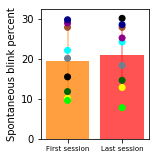

In [44]:
makePairedScatterPlot_modified_colors(blink_rate_LS_FS_df,(2,2.25),clrs = [[1,0.5,0,0.5], [1,.1,.1,0.5]])
plt.savefig('spont_blink_FS_LS.png',format='png',dpi=1200)
#plt.savefig('spont_blink_FS_LS.eps',format='eps')

## Behavior scoring trial-wise

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


(array([ 2,  5,  7, 10, 11, 12, 14, 17, 22, 26, 27, 29, 31, 35, 37]),) (array([ 0,  1,  3,  4,  6,  8,  9, 13, 15, 16, 18, 19, 20, 21, 23, 24, 25,
       28, 30, 32, 33, 34, 36, 38, 39]),) (array([ 8, 12, 14, 17, 22, 25, 28, 30, 32, 33, 34, 36, 39]),) (array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 13, 15, 16, 18, 19, 20,
       21, 23, 24, 26, 27, 29, 31, 35, 37, 38]),)


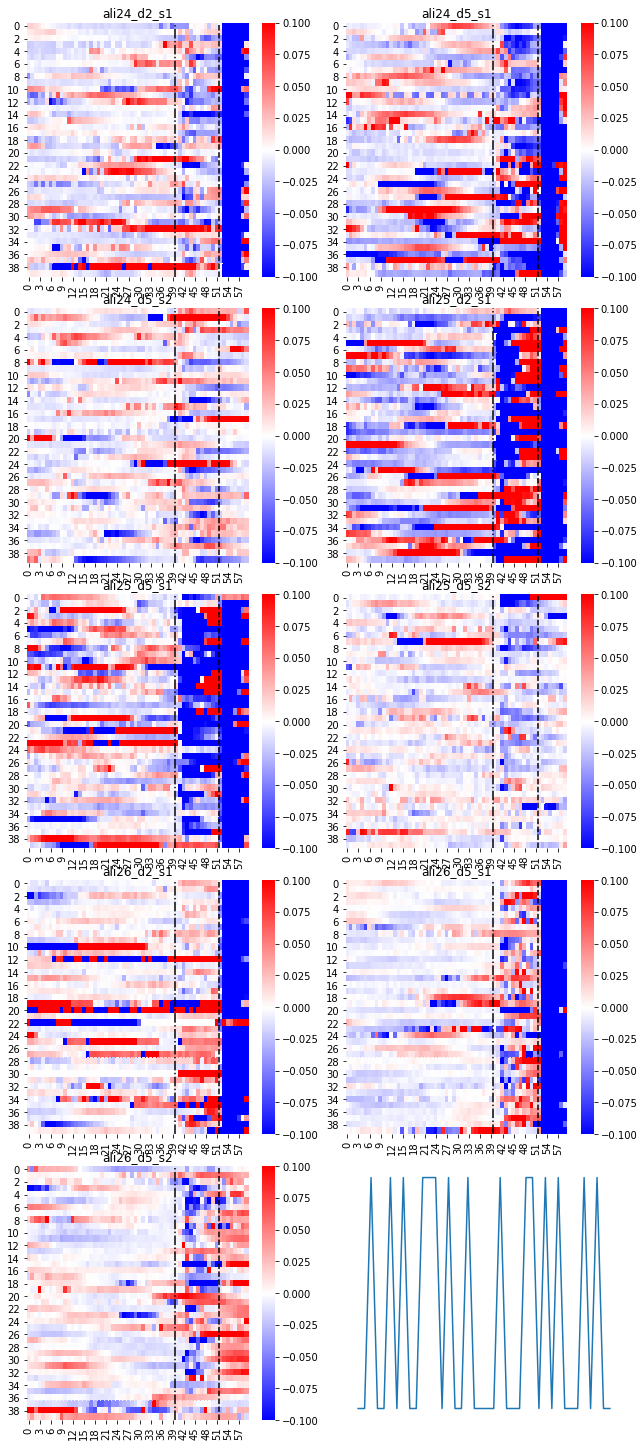

In [45]:
aliBehaviorScoring = binaryBehaviorScoring(aliEyeBlocks, aliEyeThresholds, 1)
aliBehaviorScoring.sum()/40
#CS 
a = aliBehaviorScoring['ali24_d2_s1']
plt.plot(a)
blink_trials_CS = np.where(a==True)
no_blink_trials_CS = np.where(a==False)
# EX
b = aliBehaviorScoring['ali24_d5_s2']
blink_trials_EX = np.where(b==True)
no_blink_trials_EX = np.where(b==False)
print(blink_trials_CS,no_blink_trials_CS,blink_trials_EX,no_blink_trials_EX)

In [46]:
print('ali24 d2 Puff first20 trials: {}'.format(aliBehaviorScoring.loc[:19,'ali24_d2_s1'].sum()/20.))
print('ali24 d2 Puff first20 trials: {}'.format(aliBehaviorScoring.loc[20:,'ali24_d2_s1'].sum()/20.))
print('ali 24 d5 Puff: {}'.format(aliBehaviorScoring.loc[:19,'ali24_d5_s1'].sum()/20.))
print('ali 24 d5 Puff: {}'.format(aliBehaviorScoring.loc[20:,'ali24_d5_s1'].sum()/20.))


print('ali25 d2 Puff first20 trials: {}'.format(aliBehaviorScoring.loc[:19,'ali25_d2_s1'].sum()/20.))
print('ali25 d2 Puff first20 trials: {}'.format(aliBehaviorScoring.loc[20:,'ali25_d2_s1'].sum()/20.))
print('ali25 d5 Puff: {}'.format(aliBehaviorScoring.loc[:19,'ali25_d5_s1'].sum()/20.))
print('ali25 d5 Puff: {}'.format(aliBehaviorScoring.loc[20:,'ali25_d5_s1'].sum()/20.))


print('ali26 d2 Puff first20 trials: {}'.format(aliBehaviorScoring.loc[:19,'ali26_d2_s1'].sum()/20.))
print('ali26 d2 Puff first20 trials: {}'.format(aliBehaviorScoring.loc[20:,'ali26_d2_s1'].sum()/20.))
print('ali26 d5 Puff: {}'.format(aliBehaviorScoring.loc[:19,'ali26_d5_s1'].sum()/20.))
print('ali26 d5 Puff: {}'.format(aliBehaviorScoring.loc[20:,'ali26_d5_s1'].sum()/20.))

ali24 d2 Puff first20 trials: 0.4
ali24 d2 Puff first20 trials: 0.35
ali 24 d5 Puff: 0.4
ali 24 d5 Puff: 0.65
ali25 d2 Puff first20 trials: 0.95
ali25 d2 Puff first20 trials: 0.8
ali25 d5 Puff: 0.9
ali25 d5 Puff: 0.7
ali26 d2 Puff first20 trials: 0.1
ali26 d2 Puff first20 trials: 0.3
ali26 d5 Puff: 0.55
ali26 d5 Puff: 0.7


2982 d1 No Puff: 0.45
2982 d1 Puff: 0.4
2982 d1 Puff 20 trials: 0.5
2982 d1 Puff second 20 trials: 0.3
2982 d9 Puff: 0.65
2982 d9 No Puff: 0.825
4540 d1 No Puff: 0.25
4540 d1 Puff: 0.425
4540 d1 Puff 20 trials: 0.5
4540 d1 Puff second 20 trials: 0.35
4540 d9 Puff: 0.85
4540 d9 No Puff: 0.275


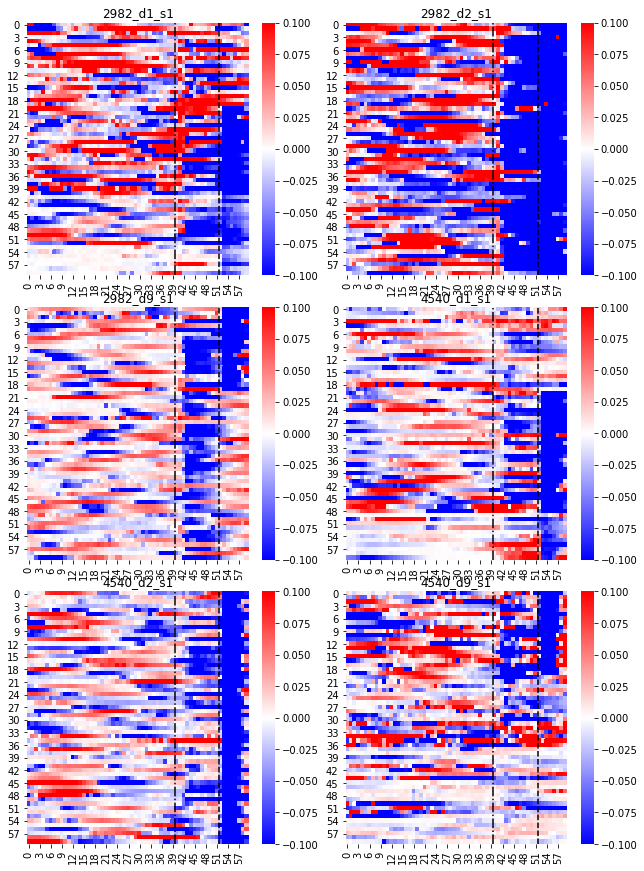

In [47]:
rBehaviorScoring = binaryBehaviorScoring(rEyeBlocks, rEyeThresholds, 1)
print('2982 d1 No Puff: {}'.format(rBehaviorScoring.loc[:19,'2982_d1_s1'].sum()/20.))
print('2982 d1 Puff: {}'.format(rBehaviorScoring.loc[20:,'2982_d1_s1'].sum()/40.))
print('2982 d1 Puff 20 trials: {}'.format(rBehaviorScoring.loc[20:39,'2982_d1_s1'].sum()/20.))
print('2982 d1 Puff second 20 trials: {}'.format(rBehaviorScoring.loc[40:,'2982_d1_s1'].sum()/20.))
print('2982 d9 Puff: {}'.format(rBehaviorScoring.loc[:19,'2982_d9_s1'].sum()/20.))
print('2982 d9 No Puff: {}'.format(rBehaviorScoring.loc[20:,'2982_d9_s1'].sum()/40.))


print('4540 d1 No Puff: {}'.format(rBehaviorScoring.loc[:19,'4540_d1_s1'].sum()/20.))
print('4540 d1 Puff: {}'.format(rBehaviorScoring.loc[20:,'4540_d1_s1'].sum()/40.))
print('4540 d1 Puff 20 trials: {}'.format(rBehaviorScoring.loc[20:39,'4540_d1_s1'].sum()/20.))
print('4540 d1 Puff second 20 trials: {}'.format(rBehaviorScoring.loc[40:,'4540_d1_s1'].sum()/20.))
print('4540 d9 Puff: {}'.format(rBehaviorScoring.loc[:19,'4540_d9_s1'].sum()/20.))
print('4540 d9 No Puff: {}'.format(rBehaviorScoring.loc[20:,'4540_d9_s1'].sum()/40.))

2712 d1 No Puff: 0.15
2712 d1 Puff: 0.8
2712 d1 Puff 20 trials: 0.75
2712 d1 Puff second 20 trials: 0.85
2712 d5 Puff: 0.55
2712 d5 No Puff: 0.6
2713 d1 No Puff: 0.3
2713 d1 Puff: 0.725
2713 d1 20 trials Puff: 0.7
2713 d1 second 20 trials Puff: 0.75
2713 d5 Puff: 0.9
2713 d5 No Puff: 0.675
2714 d1 No Puff: 0.45
2714 d1 Puff: 0.525
2714 d1 20 trials Puff: 0.5
2714 d1 second 20 trials Puff: 0.55
2714 d5 Puff: 0.55
2714 d5 No Puff: 0.7
8089 d1 No Puff: 0.15
8089 d1 Puff: 0.7
8089 d1 20 trials Puff: 0.65
8089 d1 second 20 trials Puff: 0.75
8089 d5 Puff: 0.65
8089 d5 No Puff: 0.5


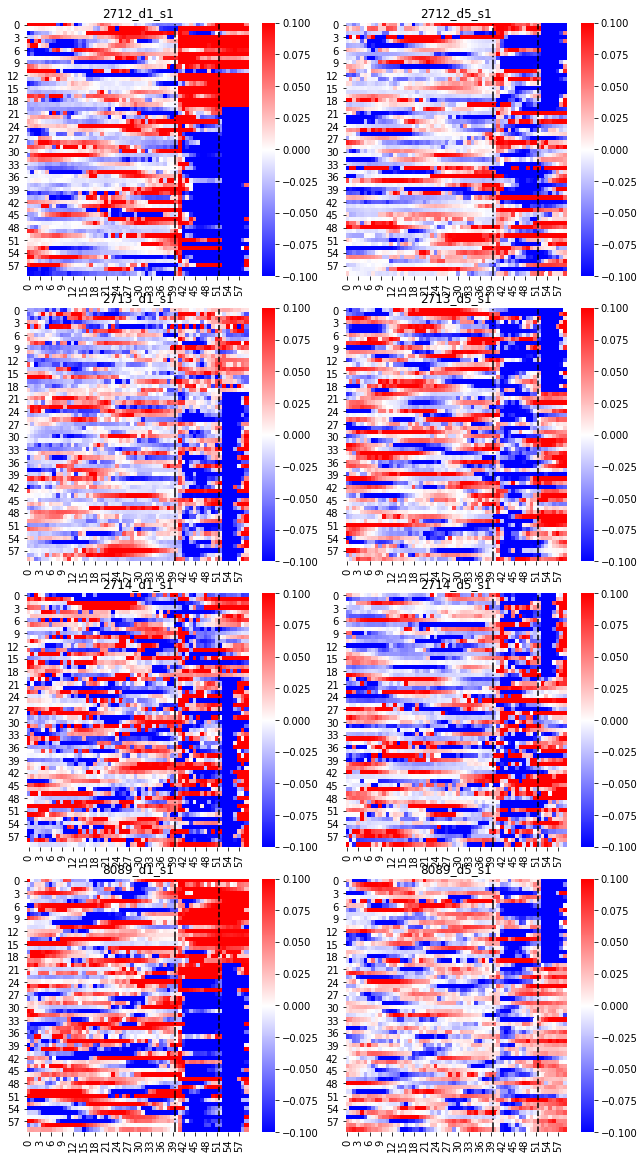

In [48]:
nrBehaviorScoring = binaryBehaviorScoring(nrEyeBlocks, nrEyeThresholds, 1)
print('2712 d1 No Puff: {}'.format(nrBehaviorScoring.loc[:19,'2712_d1_s1'].sum()/20.))
print('2712 d1 Puff: {}'.format(nrBehaviorScoring.loc[20:,'2712_d1_s1'].sum()/40.))
print('2712 d1 Puff 20 trials: {}'.format(nrBehaviorScoring.loc[20:39,'2712_d1_s1'].sum()/20.))
print('2712 d1 Puff second 20 trials: {}'.format(nrBehaviorScoring.loc[40:,'2712_d1_s1'].sum()/20.))
print('2712 d5 Puff: {}'.format(nrBehaviorScoring.loc[:19,'2712_d5_s1'].sum()/20.))
print('2712 d5 No Puff: {}'.format(nrBehaviorScoring.loc[20:,'2712_d5_s1'].sum()/40.))

print('2713 d1 No Puff: {}'.format(nrBehaviorScoring.loc[:19,'2713_d1_s1'].sum()/20.))
print('2713 d1 Puff: {}'.format(nrBehaviorScoring.loc[20:,'2713_d1_s1'].sum()/40.))
print('2713 d1 20 trials Puff: {}'.format(nrBehaviorScoring.loc[20:39,'2713_d1_s1'].sum()/20.))
print('2713 d1 second 20 trials Puff: {}'.format(nrBehaviorScoring.loc[40:,'2713_d1_s1'].sum()/20.))
print('2713 d5 Puff: {}'.format(nrBehaviorScoring.loc[:19,'2713_d5_s1'].sum()/20.))
print('2713 d5 No Puff: {}'.format(nrBehaviorScoring.loc[20:,'2713_d5_s1'].sum()/40.))

print('2714 d1 No Puff: {}'.format(nrBehaviorScoring.loc[:19,'2714_d1_s1'].sum()/20.))
print('2714 d1 Puff: {}'.format(nrBehaviorScoring.loc[20:,'2714_d1_s1'].sum()/40.))
print('2714 d1 20 trials Puff: {}'.format(nrBehaviorScoring.loc[20:39,'2714_d1_s1'].sum()/20.))
print('2714 d1 second 20 trials Puff: {}'.format(nrBehaviorScoring.loc[40:,'2714_d1_s1'].sum()/20.))
print('2714 d5 Puff: {}'.format(nrBehaviorScoring.loc[:19,'2714_d5_s1'].sum()/20.))
print('2714 d5 No Puff: {}'.format(nrBehaviorScoring.loc[20:,'2714_d5_s1'].sum()/40.))

print('8089 d1 No Puff: {}'.format(nrBehaviorScoring.loc[:19,'8089_d1_s1'].sum()/20.))
print('8089 d1 Puff: {}'.format(nrBehaviorScoring.loc[20:,'8089_d1_s1'].sum()/40.))
print('8089 d1 20 trials Puff: {}'.format(nrBehaviorScoring.loc[20:39,'8089_d1_s1'].sum()/20.))
print('8089 d1 second 20 trials Puff: {}'.format(nrBehaviorScoring.loc[40:,'8089_d1_s1'].sum()/20.))
print('8089 d5 Puff: {}'.format(nrBehaviorScoring.loc[:19,'8089_d5_s1'].sum()/20.))
print('8089 d5 No Puff: {}'.format(nrBehaviorScoring.loc[20:,'8089_d5_s1'].sum()/40.))

In [49]:
print('2714 d5 Puff: {}'.format(nrBehaviorScoring.loc[:19,'2714_d5_s1'].sum()/20.))
print('2714 d5 No Puff: {}'.format(nrBehaviorScoring.loc[20:,'2714_d5_s1'].sum()/40.))
print('2982 d5 Puff: {}'.format(rBehaviorScoring.loc[:19,'2982_d9_s1'].sum()/20.))
print('2982 d5 No Puff: {}'.format(rBehaviorScoring.loc[20:,'2982_d9_s1'].sum()/40.))
print('4540 d5 Puff: {}'.format(rBehaviorScoring.loc[:19,'4540_d9_s1'].sum()/20.))
print('4540 d5 No Puff: {}'.format(rBehaviorScoring.loc[20:,'4540_d9_s1'].sum()/40.))


2714 d5 Puff: 0.55
2714 d5 No Puff: 0.7
2982 d5 Puff: 0.65
2982 d5 No Puff: 0.825
4540 d5 Puff: 0.85
4540 d5 No Puff: 0.275


In [50]:
print('2712 d5 No Puff: {}'.format(nrBehaviorScoring.loc[20:39,'2712_d5_s1'].sum()/20.))
print('2713 d5 No Puff: {}'.format(nrBehaviorScoring.loc[20:39,'2713_d5_s1'].sum()/20.))
print('2714 d5 No Puff: {}'.format(nrBehaviorScoring.loc[20:39,'2714_d5_s1'].sum()/20.))
print('8089 d5 No Puff: {}'.format(nrBehaviorScoring.loc[20:39,'8089_d5_s1'].sum()/20.))
print('2982 d5 No Puff: {}'.format(rBehaviorScoring.loc[20:39,'2982_d9_s1'].sum()/20.))
print('4540 d5 No Puff: {}'.format(rBehaviorScoring.loc[20:39,'4540_d9_s1'].sum()/20.))


2712 d5 No Puff: 0.7
2713 d5 No Puff: 0.7
2714 d5 No Puff: 0.7
8089 d5 No Puff: 0.6
2982 d5 No Puff: 0.9
4540 d5 No Puff: 0.5


In [51]:
print('2712 d5 No Puff: {}'.format(nrBehaviorScoring.loc[40:59,'2712_d5_s1'].sum()/20.))
print('2713 d5 No Puff: {}'.format(nrBehaviorScoring.loc[40:59,'2713_d5_s1'].sum()/20.))
print('2714 d5 No Puff: {}'.format(nrBehaviorScoring.loc[40:59,'2714_d5_s1'].sum()/20.))
print('8089 d5 No Puff: {}'.format(nrBehaviorScoring.loc[40:59,'8089_d5_s1'].sum()/20.))
print('2982 d5 No Puff: {}'.format(rBehaviorScoring.loc[40:59,'2982_d9_s1'].sum()/20.))
print('4540 d5 No Puff: {}'.format(rBehaviorScoring.loc[40:59,'4540_d9_s1'].sum()/20.))


2712 d5 No Puff: 0.5
2713 d5 No Puff: 0.65
2714 d5 No Puff: 0.7
8089 d5 No Puff: 0.4
2982 d5 No Puff: 0.75
4540 d5 No Puff: 0.05


In [52]:
print('Ali 24 d5 No Puff: {}'.format(aliBehaviorScoring.loc[0:19,'ali24_d5_s2'].sum()/20))
print('Ali 25 d5 No Puff: {}'.format(aliBehaviorScoring.loc[0:19,'ali25_d5_s2'].sum()/20))
print('Ali 26 d5 No Puff: {}'.format(aliBehaviorScoring.loc[0:19,'ali26_d5_s2'].sum()/20))

Ali 24 d5 No Puff: 0.2
Ali 25 d5 No Puff: 0.55
Ali 26 d5 No Puff: 0.55


In [53]:
print('Ali 24 d5 No Puff: {}'.format(aliBehaviorScoring.loc[20:39,'ali24_d5_s2'].sum()/20))
print('Ali 25 d5 No Puff: {}'.format(aliBehaviorScoring.loc[20:39,'ali25_d5_s2'].sum()/20))
print('Ali 26 d5 No Puff: {}'.format(aliBehaviorScoring.loc[20:39,'ali26_d5_s2'].sum()/20))

Ali 24 d5 No Puff: 0.45
Ali 25 d5 No Puff: 0.4
Ali 26 d5 No Puff: 0.4


In [54]:
aliBehaviorScoring.loc[20:24,'ali24_d5_s1'].sum()/5*100

60.0

### Extinction trials behavior with sliding window 

In [55]:
aliBehaviorScoring.loc[22:26,'ali24_d5_s2'].sum()/5*100

40.0

In [56]:
# taken from https://stackoverflow.com/questions/6822725/rolling-or-sliding-window-iterator
def GetShiftingWindows(thelist, size):
    return [ thelist[x:x+size] for x in range( len(thelist) - size + 1 ) ]

In [57]:
a = np.arange(0,40,1)
sliding_window_idx=GetShiftingWindows(a, 5)
sliding_window_idx[0]

array([0, 1, 2, 3, 4])

In [58]:
sliding_window_idx

[array([0, 1, 2, 3, 4]),
 array([1, 2, 3, 4, 5]),
 array([2, 3, 4, 5, 6]),
 array([3, 4, 5, 6, 7]),
 array([4, 5, 6, 7, 8]),
 array([5, 6, 7, 8, 9]),
 array([ 6,  7,  8,  9, 10]),
 array([ 7,  8,  9, 10, 11]),
 array([ 8,  9, 10, 11, 12]),
 array([ 9, 10, 11, 12, 13]),
 array([10, 11, 12, 13, 14]),
 array([11, 12, 13, 14, 15]),
 array([12, 13, 14, 15, 16]),
 array([13, 14, 15, 16, 17]),
 array([14, 15, 16, 17, 18]),
 array([15, 16, 17, 18, 19]),
 array([16, 17, 18, 19, 20]),
 array([17, 18, 19, 20, 21]),
 array([18, 19, 20, 21, 22]),
 array([19, 20, 21, 22, 23]),
 array([20, 21, 22, 23, 24]),
 array([21, 22, 23, 24, 25]),
 array([22, 23, 24, 25, 26]),
 array([23, 24, 25, 26, 27]),
 array([24, 25, 26, 27, 28]),
 array([25, 26, 27, 28, 29]),
 array([26, 27, 28, 29, 30]),
 array([27, 28, 29, 30, 31]),
 array([28, 29, 30, 31, 32]),
 array([29, 30, 31, 32, 33]),
 array([30, 31, 32, 33, 34]),
 array([31, 32, 33, 34, 35]),
 array([32, 33, 34, 35, 36]),
 array([33, 34, 35, 36, 37]),
 array([34

In [59]:
ext_behavior=[]
for i in np.arange(0,len(sliding_window_idx),1):
    ext_behavior.append(aliBehaviorScoring.loc[sliding_window_idx[i],'ali24_d5_s2'].sum()/5*100)

In [60]:
a = np.arange(0,40,1)
sliding_window_idx=GetShiftingWindows(a,10)

behav_list=np.concatenate((aliBehaviorScoring.loc[20:39,'ali24_d5_s1'],aliBehaviorScoring.loc[:,'ali24_d5_s2']))
ext_behavior=[]
for i in np.arange(0,len(sliding_window_idx),1):
    ext_behavior.append(behav_list[sliding_window_idx[i]].sum()/10*100)
ext_behavior

[70.0,
 70.0,
 70.0,
 60.0,
 50.0,
 60.0,
 50.0,
 50.0,
 50.0,
 50.0,
 60.0,
 50.0,
 50.0,
 50.0,
 50.0,
 40.0,
 40.0,
 30.0,
 20.0,
 20.0,
 10.0,
 10.0,
 10.0,
 20.0,
 20.0,
 30.0,
 30.0,
 30.0,
 40.0,
 30.0,
 30.0]

In [61]:

# taken from https://stackoverflow.com/questions/6822725/rolling-or-sliding-window-iterator
def GetShiftingWindows(thelist, size):
    return [ thelist[x:x+size] for x in range( len(thelist) - size + 1 ) ]

# Using a sliding window calculate blink% for every few trials say 5 for example for all extinction trials
def ext_behav(window_size,mouse_name,condition):
            
    if condition == 'Rebecca' or condition == 'New Rebecca':
        trial_nos= np.arange(0,60,1)
        sliding_window_idx=GetShiftingWindows(trial_nos, window_size)
        
        if condition == 'Rebecca':
            ext_behavior=[]
            for i in np.arange(0,len(sliding_window_idx),1):
                ext_behavior.append(rBehaviorScoring.loc[sliding_window_idx[i],mouse_name].sum()/window_size*100)
    
        elif condition == 'New Rebecca':
            ext_behavior=[]
            for i in np.arange(0,len(sliding_window_idx),1):
                ext_behavior.append(nrBehaviorScoring.loc[sliding_window_idx[i],mouse_name].sum()/window_size*100)
   
    ext_behavior=np.array(ext_behavior)
    return ext_behavior 

In [62]:
def ext_behav_Ali(window_size,mouse_name1,mouse_name2,condition):
    trial_nos= np.arange(0,60,1)
    sliding_window_idx=GetShiftingWindows(trial_nos, window_size)
    ext_behavior=[]
    a=np.concatenate((aliBehaviorScoring.loc[20:39,mouse_name1],aliBehaviorScoring.loc[:,mouse_name2]))
    for i in np.arange(0,len(sliding_window_idx),1):
        ext_behavior.append(a[sliding_window_idx[i]].sum()/window_size*100)
    return ext_behavior

In [63]:
ext_behav_ali24=ext_behav_Ali(10,'ali24_d5_s1','ali24_d5_s2','Ali')
ext_behav_ali25=ext_behav_Ali(10,'ali25_d5_s1','ali25_d5_s2','Ali')
ext_behav_ali26=ext_behav_Ali(10,'ali26_d5_s1','ali26_d5_s2','Ali')

In [64]:
ext_behav_2982=ext_behav(10,'2982_d9_s1','Rebecca')
ext_behav_4540=ext_behav(10,'4540_d9_s1','Rebecca')

In [65]:
ext_behav_2712=ext_behav(10,'2712_d5_s1','New Rebecca')
ext_behav_2713=ext_behav(10,'2713_d5_s1','New Rebecca')
ext_behav_2714=ext_behav(10,'2714_d5_s1','New Rebecca')
ext_behav_8089=ext_behav(10,'8089_d5_s1','New Rebecca')

In [66]:
# We want to make 36 x 9 matrix and take mean?
ext_behav_matrix=np.vstack([ext_behav_ali24,ext_behav_ali25,ext_behav_ali26,ext_behav_2982,ext_behav_4540,ext_behav_2712,ext_behav_2713,ext_behav_2714,ext_behav_8089])

In [67]:
from scipy import interpolate

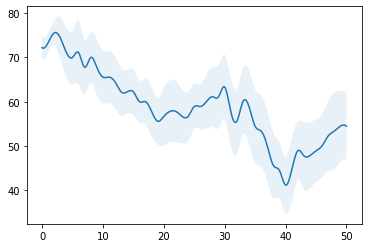

In [68]:
M=np.mean(ext_behav_matrix,axis=0)
Std=np.std(ext_behav_matrix,axis=0)/np.sqrt(9)
t=np.arange(0,M.shape[0],1)
xnew = np.linspace(t.min(), t.max(), 300)  
s = interpolate.InterpolatedUnivariateSpline(t, M)
s2 = interpolate.InterpolatedUnivariateSpline(t, Std)
M_smooth = s(xnew)
Std_smooth = s2(xnew)
plt.plot(xnew,M_smooth)
plt.fill_between(xnew,M_smooth-Std_smooth, M_smooth+Std_smooth,alpha=0.1)

plt.savefig('avg_across_animals_10_60trials.png')

## 40 trials 

In [71]:
def ext_behav_40trials(window_size,mouse_name,condition):
            
    if condition == 'Rebecca' or condition == 'New Rebecca':
        trial_nos= np.arange(20,60,1)
        sliding_window_idx=GetShiftingWindows(trial_nos, window_size)
        
        if condition == 'Rebecca':
            ext_behavior=[]
            for i in np.arange(0,len(sliding_window_idx),1):
                ext_behavior.append(rBehaviorScoring.loc[sliding_window_idx[i],mouse_name].sum()/window_size*100)
    
        elif condition == 'New Rebecca':
            ext_behavior=[]
            for i in np.arange(0,len(sliding_window_idx),1):
                ext_behavior.append(nrBehaviorScoring.loc[sliding_window_idx[i],mouse_name].sum()/window_size*100)
   
    ext_behavior=np.array(ext_behavior)
    return ext_behavior 

In [72]:
def ext_behav_Ali_40trials(window_size,mouse_name):
    trial_nos= np.arange(0,40,1)
    sliding_window_idx=GetShiftingWindows(trial_nos, window_size)
    ext_behavior=[]
   
    for i in np.arange(0,len(sliding_window_idx),1):
        ext_behavior.append(aliBehaviorScoring.loc[sliding_window_idx[i],mouse_name].sum()/window_size*100)
    return ext_behavior

In [73]:
window_size=10
ext_behav_ali24=ext_behav_Ali_40trials(window_size,'ali24_d5_s2')
ext_behav_ali25=ext_behav_Ali_40trials(window_size,'ali25_d5_s2')
ext_behav_ali26=ext_behav_Ali_40trials(window_size,'ali26_d5_s2')
ext_behav_2982=ext_behav_40trials(window_size,'2982_d9_s1','Rebecca')
ext_behav_4540=ext_behav_40trials(window_size,'4540_d9_s1','Rebecca')
ext_behav_2712=ext_behav_40trials(window_size,'2712_d5_s1','New Rebecca')
ext_behav_2713=ext_behav_40trials(window_size,'2714_d5_s1','New Rebecca')
ext_behav_2714=ext_behav_40trials(window_size,'2714_d5_s1','New Rebecca')
ext_behav_8089=ext_behav_40trials(window_size,'8089_d5_s1','New Rebecca')

In [74]:
ext_behav_matrix=np.vstack([ext_behav_ali24,ext_behav_ali25,ext_behav_ali26,ext_behav_2982,ext_behav_4540,ext_behav_2712,ext_behav_2713,ext_behav_2714,ext_behav_8089])

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


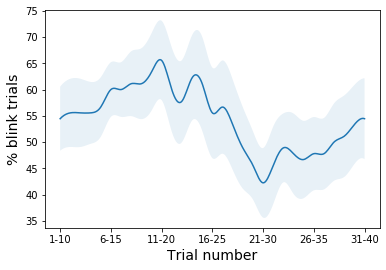

In [75]:
from scipy import interpolate
M=np.mean(ext_behav_matrix,axis=0)
Std=np.std(ext_behav_matrix,axis=0)/np.sqrt(9)
t=np.arange(0,M.shape[0],1)
xnew = np.linspace(t.min(), t.max(), 300)  
s = interpolate.InterpolatedUnivariateSpline(t, M)
s2 = interpolate.InterpolatedUnivariateSpline(t, Std)
M_smooth = s(xnew)
Std_smooth = s2(xnew)
plt.plot(xnew,M_smooth)
plt.fill_between(xnew,M_smooth-Std_smooth, M_smooth+Std_smooth,alpha=0.1)
#plt.savefig('avg_across_animals_8.png')
plt.xticks(ticks=np.arange(0,35,5),labels=('1-10','6-15','11-20','16-25','21-30','26-35','31-40'))
plt.xlabel('Trial number',fontsize=14)
plt.ylabel('% blink trials',fontsize=14)
plt.savefig('sliding_window_10_40trials.png',dpi=1200)
#plt.savefig('avg_across_animals_10_40trials.png')

### Number of blink trials and no blink trials 

In [76]:
blink_trials_24 =  aliBehaviorScoring.loc[20:,'ali24_d5_s1'].sum()
no_blink_trials_24 = 20 - blink_trials_24 

blink_trials_25 =  aliBehaviorScoring.loc[20:,'ali25_d5_s1'].sum()
no_blink_trials_25  = 20 - blink_trials_25 

blink_trials_26 =  aliBehaviorScoring.loc[20:,'ali26_d5_s1'].sum()
no_blink_trials_26 = 20 - blink_trials_26 

blink_trials_2982 =  rBehaviorScoring.loc[:19,'2982_d9_s1'].sum()
no_blink_trials_2982 = 20 - blink_trials_2982 

blink_trials_4540 =  rBehaviorScoring.loc[:19,'4540_d9_s1'].sum()
no_blink_trials_4540 = 20 - blink_trials_4540

blink_trials_2712 =  nrBehaviorScoring.loc[:19,'2712_d5_s1'].sum()
no_blink_trials_2712 = 20 - blink_trials_2712

blink_trials_2713 =  nrBehaviorScoring.loc[:19,'2713_d5_s1'].sum()
no_blink_trials_2713 = 20 - blink_trials_2713

blink_trials_2714 =  nrBehaviorScoring.loc[:19,'2714_d5_s1'].sum()
no_blink_trials_2714 = 20 - blink_trials_2714

blink_trials_8089 =  nrBehaviorScoring.loc[:19,'8089_d5_s1'].sum()
no_blink_trials_8089 = 20 - blink_trials_8089

print(blink_trials_24,blink_trials_25,blink_trials_26,blink_trials_2982,blink_trials_4540,blink_trials_2712,blink_trials_2713,blink_trials_2714,blink_trials_8089)
print(no_blink_trials_24,no_blink_trials_25,no_blink_trials_26,no_blink_trials_2982,no_blink_trials_4540,no_blink_trials_2712,no_blink_trials_2713,no_blink_trials_2714,no_blink_trials_8089)

13 14 14 13 17 11 18 11 13
7 6 6 7 3 9 2 9 7


ali24_d2_s1    0.375
ali24_d5_s1    0.525
ali24_d5_s2    0.325
ali25_d2_s1    0.875
ali25_d5_s1    0.800
ali25_d5_s2    0.475
ali26_d2_s1    0.200
ali26_d5_s1    0.625
ali26_d5_s2    0.475
dtype: float64


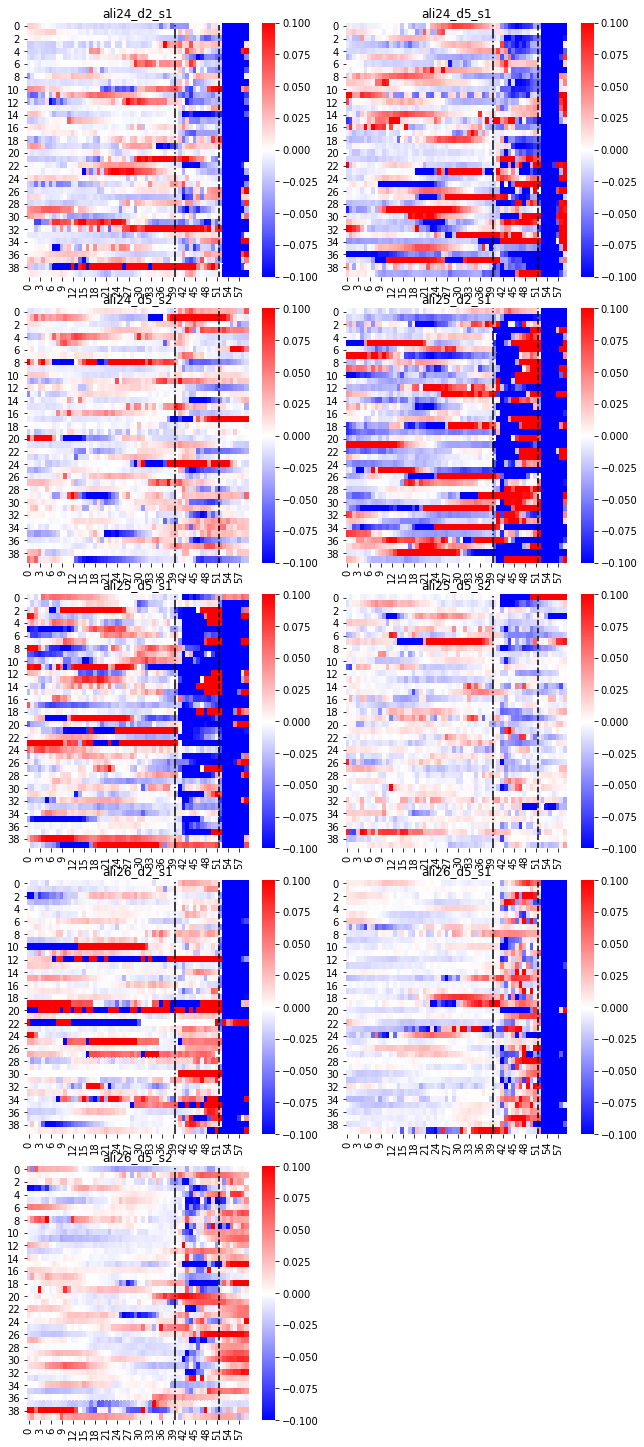

In [77]:
aliBehaviorScoring = binaryBehaviorScoring(aliEyeBlocks, aliEyeThresholds, 1)
print(aliBehaviorScoring.sum()/40.)

# Behavior Learning Plots

In [115]:
def makePairedScatterPlot_colors(df, f_size, ax=None, ax_pos = [0.2, 0.1, 0.75, 0.8], plotlines=False):
    #Make paired scatter plots with lines between paired points.  Plot Points for each column in DataFrame
    #Font Details
    label_size=7
    tick_size=6
    #Median Color Array
    clrs = [[1,0.5,0,0.5], [1,.1,.1,0.5], [0,.25,1,0.5]]
    #Get Extents
    Ncols = df.shape[0]
    #Make Figure
    if ax == None:
        fig = plt.figure(figsize=f_size)
        ax = fig.add_axes(ax_pos)
    else:
        ax.set_position(ax_pos)
    #Loop through each column
    x_iter = 0
    last_c = None
    #C = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255],[1,1,255],[255,1,1],[255,1,1],[2,255,2]])
    C=['yellow','lime','sienna','aqua','black','darkmagenta','darkblue']
    for idx, c in enumerate(df):
        avg = df[c].mean()
        ax.bar([x_iter, x_iter], [avg, avg], color=clrs[idx], zorder=0)
        ax.scatter(np.ones((Ncols,1))*x_iter, df[c], color=C, zorder=2)
        u_err, l_err = [df[c].std(), df[c].std()] # [df[c].quantile(q=0.975), df[c].quantile(q=0.025)]
        err_array = np.array([l_err, u_err]).reshape(2,-1)
        ax.errorbar(x_iter, avg, yerr=err_array, color=clrs[idx], zorder=1)
        if plotlines:
            if last_c is not None:
                x_1 = np.ones((Ncols,1))*(x_iter-1)
                x_2 = np.ones((Ncols,1))*x_iter
                y_1 = df[last_c]
                y_2 =  df[c]
                for x1, x2, y1, y2 in zip(x_1, x_2, y_1, y_2):
                    ax.plot([x1,x2], [y1,y2], '--', color=[0,0,0,0.75])
        x_iter += 1
        last_c = c
    #Final Plot Formatting
    ax.set_xticks(np.arange(0,x_iter))
    ax.set_xticklabels(df.columns, fontsize=label_size) 
    #ax.tick_params(labelsize=tick_size)
    ax.set_ylim([0, 1])
    ax.set_yticklabels(np.arange(0,101,20).round(1),fontsize=tick_size)
    ax.set_ylabel('Percentage of Trials with Squint', fontsize=label_size)
    return ax

In [116]:
def makePairedScatterPlot_colors_all(df, f_size, ax=None, ax_pos = [0.2, 0.1, 0.75, 0.8], plotlines=False):
    #Make paired scatter plots with lines between paired points.  Plot Points for each column in DataFrame
    #Font Details
    label_size=7
    tick_size=6
    #Median Color Array
    clrs = [[1,0.5,0,0.5], [1,.1,.1,0.5], [0,.25,1,0.5]]
    #Get Extents
    Ncols = df.shape[0]
    #Make Figure
    if ax == None:
        fig = plt.figure(figsize=f_size)
        ax = fig.add_axes(ax_pos)
    else:
        ax.set_position(ax_pos)
    #Loop through each column
    x_iter = 0
    last_c = None
    #C = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255],[1,1,255],[255,1,1],[255,1,1],[2,255,2]])
    C=['yellow','darkgreen','lime','sienna','aqua','slategrey','black','darkmagenta','darkblue']
    for idx, c in enumerate(df):
        avg = df[c].mean()
        ax.bar([x_iter, x_iter], [avg, avg], color=clrs[idx], zorder=0)
        ax.scatter(np.ones((Ncols,1))*x_iter, df[c], color=C, zorder=2)
        u_err, l_err = [df[c].std(), df[c].std()] # [df[c].quantile(q=0.975), df[c].quantile(q=0.025)]
        err_array = np.array([l_err, u_err]).reshape(2,-1)
        ax.errorbar(x_iter, avg, yerr=err_array, color=clrs[idx], zorder=1)
        if plotlines:
            if last_c is not None:
                x_1 = np.ones((Ncols,1))*(x_iter-1)
                x_2 = np.ones((Ncols,1))*x_iter
                y_1 = df[last_c]
                y_2 =  df[c]
                for x1, x2, y1, y2 in zip(x_1, x_2, y_1, y_2):
                    ax.plot([x1,x2], [y1,y2], '--', color=[0,0,0,0.75])
        x_iter += 1
        last_c = c
    #Final Plot Formatting
    ax.set_xticks(np.arange(0,x_iter))
    ax.set_xticklabels(df.columns, fontsize=label_size) 
    #ax.tick_params(labelsize=tick_size)
    ax.set_ylim([0, 1])
    ax.set_yticklabels(np.arange(0,101,20).round(1),fontsize=tick_size)
    ax.set_ylabel('Percentage of Trials with Squint', fontsize=label_size)
    return ax

### Using second 20 trials first session

In [117]:
allFirstDay = pd.concat([aliBehaviorScoring.loc[20:39, ('ali24_d2_s1', 'ali25_d2_s1', 'ali26_d2_s1')], rBehaviorScoring.loc[40:59,('2982_d1_s1','4540_d1_s1')].reset_index(drop=True), nrBehaviorScoring.loc[20:39,('2712_d1_s1','2713_d1_s1','2714_d1_s1','8089_d1_s1')].reset_index(drop=True)],axis=1) #,'2714_d1_s1'
allLastDay = pd.concat([aliBehaviorScoring.loc[20:39, ('ali24_d5_s1', 'ali25_d5_s1', 'ali26_d5_s1')].reset_index(drop=True), rBehaviorScoring.loc[0:19,('2982_d9_s1','4540_d9_s1')], nrBehaviorScoring.loc[0:19,('2712_d5_s1','2713_d5_s1','2714_d5_s1','8089_d5_s1')]],axis=1) #,'2714_d5_s1'
allExtinctionDay = pd.concat([aliBehaviorScoring.loc[20:39, ('ali24_d5_s2', 'ali25_d5_s2', 'ali26_d5_s2')].reset_index(drop=True), rBehaviorScoring.loc[40:59,('2982_d9_s1','4540_d9_s1')].reset_index(drop=True), nrBehaviorScoring.loc[40:59,('2712_d5_s1','2713_d5_s1','2714_d5_s1','8089_d5_s1')].reset_index(drop=True)],axis=1) #,'2714_d5_s1'

In [118]:
def reshape_grouped_df(df):
    allSeries = df.mean()
    allSeries.index = df.mean().index.str.split('_').to_series().apply(lambda x: x[0]).values
    return allSeries

In [119]:
allNewBehavior_second20 = pd.concat([reshape_grouped_df(allFirstDay), reshape_grouped_df(allLastDay), reshape_grouped_df(allExtinctionDay)], axis=1)
allNewBehavior_second20.columns=['First\nSession', 'Last\nSession', 'Extinction']
allNewBehavior_second20

First\nSession  Last\nSession  Extinction
ali24            0.35           0.65        0.45
ali25            0.80           0.70        0.40
ali26            0.30           0.70        0.40
2982             0.30           0.65        0.75
4540             0.35           0.85        0.05
2712             0.75           0.55        0.50
2713             0.70           0.90        0.65
2714             0.50           0.55        0.70
8089             0.65           0.65        0.40

In [120]:
allNewBehavior_second20['First\nSession'].loc['ali25']=np.NaN
allNewBehavior_second20['First\nSession'].loc['2712']=np.NaN
allNewBehavior_second20

First\nSession  Last\nSession  Extinction
ali24            0.35           0.65        0.45
ali25             NaN           0.70        0.40
ali26            0.30           0.70        0.40
2982             0.30           0.65        0.75
4540             0.35           0.85        0.05
2712              NaN           0.55        0.50
2713             0.70           0.90        0.65
2714             0.50           0.55        0.70
8089             0.65           0.65        0.40

In [121]:
modified_allNewBehavior_second20 = allNewBehavior_second20.drop(['ali25','2712'])
modified_allNewBehavior_second20 

First\nSession  Last\nSession  Extinction
ali24            0.35           0.65        0.45
ali26            0.30           0.70        0.40
2982             0.30           0.65        0.75
4540             0.35           0.85        0.05
2713             0.70           0.90        0.65
2714             0.50           0.55        0.70
8089             0.65           0.65        0.40

In [122]:
bS, bPval = ss.ranksums(modified_allNewBehavior_second20['First\nSession'], modified_allNewBehavior_second20['Last\nSession'])
bS, bPval 

(-2.23606797749979, 0.025347318677468252)

In [123]:
bS, bPval = ss.ranksums(allNewBehavior_second20['Last\nSession'], allNewBehavior_second20['Extinction'])
bS, bPval

(2.11925177130407, 0.034069195144143936)

In [124]:
print(allNewBehavior_second20['Last\nSession'].mean(),allNewBehavior_second20['Last\nSession'].std())

0.6888888888888889 0.11931517552730293


In [125]:
print(allNewBehavior_second20['Extinction'].mean(),allNewBehavior_second20['Extinction'].std())

0.47777777777777775 0.21081851067789195


In [126]:
print(modified_allNewBehavior_second20['First\nSession'].mean(),modified_allNewBehavior_second20['First\nSession'].std())

0.45 0.16832508230603463


In [127]:
bS, bPval = ss.ranksums(modified_allNewBehavior_second20['First\nSession'], modified_allNewBehavior_second20['Extinction'])
bS, bPval 

(-0.8305395344999218, 0.406233805110795)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

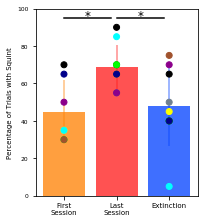

In [128]:
ax=makePairedScatterPlot_colors_all(allNewBehavior_second20, (3,3.25))
ax.plot([0,.9],[0.95,0.95], 'k')
ax.text(0.45, 0.94, '*', horizontalalignment='center', fontsize=12)
ax.plot([1,1.9],[0.95,0.95], 'k')
ax.text(1.45, 0.94, '*', horizontalalignment='center', fontsize=12)
plt.savefig('ChunkedBehaviorScoring_second20.eps', format='eps')
#plt.savefig('ChunkedBehaviorScoring_second20.png',format='png',dpi=1200)

### Compare eye closure rate vs spontaneous blink rate - first session

In [129]:
df = {'Spontaneous rate' : pd.Series(spont_blink_rate_FS, index=['ali24', 'ali25', 'ali26','2982','4540','2712','2713','2714','8089']),
     'First session': reshape_grouped_df(allFirstDay)*100}
blink_rate_FS_compare_df= pd.DataFrame(df)
blink_rate_FS_compare_df

Spontaneous rate  First session
ali24         10.150869           35.0
ali25         11.850880           80.0
ali26          9.637039           30.0
2982          27.979902           30.0
4540          22.196142           35.0
2712          20.192799           75.0
2713          15.537136           70.0
2714          29.051340           50.0
8089          29.872928           65.0

In [130]:
ss.ranksums( blink_rate_FS_compare_df['Spontaneous rate'],blink_rate_FS_compare_df['First session'])

RanksumsResult(statistic=-3.5762373640756184, pvalue=0.000348575174213053)

In [131]:
def makePairedScatterPlot_colors_all(df, f_size, ax=None, ax_pos = [0.2, 0.1, 0.75, 0.8], plotlines=False):
    #Make paired scatter plots with lines between paired points.  Plot Points for each column in DataFrame
    #Font Details
    label_size=7
    tick_size=6
    #Median Color Array
    clrs = [[1,0.5,0,0.5], [1,.1,.1,0.5], [0,.25,1,0.5]]
    #Get Extents
    Ncols = df.shape[0]
    #Make Figure
    if ax == None:
        fig = plt.figure(figsize=f_size)
        ax = fig.add_axes(ax_pos)
    else:
        ax.set_position(ax_pos)
    #Loop through each column
    x_iter = 0
    last_c = None
    #C = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255],[1,1,255],[255,1,1],[255,1,1],[2,255,2]])
    C=['yellow','darkgreen','lime','sienna','aqua','slategrey','black','darkmagenta','darkblue']
    for idx, c in enumerate(df):
        avg = df[c].mean()
        ax.bar([x_iter, x_iter], [avg, avg], color=clrs[idx], zorder=0)
        ax.scatter(np.ones((Ncols,1))*x_iter, df[c], color=C, zorder=2)
        u_err, l_err = [df[c].std(), df[c].std()] # [df[c].quantile(q=0.975), df[c].quantile(q=0.025)]
        err_array = np.array([l_err, u_err]).reshape(2,-1)
        ax.errorbar(x_iter, avg, yerr=err_array, color=clrs[idx], zorder=1)
        if plotlines:
            if last_c is not None:
                x_1 = np.ones((Ncols,1))*(x_iter-1)
                x_2 = np.ones((Ncols,1))*x_iter
                y_1 = df[last_c]
                y_2 =  df[c]
                for x1, x2, y1, y2 in zip(x_1, x_2, y_1, y_2):
                    ax.plot([x1,x2], [y1,y2], '--', color=[0,0,0,0.75])
        x_iter += 1
        last_c = c
    #Final Plot Formatting
    ax.set_xticks(np.arange(0,x_iter))
    ax.set_xticklabels(df.columns, fontsize=label_size) 
    #ax.tick_params(labelsize=tick_size)
    ax.set_ylim([0, 100])
    ax.set_yticklabels(np.arange(0,101,20).round(1),fontsize=tick_size)
    ax.set_ylabel('Eye closure rate', fontsize=label_size)
    return ax

In [132]:
def makePairedScatterPlot_colors_7(df, f_size, ax=None, ax_pos = [0.2, 0.1, 0.75, 0.8], plotlines=False):
    #Make paired scatter plots with lines between paired points.  Plot Points for each column in DataFrame
    #Font Details
    label_size=7
    tick_size=6
    #Median Color Array
    clrs = [[1,0.5,0,0.5], [1,.1,.1,0.5], [0,.25,1,0.5]]
    #Get Extents
    Ncols = df.shape[0]
    #Make Figure
    if ax == None:
        fig = plt.figure(figsize=f_size)
        ax = fig.add_axes(ax_pos)
    else:
        ax.set_position(ax_pos)
    #Loop through each column
    x_iter = 0
    last_c = None
    #C = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255],[1,1,255],[255,1,1],[255,1,1],[2,255,2]])
    C=['yellow','lime','sienna','aqua','black','darkmagenta','darkblue']
    for idx, c in enumerate(df):
        avg = df[c].mean()
        ax.bar([x_iter, x_iter], [avg, avg], color=clrs[idx], zorder=0)
        ax.scatter(np.ones((Ncols,1))*x_iter, df[c], color=C, zorder=2)
        u_err, l_err = [df[c].std(), df[c].std()] # [df[c].quantile(q=0.975), df[c].quantile(q=0.025)]
        err_array = np.array([l_err, u_err]).reshape(2,-1)
        ax.errorbar(x_iter, avg, yerr=err_array, color=clrs[idx], zorder=1)
        if plotlines:
            if last_c is not None:
                x_1 = np.ones((Ncols,1))*(x_iter-1)
                x_2 = np.ones((Ncols,1))*x_iter
                y_1 = df[last_c]
                y_2 =  df[c]
                for x1, x2, y1, y2 in zip(x_1, x_2, y_1, y_2):
                    ax.plot([x1,x2], [y1,y2], '--', color=[0,0,0,0.75])
        x_iter += 1
        last_c = c
    #Final Plot Formatting
    ax.set_xticks(np.arange(0,x_iter))
    ax.set_xticklabels(df.columns, fontsize=label_size) 
    #ax.tick_params(labelsize=tick_size)
    ax.set_ylim([0, 100])
    ax.set_yticklabels(np.arange(0,101,20).round(1),fontsize=tick_size)
    ax.set_ylabel('Eye closure rate', fontsize=label_size)
    return ax

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


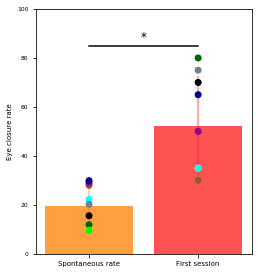

In [133]:
ax=makePairedScatterPlot_colors_all(blink_rate_FS_compare_df, (4,4.25))
ax.plot([0,1],[85,85], 'k')
ax.text(0.5, 87, '*', horizontalalignment='center', fontsize=12)
plt.savefig('Spont_rate_vs_CR_FS.eps',format='eps')

### Compare eye closure rate vs spontaneous blink rate - last session

In [134]:
df = {'Spontaneous rate' : pd.Series(spont_blink_rate_LS, index=['ali24', 'ali25', 'ali26','2982','4540','2712','2713','2714','8089']),
     'Last session': reshape_grouped_df(allLastDay)*100}
blink_rate_LS_compare_df= pd.DataFrame(df)
blink_rate_LS_compare_df

Spontaneous rate  Last session
ali24         12.878539          65.0
ali25         14.682410          70.0
ali26          7.811304          70.0
2982          27.976234          65.0
4540          24.293993          85.0
2712          18.421821          55.0
2713          30.238078          90.0
2714          25.308552          55.0
8089          28.653327          65.0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


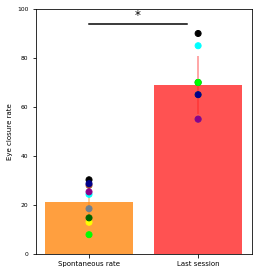

In [135]:
ax=makePairedScatterPlot_colors_all(blink_rate_LS_compare_df, (4,4.25))
ax.plot([0,.9],[94,94], 'k')
ax.text(0.45, 96, '*', horizontalalignment='center', fontsize=12)
plt.savefig('Spontaneous_vs_CR_CS.eps', format='eps')
#plt.savefig('ChunkedBehaviorScoring_second20.eps', format='eps')
#plt.savefig('ChunkedBehaviorScoring_second20.png',format='png',dpi=1200)

In [136]:
ss.ranksums(blink_rate_LS_compare_df['Spontaneous rate'],blink_rate_LS_compare_df['Last session'])

RanksumsResult(statistic=-3.5762373640756184, pvalue=0.000348575174213053)

# Make Behavior Identity Traces

In [137]:
def convertBinaryToTrace(binTrace, NScore, NBetween):
    #Function to take a binary trace of True/False and convert to a trace where each intermediate value is 0 and each score is 1 for True, -1 for False
    #Initialize Values/Traces
    Ntrials = binTrace.shape[0]
    Ntime = NScore*Ntrials + NBetween*Ntrials + NBetween #Timepoints for Trials, Timepoints for Between after each trial, and one extra Between for beginning
    outTrace = np.zeros((Ntime,))
    outInds = range(NBetween, Ntime, NBetween+NScore) #Indexes for each Trial On
    #Manipulate Binary Trace
    intTrace = binTrace.copy()
    intTrace[binTrace==True] = 1
    intTrace[binTrace==False] = -1
    for idx, choiceInd in enumerate(outInds):
        outTrace[choiceInd:(choiceInd+NScore)] = intTrace[idx]
    return outTrace

In [138]:
def binaryTrialTrace(trial, score, mouse):
    #Take inputted trial trace and score trace and give outputted binary trace with 1 for blink and -1 for no blink
    outTraces = pd.DataFrame(data=np.zeros((trial.shape[0], 2)), columns=['Blink','NoBlink'])
    trialOns = trial.index[trial > 0]
    trialOffs = trial.index[trial < 0]
    for idx, val in enumerate(score):
        if val: #True Blink
            outTraces.loc[trialOns[idx]:trialOffs[idx], 'Blink'] = 1
        else: #False Blink
            outTraces.loc[trialOns[idx]:trialOffs[idx], 'NoBlink'] = -1
    mIdx = pd.MultiIndex.from_product([[mouse],outTraces.columns])
    outTraces.columns = mIdx
    return outTraces

In [139]:
def makeTrialPlots(trial_df, score_df, whichData=None, singleMouse=False):
    #Take an inputted Binary Trial DataFrame with matching scores for each trial and Output Blink Yes/No Traces at each trial point
    #Trial DataFrame can be off sometimes (ali24_d2_s1), so binSounds can be used instead of trial_df, as long as score_df has correct number of trials
    
    #Initialize Plot Information
    #Fixed Plot Parameters
    maxWidth = 2.
    first20Idx = 13151
    #Dynamic Parameters
    if not singleMouse:
        mice = score_df.columns
    else:
        mice = pd.Index([singleMouse])
    if whichData == 'Rebecca':
        Nmice = mice.shape[0] / 3
        Nplots = mice.shape[0] + Nmice*2
    elif whichData == 'Ali':
        Nplots = mice.shape[0]
    layoutR, layoutC = [np.ceil(Nplots/maxWidth).astype(int), int(min(Nplots, maxWidth))]
    #Make Plots
    if not singleMouse:
        fig, all_ax = plt.subplots(figsize=(9, layoutR*4), nrows=layoutR, ncols=layoutC)
    else:
        fig, all_ax = plt.subplots(figsize=(9, layoutR*4), nrows=layoutR, ncols=layoutC)
        all_ax = np.array(np.array(all_ax))
    fig.tight_layout()
    try: #Reshape if only one row of axes indexes
        all_ax.shape[1]
    except:
        all_ax = all_ax.reshape(1,-1)
    
    #Initialize Data for Making Traces
    trialEdges = trial_df.apply(findPulses, axis=0)
    allTraces = []
    ridx, cidx = [0,0]
    for mouse in mice:
        print(mouse)
        curMouse_df = binaryTrialTrace(trialEdges[mouse], score_df[mouse], mouse)
        if whichData =='Ali':
            # Plotting and Parameters
            if ('s2' in mouse):
                no_blink_color = 'b'
            else:
                no_blink_color = 'r'
            sel_ax = all_ax[ridx][cidx]
            sel_ax.plot(curMouse_df.loc[:,(mouse,'NoBlink')], no_blink_color)
            sel_ax.plot(curMouse_df.loc[:,(mouse,'Blink')], 'k')
            sel_ax.set_title(mouse)
        elif whichData =='Rebecca':
            # Plotting and Parameters
            if ('d1' in mouse) | ('d9' in mouse):
                if ('d1' in mouse):
                    no_blink_color1 = 'm'
                    no_blink_color2 = 'r'
                elif ('d9' in mouse):
                    no_blink_color1 = 'r'
                    no_blink_color2 = 'b'
                sel_ax = all_ax[ridx][cidx] #Plot first 20
                sel_ax.plot(curMouse_df.loc[:first20Idx,(mouse,'NoBlink')], no_blink_color1)
                sel_ax.plot(curMouse_df.loc[:first20Idx,(mouse,'Blink')], 'k')
                sel_ax.set_title('{}_first20'.format(mouse))
                if (cidx == (maxWidth-1)):
                    ridx += 1
                    cidx = 0
                else:
                    cidx += 1
                sel_ax = all_ax[ridx][cidx] #Plot Last 40
                sel_ax.plot(curMouse_df.loc[first20Idx:,(mouse,'NoBlink')], no_blink_color2)
                sel_ax.plot(curMouse_df.loc[first20Idx:,(mouse,'Blink')], 'k')
                sel_ax.set_title('{}_last40'.format(mouse))
            else:
                sel_ax = all_ax[ridx][cidx]
                sel_ax.plot(curMouse_df.loc[:,(mouse,'NoBlink')], 'r')
                sel_ax.plot(curMouse_df.loc[:,(mouse,'Blink')], 'k')
                sel_ax.set_title(mouse)
        if (cidx == (maxWidth-1)):
            ridx += 1
            cidx = 0
        else:
            cidx += 1
        allTraces.append(curMouse_df)
    allScoreTraces = pd.concat(allTraces, axis=1)
    return allScoreTraces

2982_d1_s1
2982_d2_s1
2982_d9_s1
4540_d1_s1
4540_d2_s1
4540_d9_s1


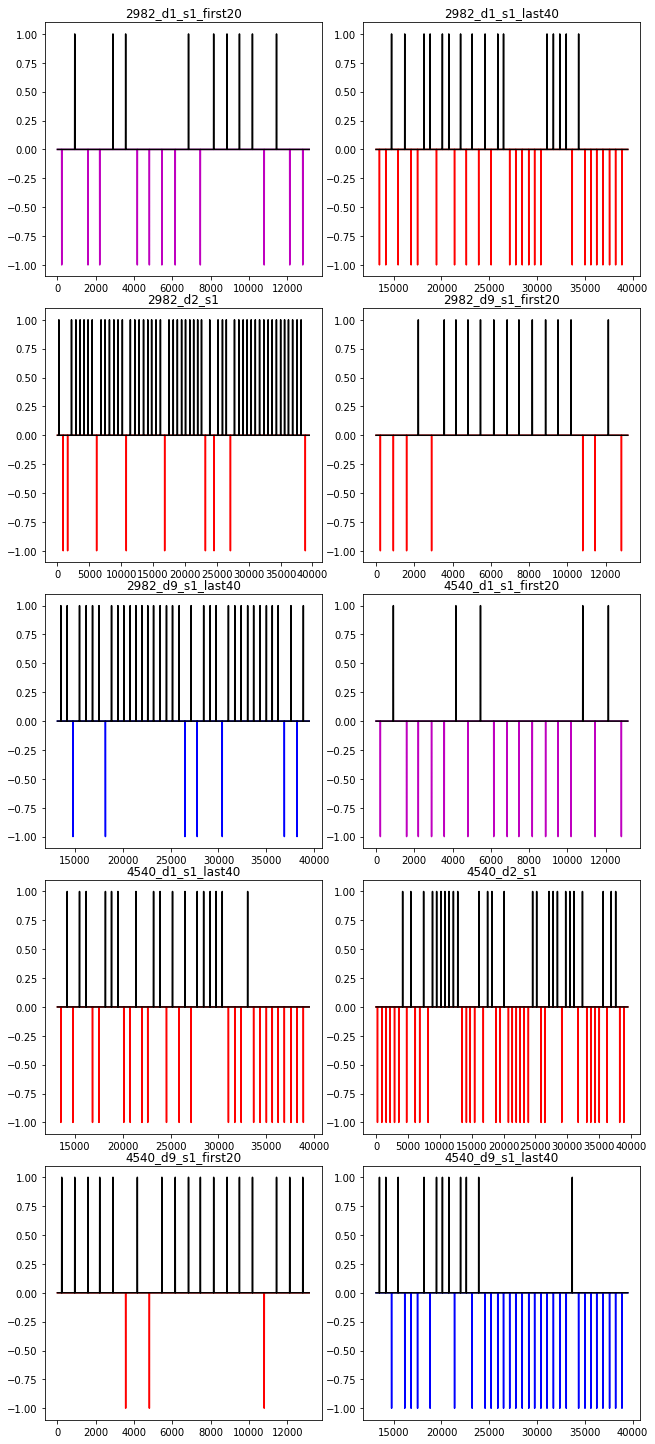

In [140]:
rScoreTraces = makeTrialPlots(rSounds, rBehaviorScoring, whichData='Rebecca')

ali24_d2_s1
ali24_d5_s1
ali24_d5_s2
ali25_d2_s1
ali25_d5_s1
ali25_d5_s2
ali26_d2_s1
ali26_d5_s1
ali26_d5_s2


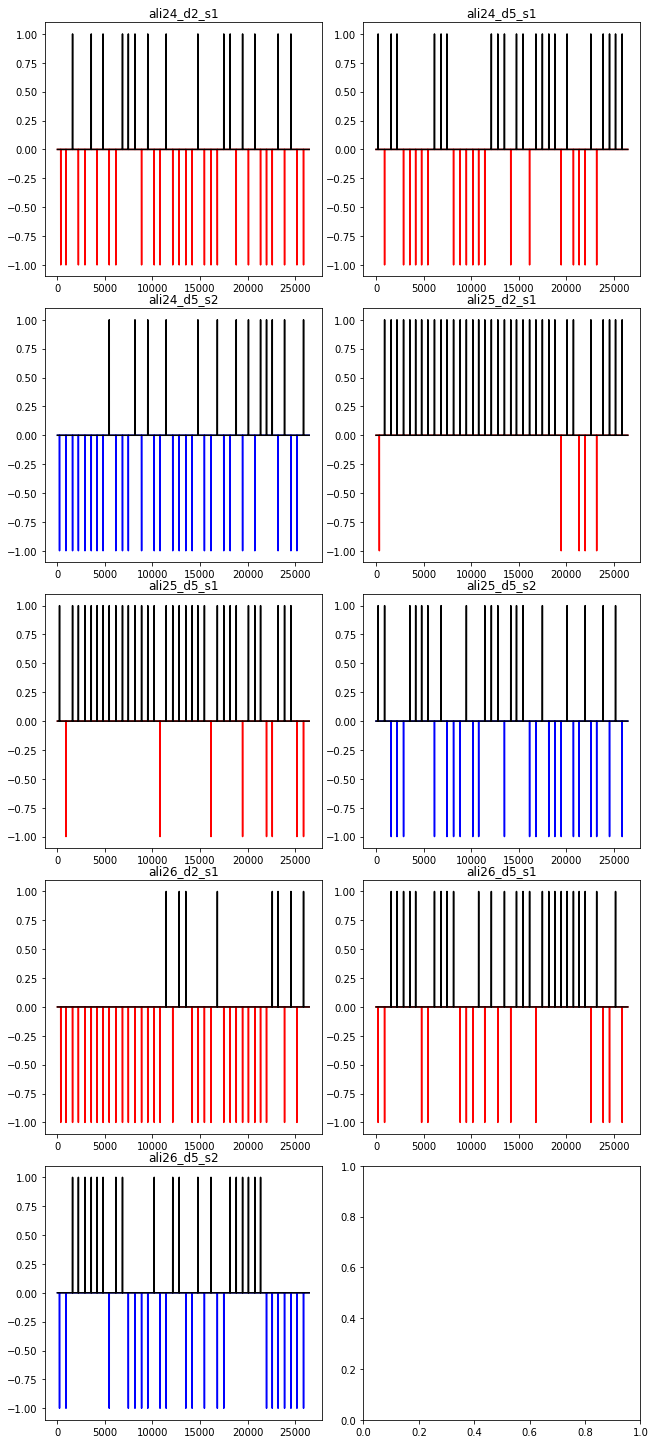

In [141]:
aliScoreTraces = makeTrialPlots(aliSounds, aliBehaviorScoring, whichData='Ali')

ali24_d5_s1


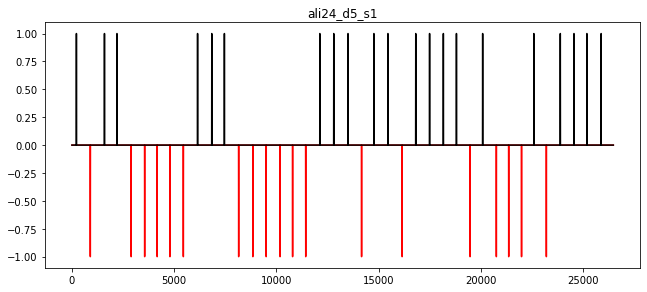

In [142]:
_ = makeTrialPlots(aliSounds, aliBehaviorScoring, whichData='Ali', singleMouse='ali24_d5_s1')

# Load Neuronal Data and Pre-process traces

In [143]:
def calcBaselineDistributions(df, regress_thresh=0.05, pct_datapoints=0.5):
    #Take DataFrame of traces, fit linear baseline, and calculate calcium threshold from devaition of residuals from that fit
    #Number of points for linear fit (Default is 0.5, or first half of sorted data)
    N_linfit = int(np.floor(df.shape[0]*pct_datapoints))
    #Calculate Distribution Fits and Generate Parameters and Outputs Matrix
    dist_series = df.apply(lambda x: ss.probplot(x)[0], axis=0)
    distributions = pd.DataFrame(data=[dist_series[item] for item in dist_series])
    #Rename Columns/Rows, since doesn't work at creation time for some reason...
    distributions.columns = ['Theoretical', 'Measured']
    distributions.index = dist_series.columns
    param_series = distributions.apply(lambda x: curve_fit(linear_func, x['Theoretical'][:N_linfit], x['Measured'][:N_linfit]), axis=1)
    distributions[['Parameters','Covariance']] = pd.DataFrame(data=[item for item in param_series], index=distributions.index, columns=['Parameters', 'Covariance'])
    distributions['Line'] = distributions.apply(lambda x: linear_func(x['Theoretical'], *x['Parameters']), axis=1)
    distributions['Difference'] = distributions.apply(lambda x: (x['Measured'] - x['Line']) / (np.nanmax(x['Measured']) - np.nanmin(x['Measured'])), axis=1)
    distributions['Deviation_idx'] = distributions.apply(lambda x: np.argmax(x['Difference'][N_linfit:] > regress_thresh)+N_linfit, axis=1)
    distributions['Ca_thresh'] = distributions.apply(lambda x: x['Measured'][x['Deviation_idx']], axis=1)
    
    return distributions

In [144]:
def scaleTraces(df):
    #Take DataFrame of traces, subtract off linear baseline and scale by percentage of maximum values for cell
    distribution_calculations = calcBaselineDistributions(df)
    #Get list of values into DataFrames/Series for scaling
    scale_vals = distribution_calculations.loc[:,('Parameters', 'Ca_thresh')].transpose(copy=True)
    baseline_list = []
    for row in scale_vals.loc['Parameters',:]:
        baseline_list.append(row[1])
    scale_vals.loc['Baseline',:] = pd.Series(baseline_list, index=scale_vals.columns)
    scale_vals.loc['Unit_Val',:] = scale_vals.loc['Ca_thresh',:] - scale_vals.loc['Baseline',:]
    #Adjust by subtracting baseline and dividing by scaling unit
    scaled_df = (df - scale_vals.loc['Baseline',:]) / scale_vals.loc['Unit_Val',:]
    
    return scaled_df,scale_vals

In [145]:
def loadTraces(files, whichData):
    #Load all the trace data and normalize traces with baseline adjustments
    #Load and doughnut subtract traces
    rawTraces = loadFiles(files, 'trace', whichData=whichData, multiIndex=True)
    BGTraces = loadFiles(files, 'BG10trace', whichData=whichData, multiIndex=True)
    traces = rawTraces.subtract(BGTraces)
    #Adjust Baseline Calculations
    scaled_traces,scale_vals = scaleTraces(traces)
    #Load Color Info TODO: Add Loading Color Values to loadFiles
    #colors = loadFiles(files, 'color', whichData)
    
    return scaled_traces

In [146]:
aliTraces = loadTraces(aliFiles, 'Ali')
rTraces = loadTraces(rFiles, 'Rebecca')
nrTraces = loadTraces(nrFiles, 'Rebecca')

In [147]:
aliTraces['ali24_d5_s1']

cell_num       0         1         2         3         4         5    \
Time                                                                   
0         5.799987 -0.884888  0.167903 -0.468016 -0.356346  5.962002   
1         5.882637 -1.071724 -0.038026 -0.282277  0.388570  5.880943   
2         5.800030 -1.162136  0.084656 -0.172674 -0.328978  5.473740   
3         5.825612 -1.068441 -0.284940 -0.283683 -0.519773  5.370838   
4         5.913655 -1.006622 -0.335156 -0.340898 -0.414202  5.618566   
...            ...       ...       ...       ...       ...       ...   
26477     0.069517 -0.043959  0.054139  0.061903 -0.633305  0.250597   
26478    -0.119850  0.356627  0.064824 -0.240327 -0.188767  0.623825   
26479    -0.066239  0.590744  0.240939 -0.114610 -0.330584  0.750845   
26480    -0.199097  0.302895  1.416960 -0.052839 -0.052518  0.611546   
26481     0.103009  0.367324  1.998747  0.063129 -1.177136  0.674805   

cell_num       6          7         8         9    ...       443       444  \
Time                                               ...                       
0         1.215698  13.412928  0.561809  4.080587  ... -0.538441 -0.889134   
1         0.431020  13.585371  0.727005  3.864594  ... -0.776070 -0.583079   
2         1.304278  13.508612  0.926163  3.636168  ... -0.530700 -0.894986   
3         0.814441  13.549855  0.702709  3.415028  ... -0.596674 -0.785495   
4         1.264749  13.333508  0.759215  3.310764  ... -0.457810 -0.746776   
...            ...        ...       ...       ...  ...       ...       ...   
26477     2.122707  -0.032789 -0.167336 -0.481105  ... -0.096375 -0.133518   
26478     2.416648   0.236900 -0.578095 -0.434930  ... -0.295195 -0.302179   
26479     2.160329   0.140651 -0.358482 -0.575729  ... -0.364835 -0.377917   
26480     2.493976   0.212977 -0.118250 -0.232546  ... -0.285616 -0.447200   
26481     2.099444   0.108298 -0.348835 -0.826393  ... -0.792163 -0.527991   

cell_num       445       446       447       448       449       450  \
Time                                                                   
0        -0.358685 -0.864948  0.143416  0.176512  0.057230 -0.705103   
1        -0.184463 -0.660083  0.396744  0.406921 -0.076532 -0.625533   
2        -0.420167 -0.659941  0.207654  0.177814 -0.257261 -0.545326   
3        -0.571160 -0.867155  0.154713  0.051783 -0.048908 -0.724998   
4        -0.665255 -0.716625 -0.004982  0.358310 -0.000448 -0.554713   
...            ...       ...       ...       ...       ...       ...   
26477    -0.147197  0.607822 -0.203739 -0.078649 -0.614454  0.141375   
26478    -0.033836  0.398945  0.173556 -0.592412 -0.479876 -0.054756   
26479    -0.298076  0.484961 -0.021843 -0.442984 -0.185726  0.007737   
26480     0.139559  0.397221  0.153750 -0.296881 -0.721903 -0.272151   
26481    -0.645194  0.493651 -0.339789 -0.453186 -0.351687 -0.027073   

cell_num       451       452  
Time                          
0        -0.432943 -0.202437  
1        -0.570646 -0.529892  
2        -0.566802 -0.649056  
3        -0.576960 -0.560488  
4        -0.618288 -0.564169  
...            ...       ...  
26477    -0.193456 -0.027881  
26478    -0.113596  0.348798  
26479    -0.066314  0.379031  
26480    -0.442249 -0.013000  
26481    -0.178532  0.383754  

[26482 rows x 453 columns]

# Plots to inspect raw traces

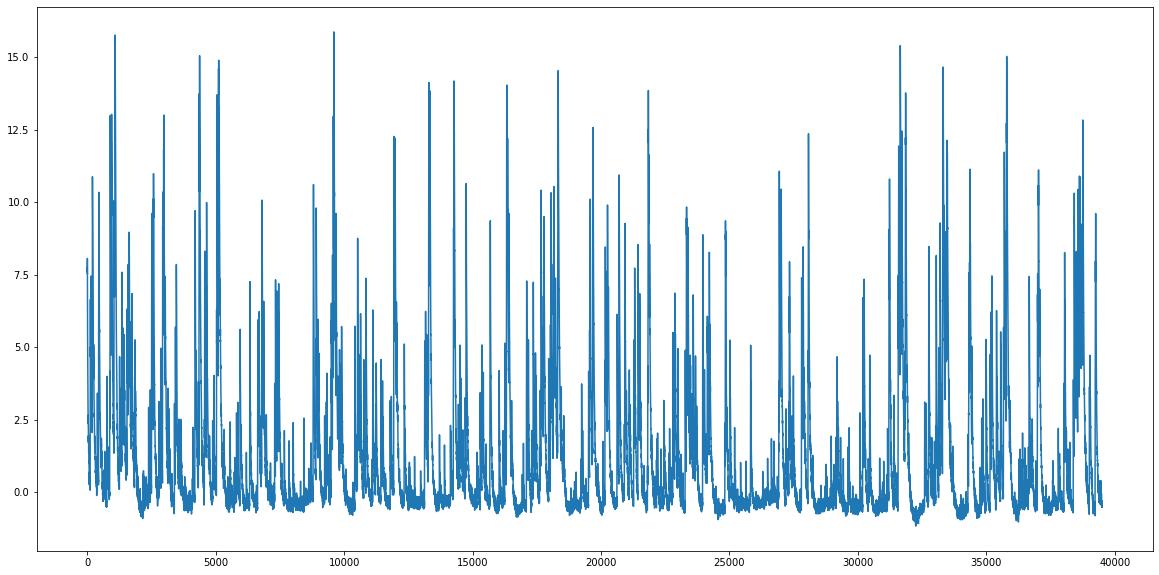

In [148]:
plt.figure(figsize=(20,10))
plt.plot(rTraces.loc(axis=1)['4540_d1_s1',6])
#plt.xlim([20000,25000])

In [149]:
nrTraces['8089_d5_s1']

cell_num        0         1         2         3         4         5   \
Time                                                                   
0         2.240959  1.286001  0.197001  0.277211 -0.042141  0.118063   
1         2.132950  1.368734 -0.040111  0.096638 -0.001395  0.051975   
2         2.011442  1.140494 -0.104864  0.114329 -0.062068  0.040863   
3         2.203194  1.261750 -0.090963  0.134976 -0.018113  0.199917   
4         2.113712  1.354846  0.004854  0.126410 -0.016988  0.159497   
...            ...       ...       ...       ...       ...       ...   
39494     0.113174 -0.021397  1.928579 -0.194090  0.047656  0.152166   
39495    -0.098123 -0.084576  1.751299 -0.278193  0.142703  0.088113   
39496    -0.192728 -0.132120  1.632427 -0.382529  0.165020  0.103530   
39497    -0.087495 -0.079941  1.414503 -0.277730  0.128753  0.087241   
39498    -0.071447 -0.021539  1.728035 -0.243454  0.098482  0.174037   

cell_num        6         7         8         9   ...        65        66  \
Time                                              ...                       
0        -0.064726  0.159435 -0.306659  0.277976  ... -0.165544 -0.243593   
1        -0.073956  0.141683 -0.251544  0.103824  ... -0.238767 -0.229206   
2        -0.216628  0.239133 -0.209661  0.272959  ...  0.088848 -0.241351   
3        -0.209960  0.260832 -0.302231  0.135188  ...  0.170037 -0.062546   
4        -0.227429  0.068084  0.326171  0.201158  ...  0.042250 -0.099622   
...            ...       ...       ...       ...  ...       ...       ...   
39494     0.040060 -0.024686  0.020740 -0.180563  ...  0.029790  1.254232   
39495    -0.100564 -0.117439 -0.085036  0.140945  ...  0.181552  0.997437   
39496    -0.100133  0.005454 -0.028225  0.043799  ...  0.082924  1.028668   
39497    -0.155261  0.038216  0.007719  0.010982  ...  0.065774  0.890800   
39498    -0.016367 -0.044070 -0.031593 -0.140207  ...  0.209670  0.999591   

cell_num        67        68        69        70        71        72  \
Time                                                                   
0         0.698784  0.230883  0.449520 -0.309699 -0.184572  0.513680   
1         0.700737  0.085804  0.467718 -0.113984  0.071739  0.332749   
2         0.825639  0.036420  0.536271 -0.092636  0.044604  0.332521   
3         0.849309  0.096474  0.558094 -0.066387  0.060637  0.374448   
4         0.558069  0.199020  0.657423 -0.277137 -0.132246  0.255994   
...            ...       ...       ...       ...       ...       ...   
39494     0.545014 -0.178220 -0.213690 -0.162645  2.289990  0.008556   
39495     0.036549 -0.258407 -0.154354 -0.052374  2.098905 -0.035079   
39496    -0.086531 -0.340122 -0.050503 -0.019473  2.269326 -0.071659   
39497    -0.079564 -0.238887 -0.023956 -0.168244  2.028350 -0.284287   
39498     0.388873 -0.131225 -0.135592  0.048480  2.140974 -0.003742   

cell_num        73        74  
Time                          
0         0.217361 -0.008929  
1         0.222215  0.119479  
2         0.085193  0.010613  
3         0.180159  0.165555  
4         0.113884  0.079150  
...            ...       ...  
39494    -0.053257 -0.428936  
39495     0.014050 -0.380002  
39496    -0.085578 -0.425678  
39497    -0.129129 -0.405335  
39498    -0.043088 -0.286406  

[39499 rows x 75 columns]

# Match Ali Cells Between Sessions

In [150]:
def loadMatchedIndexes(files):
    #Function to load matched cell indexes and output them in a DataFrame
    allInds=[]
    for f in files:
        name = f.split('/')[-2]
        if ('d5' in name):
            f_open = h5py.File(f,'r')
            mIdx = pd.MultiIndex.from_tuples([(name,'lastTraining')], names=['mouse','session'])
            cellIndexes = pd.DataFrame(data=np.array(f_open['lastTraining_d5_s1_index']), columns=mIdx)
            cellIndexes[name,'firstExtinction'] = np.array(f_open['firstExtinction_d5_s2_index'])
            allInds.append(cellIndexes)
    return pd.concat(allInds, axis=1)

In [151]:
def matchDF(traces, match_df):
    #Function to compare match values in a dataframe and output only those matched in appropriate sessions
    #Includes re-sorting to ensure column match at cell-level
    mice = traces.columns.unique('mouse')
    matchedInds=[]
    for mouse in mice:
        print(mouse)
        if ('d5' in mouse): #If a d5 Session with Matching
            match_sess = match_df[mouse].dropna()
            if ('s1' in mouse):
                search_col = 'firstExtinction'
                sel_col = 'lastTraining'
                sel_inds = (match_sess.loc[(match_sess[search_col] != -1), sel_col] - 1).values.astype(int)
                trace_sess = traces[mouse]
                out_sess = trace_sess.loc[:,sel_inds]
            elif ('s2' in mouse):
                search_col = 'lastTraining'
                sel_col = 'firstExtinction'
                #Number Magic because Pandas Dataframes with MultiIndexing doesn't sort correctly... :(
                sel_inds_wrongSorting = (match_sess.loc[(match_sess[search_col] != -1), sel_col] - 1).values.astype(int)
                sel_inds_toSort = (match_sess.loc[(match_sess[search_col] != -1), search_col] - 1).values.astype(int)
                sorting_inds = np.argsort(sel_inds_toSort)
                sel_inds = sel_inds_wrongSorting[sorting_inds]
                #corr_sorting_multi_cols = pd.MultiIndex.from_product([sel_inds], names=['cell_num'])
                trace_sess = traces[mouse]
                out_sess = trace_sess.loc[:,sel_inds]
            mIdx = pd.MultiIndex.from_product([[mouse],range(sel_inds.shape[0])], names=['mouse','cell_num'])
            out_sess.columns = mIdx
            matchedInds.append(out_sess)
        else: #No d5 Session with Matching
            noChange = traces[mouse]
            noChange.columns = pd.MultiIndex.from_product([[mouse],noChange.columns], names=['mouse','cell_num'])
            matchedInds.append(noChange)
    return pd.concat(matchedInds, axis=1)

In [152]:
def matchCells(files, traces):
    #Function to cell index matches and output a DataFrame with those cell indexes matched
    #Load Matched Indexes
    matchInds = loadMatchedIndexes(files)
    
    #Match Indexes and Output
    matchedTraces = matchDF(traces, matchInds)
        
    return matchedTraces, matchInds

In [153]:
aliMatched, aliMatchInds = matchCells(aliFiles, aliTraces)

ali24_d2_s1
ali24_d5_s1
ali24_d5_s2
ali25_d2_s1
ali25_d5_s1
ali25_d5_s2
ali26_d2_s1
ali26_d5_s1
ali26_d5_s2


## Save matched ali traces in hdf5 filesto run event detection 

In [154]:
traces= aliTraces['ali24_d5_s1']
f1 = h5py.File("traces_ali24_s1_matched.h5", "w")
dset1 = f1.create_dataset("/traces", data=traces)
f1.close()

In [155]:
traces= aliTraces['ali24_d5_s2']
f1 = h5py.File("traces_ali24_s2_matched.h5", "w")
dset1 = f1.create_dataset("/traces", data=traces)
f1.close()

# Make Temporal Blocks for Averaged Plots

In [156]:
def makeTraceTrialBlocks(trace_df, behav_df):
    #Make Blocks of Trials for Traces (with MultiIndex), and return df with those trial blocks removed
    #Pre-defined Values
    tot_block_time = 201 #201 timepoints is about 10 seconds
    before_sound_time = 40 #40 timepoints before the puff 2 seconds
    after_sound_time = tot_block_time - before_sound_time - 1 #Time after sound.  Subtract 1 as index between before sound and after sound is included as "spot"
    #Shorten behav_df to length of trace_df
    behav_length = behav_df.shape[0]
    trace_length = trace_df.shape[0]
    if behav_length > trace_length:
        behav_df = behav_df.loc[:(trace_length-1),:]
    #Initialize Lists
    trace_blocks=[]
    trace_noBlocks=[]
    for mouse, cell_df in trace_df.groupby(level='mouse', axis=1):
        print(mouse) #Output Tracking
        #Shape Behavior Data
        soundPulses = findPulses(behav_df.loc[:,mouse])
        sound_on_inds = behav_df.index[soundPulses == 1]
        if sound_on_inds[-1]+after_sound_time > trace_df.loc[:,mouse].shape[0]: #Get rid of last pulse on at end of recording
            sound_on_inds = sound_on_inds[:-1]
        #Setup Numpy Arrays for Faster Loops
        cur_block = np.zeros((tot_block_time, sound_on_inds.shape[0], cell_df.shape[1]))
        cur_noBlock = cell_df.copy()
        cur_blockDrop = []
        for trial_idx, spot in enumerate(sound_on_inds):
            cur_block[:, trial_idx, :] = cell_df.loc[(spot-before_sound_time):(spot+after_sound_time), :].values
            cur_blockDrop.append(range((spot-before_sound_time), (spot+after_sound_time)))
        #Drop Indexes from Current Values and Save Dataframe
        flat_blockDrop = [value for sublist in cur_blockDrop for value in sublist]
        trace_noBlocks.append(cur_noBlock.drop(flat_blockDrop).reset_index(drop=True))
        #Make DataFrame for Current Cell Case
        mIdx = pd.MultiIndex.from_product([[mouse], range(sound_on_inds.shape[0]), range(cell_df.shape[1])], names=['mouse', 'trial', 'cell_num'])
        cur_df = pd.DataFrame(data=cur_block.reshape(tot_block_time,-1), columns=mIdx)
        trace_blocks.append(cur_df)
    #Convert Lists into Concatenated DataFrame
    trace_noBlocks_df = pd.concat(trace_noBlocks, axis=1)
    trace_blocks_df = pd.concat(trace_blocks, axis=1)
    trace_blocks_df.index.name = 'Time'
    return trace_blocks_df, trace_noBlocks_df

In [157]:
print('Ali Blocks')
aliTraceBlocks, aliTraceNoBlocks = makeTraceTrialBlocks(aliMatched, aliSounds) #Can do aliTraces for all Cells
aliTraceBlocks_all, aliTraceNoBlocks = makeTraceTrialBlocks(aliTraces, aliSounds)
print('Rebecca Blocks')
rTraceBlocks, rTraceNoBlocks = makeTraceTrialBlocks(rTraces, rSounds)
print('New Rebecca Blocks')
nrTraceBlocks, nrTraceNoBlocks = makeTraceTrialBlocks(nrTraces, nrSounds)

Ali Blocks
ali24_d2_s1
ali24_d5_s1
ali24_d5_s2
ali25_d2_s1
ali25_d5_s1
ali25_d5_s2
ali26_d2_s1
ali26_d5_s1
ali26_d5_s2
ali24_d2_s1
ali24_d5_s1
ali24_d5_s2
ali25_d2_s1
ali25_d5_s1
ali25_d5_s2
ali26_d2_s1
ali26_d5_s1
ali26_d5_s2
Rebecca Blocks
2982_d1_s1
2982_d2_s1
2982_d9_s1
4540_d1_s1
4540_d2_s1
4540_d9_s1
New Rebecca Blocks
2712_d1_s1
2712_d5_s1
2713_d1_s1
2713_d5_s1
2714_d1_s1
2714_d5_s1
8089_d1_s1
8089_d5_s1


In [158]:
aliTraceBlocks['ali24_d5_s1']

trial           0                                                     \
cell_num       0         1         2         3         4         5     
Time                                                                   
0         0.003119 -1.037333  1.467949 -0.050511  0.201709 -0.129994   
1        -0.036682 -0.977026  1.243465  0.145538  0.403441 -0.063480   
2         0.032361 -0.749572  1.425212  0.036569  0.564609 -0.362525   
3         0.171013 -0.854898  1.535045  0.167631  0.444033 -0.211450   
4         0.183122 -0.942762  1.470237  0.028031  0.420065 -0.258889   
...            ...       ...       ...       ...       ...       ...   
196       0.446875 -0.233976 -0.387670  0.197860  0.120164  4.816075   
197       0.503123 -0.142259 -0.454453  0.164111 -0.132688  5.225527   
198       0.369586 -0.162004 -0.564003  0.420813  0.066087  4.920138   
199       0.383077 -0.243452 -0.759130  0.338387  0.224956  4.886348   
200       0.453334 -0.307164 -0.545124  0.247533  0.028590  4.519670   

trial                                             ...        39            \
cell_num       6         7         8         9    ...       291       292   
Time                                              ...                       
0         1.231508  0.501316  0.243319 -0.226950  ... -0.250032  0.110017   
1         1.106703  0.356023  0.295550 -0.229288  ...  0.051559  0.076163   
2         1.358348  0.203901  0.140862 -0.325943  ... -0.088460 -0.542362   
3         1.198765  0.408705  0.177675  0.111492  ... -0.330054 -0.023800   
4         1.354093  0.244888  0.117193 -0.474166  ... -0.131843 -0.253502   
...            ...       ...       ...       ...  ...       ...       ...   
196       1.457124  0.024981  0.414986 -0.262113  ...  1.626193  0.038342   
197       1.403030  0.394041  0.337795  0.131006  ...  1.452242  0.402935   
198       1.292967  0.304271 -0.125731 -0.000723  ...  1.288504  0.401535   
199       1.450590  0.000856  0.050253 -0.040189  ...  1.747797  0.480717   
200       1.159319  0.212674  0.423179 -0.281365  ...  1.489703  1.492549   

trial                                                                 \
cell_num       293       294       295       296       297       298   
Time                                                                   
0        -0.281956 -0.514265  0.093513 -0.360505  0.286482 -0.811477   
1        -0.228644 -0.204349 -0.273767 -0.279125 -0.086326 -0.115546   
2        -0.569253 -0.435454 -0.316005 -0.018396 -0.051742 -0.544768   
3        -0.527352  0.008040  0.018175 -0.587091  0.181510 -0.587318   
4        -0.427717 -0.299346 -0.013286 -0.421760  0.353314 -0.982797   
...            ...       ...       ...       ...       ...       ...   
196      -0.201478  0.085234  0.061089 -0.016165  0.213848 -0.650496   
197      -0.316313  0.053292  0.189234  0.068354  0.125070 -0.592139   
198      -0.269346 -0.155716 -0.030142  0.016091  0.518295 -0.005118   
199      -0.280617  0.188225  0.253148  0.032833  0.294362 -0.493185   
200      -0.359868 -0.175426  0.234483 -0.231685  0.182884 -0.559687   

trial                         
cell_num       299       300  
Time                          
0        -0.359009 -0.269261  
1         0.016151 -0.143869  
2        -0.033951 -0.026720  
3        -0.313458 -0.231417  
4        -0.155024 -0.364646  
...            ...       ...  
196      -0.454352  0.042482  
197      -0.445040  0.163622  
198      -0.213768 -0.156049  
199      -0.452850 -0.007167  
200      -0.377820 -0.032213  

[201 rows x 12040 columns]

### Spatial calculations

In [159]:
def makeAliSpatialNames(mouse_numbers, mouse_days, mouse_sessions):
    #Input lists of mouse numbers, days, and sessions to permute to give out directories and dictionary for filename
    directories = []
    filenames = {}
    for m_num in mouse_numbers:
        for m_day in mouse_days:
            for m_sess in mouse_sessions:
                mouse_dir = 'ali{}_d{}_s{}/'.format(m_num, m_day, m_sess)
                directories.append(mouse_dir)
                filenames[mouse_dir] = mouse_dir[:-1] + '_AllSpatialCalculations.npz'
    return directories, filenames

In [160]:
def makeRebeccaSpatialNames(mouse_numbers, mouse_days, mouse_sessions):
    #Input lists of mouse numbers, days, and sessions to permute to give out directories and dictionary for filename
    directories = []
    filenames = {}
    for m_num in mouse_numbers:
        for m_day in mouse_days:
            for m_sess in mouse_sessions:
                mouse_dir = '{}/{}_d{}_s{}/'.format(m_num, m_num, m_day, m_sess)
                directories.append(mouse_dir)
                filenames[mouse_dir] = mouse_dir.split('/')[1] + '_AllSpatialCalculations.npz'
    return directories, filenames

In [161]:
def combineSpatialNames(base, dirs, fnDict):
    #Combine Filenames into list for multiple directories with a common base.  fnDict is a dictionary of the filename for each directory
    outFiles = []
    for d in dirs:
        outFiles.append(os.path.join(base+d+fnDict[d]))
    return outFiles

In [164]:
aliSpatMice, aliSpatDays, aliSpatSess = [24,25,26], [5], [1]
aliBase = '/home/hanlabadmins/eng_handata_2/Kyle_Hansen/AliEyeBlink/'
rSpatMice, rSpatDays, rSpatSess = [2982, 4540], [9], [1]
rBase = '/home/hanlabadmins/eng_handata_2/eng_research_handata2/Kyle_Hansen/TonePuff-Rebecca/'
nrSpatMice, nrSpatDays, nrSpatSess = [2712,2713,2714,8089], [5], [1]
nrBase = '/home/hanlabadmins/eng_handata_2/eng_research_handata2/Kyle_Hansen/TonePuff_Rebecca2/'
aSpDirs, aSpFns = makeAliSpatialNames(aliSpatMice, aliSpatDays, aliSpatSess)
rSpDirs, rSpFns = makeRebeccaSpatialNames(rSpatMice, rSpatDays, rSpatSess)
nrSpDirs, nrSpFns = makeRebeccaSpatialNames(nrSpatMice, nrSpatDays, nrSpatSess)
aliSpat = combineSpatialNames(aliBase, aSpDirs, aSpFns)
rSpat = combineSpatialNames(rBase, rSpDirs, rSpFns)
nrSpat = combineSpatialNames(nrBase, nrSpDirs, nrSpFns)
allSpat = aliSpat
[allSpat.append(a) for a in rSpat]
[allSpat.append(a) for a in nrSpat]
allSpat

['/home/hanlabadmins/eng_handata_2/Kyle_Hansen/AliEyeBlink/ali24_d5_s1/ali24_d5_s1_AllSpatialCalculations.npz',
 '/home/hanlabadmins/eng_handata_2/Kyle_Hansen/AliEyeBlink/ali25_d5_s1/ali25_d5_s1_AllSpatialCalculations.npz',
 '/home/hanlabadmins/eng_handata_2/Kyle_Hansen/AliEyeBlink/ali26_d5_s1/ali26_d5_s1_AllSpatialCalculations.npz',
 '/home/hanlabadmins/eng_handata_2/eng_research_handata2/Kyle_Hansen/TonePuff-Rebecca/2982/2982_d9_s1/2982_d9_s1_AllSpatialCalculations.npz',
 '/home/hanlabadmins/eng_handata_2/eng_research_handata2/Kyle_Hansen/TonePuff-Rebecca/4540/4540_d9_s1/4540_d9_s1_AllSpatialCalculations.npz',
 '/home/hanlabadmins/eng_handata_2/eng_research_handata2/Kyle_Hansen/TonePuff_Rebecca2/2712/2712_d5_s1/2712_d5_s1_AllSpatialCalculations.npz',
 '/home/hanlabadmins/eng_handata_2/eng_research_handata2/Kyle_Hansen/TonePuff_Rebecca2/2713/2713_d5_s1/2713_d5_s1_AllSpatialCalculations.npz',
 '/home/hanlabadmins/eng_handata_2/eng_research_handata2/Kyle_Hansen/TonePuff_Rebecca2/2714/27

In [165]:
data = np.load(allSpat[0],allow_pickle=True,encoding='latin1')
data.keys()

KeysView(<numpy.lib.npyio.NpzFile object at 0x7fcb71428310>)

In [166]:
data['overlapDict']

array({0: array([0, 3, 4, 9]), 1: array([  1,   4,   5,  13, 265, 268]), 2: array([  0,   2,   3,   4,   9,  10,  11,  12,  17,  18,  33, 265]), 3: array([  0,   2,   3,   4,   9,  10,  11,  12, 265]), 4: array([  0,   1,   2,   3,   4,   5,   9,  13, 265, 268]), 5: array([  1,   5,  13, 265, 266, 267, 268]), 6: array([  6,   7,   8,  11,  12,  14,  17,  18,  19,  22,  23,  28,  31,
        32, 269, 270, 271, 272, 273, 274]), 7: array([  6,   7,   8,  14,  15,  16, 266, 267, 269, 271]), 8: array([  6,   7,   8,  14,  15,  16,  19, 266, 267, 269, 271]), 9: array([  0,   2,   3,   4,   9,  10,  11,  12,  13, 265]), 10: array([ 2,  3,  9, 10, 11, 12, 17, 18, 28, 32, 33, 35]), 11: array([  2,   3,   6,   9,  10,  11,  12,  17,  18,  19,  28,  32,  33,
       270, 271, 273]), 12: array([  2,   3,   6,   9,  10,  11,  12,  17,  18,  19,  28,  32,  33,
        35, 270, 271, 273]), 13: array([  1,   4,   5,   9,  13, 265, 268]), 14: array([  6,   7,   8,  14,  15,  16,  19, 266, 267, 269, 271,

In [167]:
overlapDict = []
ext_n_type = []
last_n_type = []
n_cells = []
for f in allSpat:
    name = f.split('/')[-2]
    data = np.load(f,allow_pickle=True,encoding='latin1')
    overlapDict.append(data['overlapDict'].reshape(-1)[0]) #Do some funny magic to access dict in .npz (https://stackoverflow.com/questions/10075661/how-to-save-dictionaries-and-arrays-in-the-same-archive-with-numpy-savez)
    ext_n_type.append(data['ext_n_type'])
    last_n_type.append(data['last_n_type'])
    n_cells.append(data['n_cells'])
    data.close()

In [168]:
#Calculate Values Measured from Cells
ex_pcts = []
ex_means = np.zeros(len(ext_n_type))
last_pcts = []
last_means = np.zeros(len(last_n_type))
for idx, (oD, ext, last, N) in enumerate(zip(overlapDict, ext_n_type, last_n_type, n_cells)):
    ex_pct = (ext) / (N+1)  #Add itself back to total
    ex_means[idx] = ex_pct.mean()
    ex_pcts.append(ex_pct)
    last_pct = (last) / (N+1)  #Add itself back to total
    last_means[idx] = last_pct.mean()
    last_pcts.append(last_pct)

In [169]:
ex_means, last_means

(array([0.0552258 , 0.02439882, 0.0142719 , 0.00556695, 0.02574694,
        0.01475096, 0.02073815, 0.00846476, 0.03809211]),
 array([0.0803674 , 0.02867293, 0.09516601, 0.01026583, 0.05721273,
        0.0612588 , 0.0377491 , 0.00336907, 0.01543416]))

In [170]:
ex_means.mean(),ex_means.std()

(0.023028488479590787, 0.014682930253916888)

In [171]:
last_means.mean(),last_means.std()

(0.043277337462851645, 0.030344606389524055)

### Bootstrap

In [208]:
N_bootstraps = 1000
ex_bootstrap = np.zeros((len(ext_n_type),N_bootstraps))
last_bootstrap = np.zeros((len(last_n_type),N_bootstraps))
for step in range(N_bootstraps):
    if (step % 50 == 0):
        print(step)
    for idx, (oD, ext, last, N) in enumerate(zip(overlapDict, ext_n_type, last_n_type, n_cells)):
        N_ext = (ext>0).sum()
        # Take random IDs for cells that have EX cells in the neighborhood
        extInds = np.random.randint(N.shape[0], size=N_ext)
        temp_ext_n = np.zeros(N.shape)
        N_last = (last>0).sum()
        # Take random IDs for cells with CS cells in the neighborhood
        lastInds = np.random.randint(N.shape[0], size=N_last)
        temp_last_n = np.zeros(N.shape)
        for c in range(N.shape[0]):
            overlapIDs = oD[c]
            if np.in1d(c, lastInds)[0]:
                # Check for overlap
                temp_last_n[c] = np.intersect1d(lastInds, overlapIDs).shape[0]
            if np.in1d(c, extInds)[0]:
                # check for overlap
                temp_ext_n[c] = np.intersect1d(extInds, overlapIDs).shape[0]
        ex_pct = (temp_ext_n) / (N+1)  #Add itself back to total
        ex_bootstrap[idx, step] = ex_pct.mean()
        last_pct = (temp_last_n) / (N+1)  #Add itself back to total
        last_bootstrap[idx,step] = last_pct.mean()

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


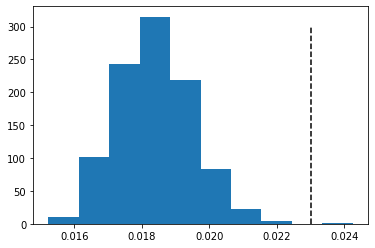

In [209]:
# Average over 9 animals 
plt.hist(ex_bootstrap.mean(axis=0))
plt.vlines(x=ex_means.mean(), ymin=0, ymax=300,color='k', linestyles='--')

In [210]:
ex_bootstrap.mean(axis=0).mean(),ex_bootstrap.mean(axis=0).std()

(0.018381125553511873, 0.0011097524909542958)

In [211]:
ex_means.shape, ex_bootstrap[0].shape

((9,), (1000,))

### Bootstrap p value

In [212]:
exbstp=[]
for bstp, val in zip(ex_bootstrap, ex_means):
    exbstp.append((bstp > val).sum())

In [213]:
(np.array(exbstp) / 1000.).mean()

0.18788888888888888

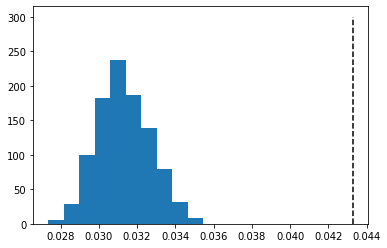

In [214]:
# Average over 9 animals 
plt.hist(last_bootstrap.mean(axis=0))
plt.vlines(x=last_means.mean(), ymin=0, ymax=300,color='k', linestyles='--')

In [215]:
last_bootstrap.mean(axis=0).mean(),last_bootstrap.mean(axis=0).std()

(0.03130233766386252, 0.0013744007015638626)

In [216]:
ltbstp=[]
for bstp, val in zip(last_bootstrap, last_means):
    ltbstp.append((bstp > val).sum())

In [217]:
(np.array(ltbstp) / 1000.).mean()

0.12388888888888888

## For CS sessions

In [174]:
#ROI Data to Load for CS Sessions
aDays = [5]
aSess = [1]
rD = [9]
rS = [1]
#Ali Mice
aBase = '/home/hanlabadmins/eng_handata_2/Kyle_Hansen/AliEyeBlink/'
aMice, aDay, aSess = ([24], [5], [1,2])
aFolders, aFilenames = makeAliFilenames(aMice, aDay, aSess)
aFiles = combineFilenames(aBase, aFolders, aFilenames)
#Rebecca Mice
rB = '/home/hanlabadmins/eng_handata_2/eng_research_handata2/Kyle_Hansen/TonePuff-Rebecca/'
rM, rD, rS = ([2982, 4540], [9], [1])
rFds, rFls = makeRebeccaFilenames(rM, rD, rS)
rFil = combineFilenames(rB, rFds, rFls)

In [175]:
def arrayToDataFrame(arr, higherLevel=None):
    #Convert (cells, rows, cols) to a MultiIndex DataFrame by looping through
    out_list = []
    Ncells, r, c = arr.shape
    for cellID, frame in enumerate(arr):
        if higherLevel != None:
            mIdx = pd.MultiIndex.from_product([[higherLevel],[cellID],range(c)], names=['mouse','cell_num','pixel_num'])
        else:
            mIdx = pd.MultiIndex.from_product([[cellID],range(c)], names=['cell_num', 'pixel_num'])
        out_list.append(pd.DataFrame(data=frame, index=range(r), columns=mIdx))
    return pd.concat(out_list, axis=1)

In [176]:
def loadSelROIs(files):
    #Loop through files and load ROI maps from inputted data
    #For Saving Output as Big DataFrames (Commented Out because too memory intensive)
    roiArrays=[]
    roiColors = []   
    for idx, f in enumerate(files):
        name = f.split('/')[-2]
        print('Loading ROIs for {}'.format(name))
        #Load ROI Masks
        f_open = h5py.File(f, 'r')
        cur_roi = np.array(f_open['/rois/ROImasks'])
        #Convert ROIs to DataFrames
        cur_roi_df = arrayToDataFrame(cur_roi, higherLevel=name)
        roiArrays.append(cur_roi_df)
        #Load Saved Color Array
        Ncells = cur_roi.shape[0]
        cIdx = pd.MultiIndex.from_product([[name],range(Ncells)])
        cur_color_df = pd.DataFrame(data=np.array(f_open['color']).T, columns=cIdx)
        roiColors.append(cur_color_df)
    colorOut = pd.concat(roiColors, axis=1)
    
    return colorOut, roiArrays

In [177]:
aC, aR = loadSelROIs(aFiles)

Loading ROIs for ali24_d5_s1
Loading ROIs for ali24_d5_s2


In [168]:
rC, rR = loadSelROIs(rFil)

Loading ROIs for 2982_d9_s1
Loading ROIs for 4540_d9_s1


In [169]:
def create_circular_mask(h, w, center=None, radius=None):
    #Code from https://stackoverflow.com/questions/44865023/circular-masking-an-image-in-python-using-numpy-arrays
    
    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [164]:
# From the event detection final notebook
firstf="Active_Cells_ali24.h5"
f = h5py.File(firstf, 'r')
print(f.keys())
ali24_Last_Inc_Cells=np.array(f['CS_cells'])
ali24_Ext_Inc_Cells =np.array(f['EX_cells'])

<KeysViewHDF5 ['CS_cells', 'EX_cells']>


In [165]:
#Calcualte Null Distribution of Cells
ali24_Last_Inc_Cells
n_pixel_radius = 76 #Roughly Corresponds to 100 microns.  100 microns / 1.312 microns/pixel
ms = 'ali24'
s = '_d5_s1'
rInd = 0
sel_cells = aR[rInd].columns.unique('cell_num')
N = sel_cells.shape[0]
n_cells = np.zeros(sel_cells.shape) #Multiply by -1 so adding cell itself in loop means 0 cells overlap with it
n_CS = np.zeros(sel_cells.shape)
lC = eval(ms+'_Last_Inc_Cells') #Get Comparison
for c_idx, c in enumerate(sel_cells):
    if c_idx % 5 == 0:
        print(c_idx)
    cur_im = aR[rInd][ms+s, c].values
    c_y, c_x = ndimage.measurements.center_of_mass(cur_im)
    mask = create_circular_mask(cur_im.shape[1], cur_im.shape[0], center=[c_x, c_y], radius=n_pixel_radius)
    allMasks = np.tile(mask,N)
    combMasks = aR[rInd][ms+s] + allMasks
    overlapCells = combMasks.groupby(level='cell_num',axis=1).max().max()
    overlapIDs = overlapCells.index[overlapCells==2]
    if np.in1d(c, overlapIDs)[0]:
        n_CS[c_idx] = np.in1d(lC, overlapIDs).sum() - 1 #Subtract 1 for itself
    n_cells[c_idx] = overlapIDs.shape[0] - 1 #Subtract 1 for iteslf
    #for n_c in sel_cells: #Loop through again to compare to mask
    #    n_im = aR[rInd][ms+s, n_c].values
    #    comb_im = n_im+mask
    #    if comb_im.max() == 2: #If cell overlaps with additional cell
    #        n_cells[c_idx] += 1
    

#eC = eval(ms+'_Ext_Inc_Cells')

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450


In [166]:
n_CS.shape

(453,)

In [172]:
aliMatchedIDs, aliMatchIndsA = matchCells(aliFiles, aliTraces)

ali24_d2_s1
ali24_d5_s1
ali24_d5_s2
ali25_d2_s1
ali25_d5_s1
ali25_d5_s2
ali26_d2_s1
ali26_d5_s1
ali26_d5_s2


In [179]:
def matchCellMap(rois, match_df):
    #Function to compare match values in a dataframe and output only those matched in appropriate sessions
    mice = rois.columns.unique('mouse')
    pixel_num = rois.columns.unique('pixel_num')
    matchedInds=[]
    for mouse in mice:
        print(mouse)
        if ('d5' in mouse): #If a d5 Session with Matching
            match_sess = match_df[mouse].dropna()
            if ('s1' in mouse):
                search_col = 'firstExtinction'
                sel_col = 'lastTraining'
            elif ('s2' in mouse):
                search_col = 'lastTraining'
                sel_col = 'firstExtinction'
            sel_inds = (match_sess.loc[(match_sess[search_col] != -1), sel_col] - 1).values.astype(int)
            roi_sess = rois[mouse]
            #print(sel_inds)
            out_sess = roi_sess.loc[:,sel_inds]
            mIdx = pd.MultiIndex.from_product([[mouse],range(sel_inds.shape[0]),pixel_num], names=['mouse','cell_num','pixel_num'])
            out_sess.columns = mIdx
            matchedInds.append(out_sess)
        else: #No d5 Session with Matching
            noChange = rois[mouse]
            noChange.columns = pd.MultiIndex.from_product([[mouse],noChange.columns], names=['mouse','cell_num','pixel_num'])
            matchedInds.append(noChange)
    return pd.concat(matchedInds, axis=1)

In [180]:
 #Load ROIs of interest

roiArrayDF = pd.concat(aR,axis=1)
print(roiArrayDF.columns.unique('mouse'))
    
#Match ROI Arrays
aliMatchROIs = matchCellMap(roiArrayDF, aliMatchInds)

Index(['ali24_d5_s1', 'ali24_d5_s2'], dtype='object', name='mouse')
ali24_d5_s1
ali24_d5_s2


In [171]:
def calculateCellDistributions(roiArray, lastCellInds, extCellInds, last_mouse_in, ext_mouse_in, n_pixel_radius):
    lastROIs = roiArray[last_mouse_in]
    extROIs = roiArray[ext_mouse_in]
    sel_cells = roiArray.columns.unique('cell_num')
    N = sel_cells.shape[0]
    n_cells = np.zeros(sel_cells.shape) #Multiply by -1 so adding cell itself in loop means 0 cells overlap with it
    last_n_type = np.zeros(sel_cells.shape)
    ext_n_type = np.zeros(sel_cells.shape)
    overlapDict = dict() #Empty Dictionary to track Overlapping Cells
    for c_idx, c in enumerate(sel_cells):
        if c_idx % 5 == 0:
            print(c_idx)
        cur_im = roiArray[last_mouse_in, c].values
        c_y, c_x = ndimage.measurements.center_of_mass(cur_im)
        mask = create_circular_mask(cur_im.shape[1], cur_im.shape[0], center=[c_x, c_y], radius=n_pixel_radius)
        allMasks = np.tile(mask,N)
        combMasks = roiArray[last_mouse_in] + allMasks
        overlapCells = combMasks.groupby(level='cell_num',axis=1).max().max()
        overlapIDs = overlapCells.index[overlapCells==2]
        overlapDict[c] = overlapIDs.values
        if np.in1d(c, lastCellInds)[0]:
            last_n_type[c_idx] = np.intersect1d(lastCellInds, overlapIDs).shape[0] #Subtract 1 for itself after the fact.  Keep to know how many cells were found
        if np.in1d(c, extCellInds)[0]:
            ext_n_type[c_idx] = np.intersect1d(extCellInds, overlapIDs).shape[0] #Subtract 1 for itself after the fact.  Keep to know how many cells were found
        n_cells[c_idx] = overlapIDs.shape[0] - 1 #Subtract 1 for iteslf
    
    return n_cells, overlapDict, last_n_type, ext_n_type


In [171]:
#Calculate Cell Distributions
n_cells, overlapDict, last_n_type, ext_n_type = calculateCellDistributions(aliMatchROIs, ali24_Last_Inc_Cells,ali24_Ext_Inc_Cells, 'ali24_d5_s1','ali24_d5_s2', 76)
#np.savez('ali24_d5_s1_AllSpatialCalculations.npz', n_cells=n_cells, overlapDict=overlapDict, last_n_type=last_n_type, ext_n_type=ext_n_type)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300


In [172]:
np.savez('ali24_d5_s1_AllSpatialCalculations.npz', n_cells=n_cells, overlapDict=overlapDict, last_n_type=last_n_type, ext_n_type=ext_n_type)

###  Ali 25 spatial calculations

In [173]:
#ROI Data to Load for CS Sessions
aDays = [5]
aSess = [1]
rD = [9]
rS = [1]
#Ali Mice
aBase = '/mnt/eng_handata/Kyle_Hansen/AliEyeBlink/'
aMice, aDay, aSess = ([25], [5], [1,2])
aFolders, aFilenames = makeAliFilenames(aMice, aDay, aSess)
aFiles = combineFilenames(aBase, aFolders, aFilenames)
aC, aR = loadSelROIs(aFiles)

Loading ROIs for ali25_d5_s1
Loading ROIs for ali25_d5_s2


In [174]:
 #Load ROIs of interest

roiArrayDF = pd.concat(aR,axis=1)
print(roiArrayDF.columns.unique('mouse'))
    
#Match ROI Arrays
aliMatchROIs = matchCellMap(roiArrayDF, aliMatchInds)

Index(['ali25_d5_s1', 'ali25_d5_s2'], dtype='object', name='mouse')
ali25_d5_s1
ali25_d5_s2


In [175]:
# From the event detection final notebook
firstf="Active_Cells_ali25.h5"
f = h5py.File(firstf, 'r')
print(f.keys())
ali25_Last_Inc_Cells=np.array(f['CS_cells'])
ali25_Ext_Inc_Cells =np.array(f['EX_cells'])

<KeysViewHDF5 ['CS_cells', 'EX_cells']>


In [176]:
#Calculate Cell Distributions
n_cells, overlapDict, last_n_type, ext_n_type = calculateCellDistributions(aliMatchROIs, ali25_Last_Inc_Cells,ali25_Ext_Inc_Cells, 'ali25_d5_s1','ali25_d5_s2', 76)
np.savez('ali25_d5_s1_AllSpatialCalculations.npz', n_cells=n_cells, overlapDict=overlapDict, last_n_type=last_n_type, ext_n_type=ext_n_type)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130


### Ali 26 spatial calculations

In [172]:
#ROI Data to Load for CS Sessions
aDays = [5]
aSess = [1]

aBase = '/mnt/eng_handata/Kyle_Hansen/AliEyeBlink/'
aMice, aDay, aSess = ([26], [5], [1,2])
aFolders, aFilenames = makeAliFilenames(aMice, aDay, aSess)
aFiles = combineFilenames(aBase, aFolders, aFilenames)
aC, aR = loadSelROIs(aFiles)

Loading ROIs for ali26_d5_s1
Loading ROIs for ali26_d5_s2


In [173]:
#Load ROIs of interest

roiArrayDF = pd.concat(aR,axis=1)
print(roiArrayDF.columns.unique('mouse'))
    
#Match ROI Arrays
aliMatchROIs = matchCellMap(roiArrayDF, aliMatchInds)

Index(['ali26_d5_s1', 'ali26_d5_s2'], dtype='object', name='mouse')
ali26_d5_s1
ali26_d5_s2


In [174]:
# From the event detection final notebook
firstf="Active_Cells_ali26.h5"
f = h5py.File(firstf, 'r')
print(f.keys())
ali26_Last_Inc_Cells=np.array(f['CS_cells'])
ali26_Ext_Inc_Cells =np.array(f['EX_cells'])

<KeysViewHDF5 ['CS_cells', 'EX_cells']>


In [175]:
#Calculate Cell Distributions
n_cells, overlapDict, last_n_type, ext_n_type = calculateCellDistributions(aliMatchROIs, ali26_Last_Inc_Cells,ali26_Ext_Inc_Cells, 'ali26_d5_s1','ali26_d5_s2', 76)
np.savez('ali26_d5_s1_AllSpatialCalculations.npz', n_cells=n_cells, overlapDict=overlapDict, last_n_type=last_n_type, ext_n_type=ext_n_type)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415


### 2982- Spatial calculations 

In [176]:
#ROI Data to Load for CS Sessions
rD = [9]
rS = [1]
#Rebecca Mice
rB = '/mnt/eng_handata/eng_research_handata2/Kyle_Hansen/TonePuff-Rebecca/'
rM, rD, rS = ([2982, 4540], [9], [1])
rFds, rFls = makeRebeccaFilenames(rM, rD, rS)
rFil = combineFilenames(rB, rFds, rFls)

In [177]:
rFil

['/mnt/eng_handata/eng_research_handata2/Kyle_Hansen/TonePuff-Rebecca/2982/2982_d9_s1/trace_kyleFinal_BinaryVideo.hdf5',
 '/mnt/eng_handata/eng_research_handata2/Kyle_Hansen/TonePuff-Rebecca/4540/4540_d9_s1/trace_kyleFinal_BinaryVideo.hdf5']

In [178]:
#Load ROIs of interest
clrs, roiArrays = loadSelROIs([rFil[0]])
roiArrayDF = pd.concat(roiArrays,axis=1)
print(roiArrayDF.columns.unique('mouse'))

Loading ROIs for 2982_d9_s1
Index(['2982_d9_s1'], dtype='object', name='mouse')


In [179]:
# From the event detection final notebook
firstf="Active_Cells_2982.h5"
f = h5py.File(firstf, 'r')
print(f.keys())
r2982_Last_Inc_Cells=np.array(f['CS_cells'])
r2982_Ext_Inc_Cells =np.array(f['EX_cells'])

<KeysViewHDF5 ['CS_cells', 'EX_cells']>


In [180]:
n_cells, overlapDict, last_n_type, ext_n_type = calculateCellDistributions(roiArrayDF,r2982_Last_Inc_Cells,r2982_Ext_Inc_Cells,'2982_d9_s1','2982_d9_s1',76)
np.savez('2982_d9_s1_AllSpatialCalculations.npz', n_cells=n_cells, overlapDict=overlapDict, last_n_type=last_n_type, ext_n_type=ext_n_type)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305


### 4540 Spatial calculations 

In [181]:
#Load ROIs of interest
clrs, roiArrays = loadSelROIs([rFil[1]])
roiArrayDF = pd.concat(roiArrays,axis=1)
print(roiArrayDF.columns.unique('mouse'))

Loading ROIs for 4540_d9_s1
Index(['4540_d9_s1'], dtype='object', name='mouse')


In [182]:
# From the event detection final notebook
firstf="Active_Cells_4540.h5"
f = h5py.File(firstf, 'r')
print(f.keys())
r4540_Last_Inc_Cells=np.array(f['CS_cells'])
r4540_Ext_Inc_Cells =np.array(f['EX_cells'])

<KeysViewHDF5 ['CS_cells', 'EX_cells']>


In [183]:
n_cells, overlapDict, last_n_type, ext_n_type = calculateCellDistributions(roiArrayDF,r4540_Last_Inc_Cells,r4540_Ext_Inc_Cells,'4540_d9_s1','4540_d9_s1',76)
np.savez('4540_d9_s1_AllSpatialCalculations.npz', n_cells=n_cells, overlapDict=overlapDict, last_n_type=last_n_type, ext_n_type=ext_n_type)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265


### 2712 Spatial Calculations 

In [184]:
#ROI Data to Load for CS Sessions
nrD = [5]
nrS = [1]
#Rebecca Mice
nrB = '/mnt/eng_handata/eng_research_handata2/Kyle_Hansen/TonePuff_Rebecca2/'
nrM, nrD, nrS = ([2712,2713,2714,8089], [5], [1])
nrFds, nrFls = makeRebeccaFilenames(nrM, nrD, nrS)
nrFil = combineFilenames(nrB, nrFds, nrFls)

In [185]:
#Load ROIs of interest
clrs, roiArrays = loadSelROIs([nrFil[0]])
roiArrayDF = pd.concat(roiArrays,axis=1)
print(roiArrayDF.columns.unique('mouse'))

Loading ROIs for 2712_d5_s1
Index(['2712_d5_s1'], dtype='object', name='mouse')


In [186]:
# From the event detection final notebook
firstf="Active_Cells_2712.h5"
f = h5py.File(firstf, 'r')
print(f.keys())
nr2712_Last_Inc_Cells=np.array(f['CS_cells'])
nr2712_Ext_Inc_Cells =np.array(f['EX_cells'])

<KeysViewHDF5 ['CS_cells', 'EX_cells']>


In [187]:
n_cells, overlapDict, last_n_type, ext_n_type = calculateCellDistributions(roiArrayDF,nr2712_Last_Inc_Cells,nr2712_Ext_Inc_Cells,'2712_d5_s1','2712_d5_s1',76)
np.savez('2712_d5_s1_AllSpatialCalculations.npz', n_cells=n_cells, overlapDict=overlapDict, last_n_type=last_n_type, ext_n_type=ext_n_type)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125


### 2713 Spatial calculations

In [188]:
#Load ROIs of interest
clrs, roiArrays = loadSelROIs([nrFil[1]])
roiArrayDF = pd.concat(roiArrays,axis=1)
print(roiArrayDF.columns.unique('mouse'))

Loading ROIs for 2713_d5_s1
Index(['2713_d5_s1'], dtype='object', name='mouse')


In [189]:
# From the event detection final notebook
firstf="Active_Cells_2713.h5"
f = h5py.File(firstf, 'r')
print(f.keys())
nr2713_Last_Inc_Cells=np.array(f['CS_cells'])
nr2713_Ext_Inc_Cells =np.array(f['EX_cells'])

<KeysViewHDF5 ['CS_cells', 'EX_cells']>


In [190]:
n_cells, overlapDict, last_n_type, ext_n_type = calculateCellDistributions(roiArrayDF,nr2713_Last_Inc_Cells,nr2713_Ext_Inc_Cells,'2713_d5_s1','2713_d5_s1',76)
np.savez('2713_d5_s1_AllSpatialCalculations.npz', n_cells=n_cells, overlapDict=overlapDict, last_n_type=last_n_type, ext_n_type=ext_n_type)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140


### 2714 Spatial Calculations 

In [191]:
#Load ROIs of interest
clrs, roiArrays = loadSelROIs([nrFil[2]])
roiArrayDF = pd.concat(roiArrays,axis=1)
print(roiArrayDF.columns.unique('mouse'))

Loading ROIs for 2714_d5_s1
Index(['2714_d5_s1'], dtype='object', name='mouse')


In [192]:
# From the event detection final notebook
firstf="Active_Cells_2714.h5"
f = h5py.File(firstf, 'r')
print(f.keys())
nr2714_Last_Inc_Cells=np.array(f['CS_cells'])
nr2714_Ext_Inc_Cells =np.array(f['EX_cells'])

<KeysViewHDF5 ['CS_cells', 'EX_cells']>


In [193]:
n_cells, overlapDict, last_n_type, ext_n_type = calculateCellDistributions(roiArrayDF,nr2714_Last_Inc_Cells,nr2714_Ext_Inc_Cells,'2714_d5_s1','2714_d5_s1',76)
np.savez('2714_d5_s1_AllSpatialCalculations.npz', n_cells=n_cells, overlapDict=overlapDict, last_n_type=last_n_type, ext_n_type=ext_n_type)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150


### 8089 Spatial Calculations 

In [194]:
#Load ROIs of interest
clrs, roiArrays = loadSelROIs([nrFil[3]])
roiArrayDF = pd.concat(roiArrays,axis=1)
print(roiArrayDF.columns.unique('mouse'))

Loading ROIs for 8089_d5_s1
Index(['8089_d5_s1'], dtype='object', name='mouse')


In [195]:
# From the event detection final notebook
firstf="Active_Cells_8089.h5"
f = h5py.File(firstf, 'r')
print(f.keys())
nr8089_Last_Inc_Cells=np.array(f['CS_cells'])
nr8089_Ext_Inc_Cells =np.array(f['EX_cells'])

<KeysViewHDF5 ['CS_cells', 'EX_cells']>


In [196]:
n_cells, overlapDict, last_n_type, ext_n_type = calculateCellDistributions(roiArrayDF,nr8089_Last_Inc_Cells,nr8089_Ext_Inc_Cells,'8089_d5_s1','8089_d5_s1',76)
np.savez('8089_d5_s1_AllSpatialCalculations.npz', n_cells=n_cells, overlapDict=overlapDict, last_n_type=last_n_type, ext_n_type=ext_n_type)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70


### Calculate averages 

In [181]:
def calcSliceAverages(block_df, mice):
    #Take MultiIndex DataFrame and average traces first few trials and last remaining trials independently
    #Assume MultiIndex is (mouse, trials, cells)
    #Fixed Parameters
    Nfirst = 20
    #Dynamic Parameters
    Nmice = mice.shape[0] / 3
    Nplots = mice.shape[0] + Nmice*2
    #Loop Through and Generate Plots
    all_dfs=[]
    new_mice=[]
    for name in mice:
        if ('d1' in name) or ('d5' in name) or ('d9' in name):
            Ntrials = block_df[name].columns.get_level_values('trial').max()+1
            #Average for First Set of Trials
            first_df = block_df[name].loc[:, block_df[name].columns.get_level_values('trial').isin(range(Nfirst))]
            mean_first = first_df.groupby(level=['cell_num'], axis=1).mean()
            first_name = name + '_first{}'.format(Nfirst)
            mean_first.columns = pd.MultiIndex.from_product([[first_name], mean_first.columns], names=['mouse','cell_num'])
            all_dfs.append(mean_first)
            new_mice.append(first_name)
            #Average for Remaining Trials
            last_df = block_df[name].loc[:, block_df[name].columns.get_level_values('trial').isin(range(Nfirst,Ntrials))]
            mean_last = last_df.groupby(level=['cell_num'], axis=1).mean()
            last_name = name + '_last{}'.format(Ntrials-Nfirst)
            mean_last.columns = pd.MultiIndex.from_product([[last_name], mean_last.columns], names=['mouse','cell_num'])
            all_dfs.append(mean_last)
            new_mice.append(last_name)
        else:
            full_df = block_df[name].groupby(level=['cell_num'], axis=1).mean()
            full_df.columns = pd.MultiIndex.from_product([[name], full_df.columns], names=['mouse', 'cell_num'])
            all_dfs.append(full_df)
            new_mice.append(name)
    split_blocks_df = pd.concat(all_dfs, axis=1)
    new_mice_Idx = pd.Index(new_mice)
    return split_blocks_df, new_mice_Idx

In [182]:
def calcSliceAverages_ali(block_df, mice):
    #Take MultiIndex DataFrame and average traces first few trials and last remaining trials independently
    #Assume MultiIndex is (mouse, trials, cells)
    #Fixed Parameters
    
    #Dynamic Parameters
    Nmice = mice.shape[0] / 3
    Nplots = mice.shape[0] + Nmice*2
    #Loop Through and Generate Plots
    all_dfs=[]
    new_mice=[]
    for name in mice:
        if ('s1' in name ):
            Nfirst=20
            Ntrials = block_df[name].columns.get_level_values('trial').max()+1
            #Average for First Set of Trials
            first_df = block_df[name].loc[:, block_df[name].columns.get_level_values('trial').isin(range(Nfirst,Ntrials))]
            mean_first = first_df.groupby(level=['cell_num'], axis=1).mean()
            first_name = name + '_last{}'.format(Nfirst)
            mean_first.columns = pd.MultiIndex.from_product([[first_name], mean_first.columns], names=['mouse','cell_num'])
            all_dfs.append(mean_first)
            new_mice.append(first_name)
            
        else:
            Nfirst =40
            Ntrials = block_df[name].columns.get_level_values('trial').max()+1
            #Average for First Set of Trials
            first_df = block_df[name].loc[:, block_df[name].columns.get_level_values('trial').isin(range(Nfirst))]
            mean_first = first_df.groupby(level=['cell_num'], axis=1).mean()
            first_name = name + '_first{}'.format(Nfirst)
            mean_first.columns = pd.MultiIndex.from_product([[first_name], mean_first.columns], names=['mouse','cell_num'])
            all_dfs.append(mean_first)
            new_mice.append(first_name)
            
    split_blocks_df = pd.concat(all_dfs, axis=1)
    new_mice_Idx = pd.Index(new_mice)
    return split_blocks_df, new_mice_Idx

In [183]:
def makeTrialAveragePlots(block_df, whichData=None):
    #Generage Averaged & Sorted Plots For All Cells in MultiIndex DataFrame
    #Fixed Plot Parameters
    maxWidth = 2.
    cmax = 3
    cmin = -2
    start_ind=40 #40
    end_ind=52 #52
    sort_start=40 #40
    sort_end=52 #80
    #Dynamic Parameters
    mice = block_df.columns.levels[0]
    if whichData == 'Rebecca':
        Nmice = mice.shape[0] / 3
        Nplots = mice.shape[0] + Nmice*2
    elif whichData == 'NewRebecca':
        Nmice = mice.shape[0] / 2
        Nplots = mice.shape[0] + Nmice*2
    elif whichData == 'Ali':
        Nplots = mice.shape[0]
    layoutR, layoutC = [np.ceil(Nplots/maxWidth).astype(int), int(min(Nplots, maxWidth))]
    #Make Plots
    fig, all_ax = plt.subplots(figsize=(9, layoutR*4), nrows=layoutR, ncols=layoutC)
    fig.tight_layout()
    try: #Reshape if only one row of axes indexes
        all_ax.shape[1]
    except:
        all_ax = all_ax.reshape(1,-1)
    #Calculate Average Across Trials if All One Trial Type
    if whichData == 'Rebecca':
        # how to replace '2982_d9_s1 '
        block_averages, mice = calcSliceAverages(block_df, mice)
    elif whichData == 'NewRebecca':
        block_averages, mice = calcSliceAverages(block_df, mice)
    elif whichData == 'Ali':
        block_averages = block_df.groupby(level=['mouse','cell_num'], axis=1).mean()
    step=0
    sorted_inds =[]
    for ax_row in all_ax:
        for sel_ax in ax_row:
            if step == Nplots:
                sel_ax.set_axis_off()
            else:
                print(mice[step])
                cur_block=block_averages[mice[step]]
                sort_inds=np.argsort(cur_block.loc[sort_start:sort_end,:].mean())
                sorted_inds.append(sort_inds)
                cur_sorted = cur_block.loc[:,sort_inds]
                cur_sorted.columns = range(cur_block.shape[1])
                sns.heatmap(cur_sorted.T, ax=sel_ax, vmin=cmin, vmax=cmax, cmap=plt.get_cmap("bwr"))
                sel_ax.axvline(x=start_ind, linestyle='-.', color='k')
                sel_ax.axvline(x=end_ind, linestyle='--', color='k')
                sel_ax.set_xticks(range(0,201,40))
                sel_ax.set_xticklabels(range(-2,9,2), rotation=0)
                sel_ax.set_title(mice[step])
                step+=1
    return block_averages, sorted_inds

In [184]:
def makeTrialAveragePlots_Ali(block_df, whichData=None):
    #Generage Averaged & Sorted Plots For All Cells in MultiIndex DataFrame
    #Fixed Plot Parameters
    maxWidth = 2.
    cmax = 3
    cmin = -2
    start_ind=40 #40
    end_ind=52 #52
    sort_start=40 #40
    sort_end=52 #80
    #Dynamic Parameters
    mice = block_df.columns.levels[0]
    if whichData == 'Rebecca':
        Nmice = mice.shape[0] / 3
        Nplots = mice.shape[0] + Nmice*2
    elif whichData == 'NewRebecca':
        Nmice = mice.shape[0] / 2
        Nplots = mice.shape[0] + Nmice*2
    elif whichData == 'Ali':
        Nplots = mice.shape[0]
    layoutR, layoutC = [np.ceil(Nplots/maxWidth).astype(int), int(min(Nplots, maxWidth))]
    #Make Plots
    fig, all_ax = plt.subplots(figsize=(9, layoutR*4), nrows=layoutR, ncols=layoutC)
    fig.tight_layout()
    try: #Reshape if only one row of axes indexes
        all_ax.shape[1]
    except:
        all_ax = all_ax.reshape(1,-1)
    #Calculate Average Across Trials if All One Trial Type
    if whichData == 'Rebecca':
        # how to replace '2982_d9_s1 '
        block_averages, mice = calcSliceAverages(block_df, mice)
    elif whichData == 'NewRebecca':
        block_averages, mice = calcSliceAverages(block_df, mice)
    elif whichData == 'Ali':
        block_averages,mice = calcSliceAverages_ali(block_df, mice)
    step=0
    sorted_inds =[]
    
    return block_averages

In [185]:
mice = rTraceBlocks.columns.levels[0]
for name in mice:
    print(name)

2982_d1_s1
2982_d2_s1
2982_d9_s1
4540_d1_s1
4540_d2_s1
4540_d9_s1


2712_d1_s1_first20
2712_d1_s1_last40
2712_d5_s1_first20
2712_d5_s1_last40
2713_d1_s1_first20
2713_d1_s1_last40
2713_d5_s1_first20
2713_d5_s1_last40
2714_d1_s1_first20
2714_d1_s1_last40
2714_d5_s1_first20
2714_d5_s1_last40
8089_d1_s1_first20
8089_d1_s1_last40
8089_d5_s1_first20
8089_d5_s1_last40


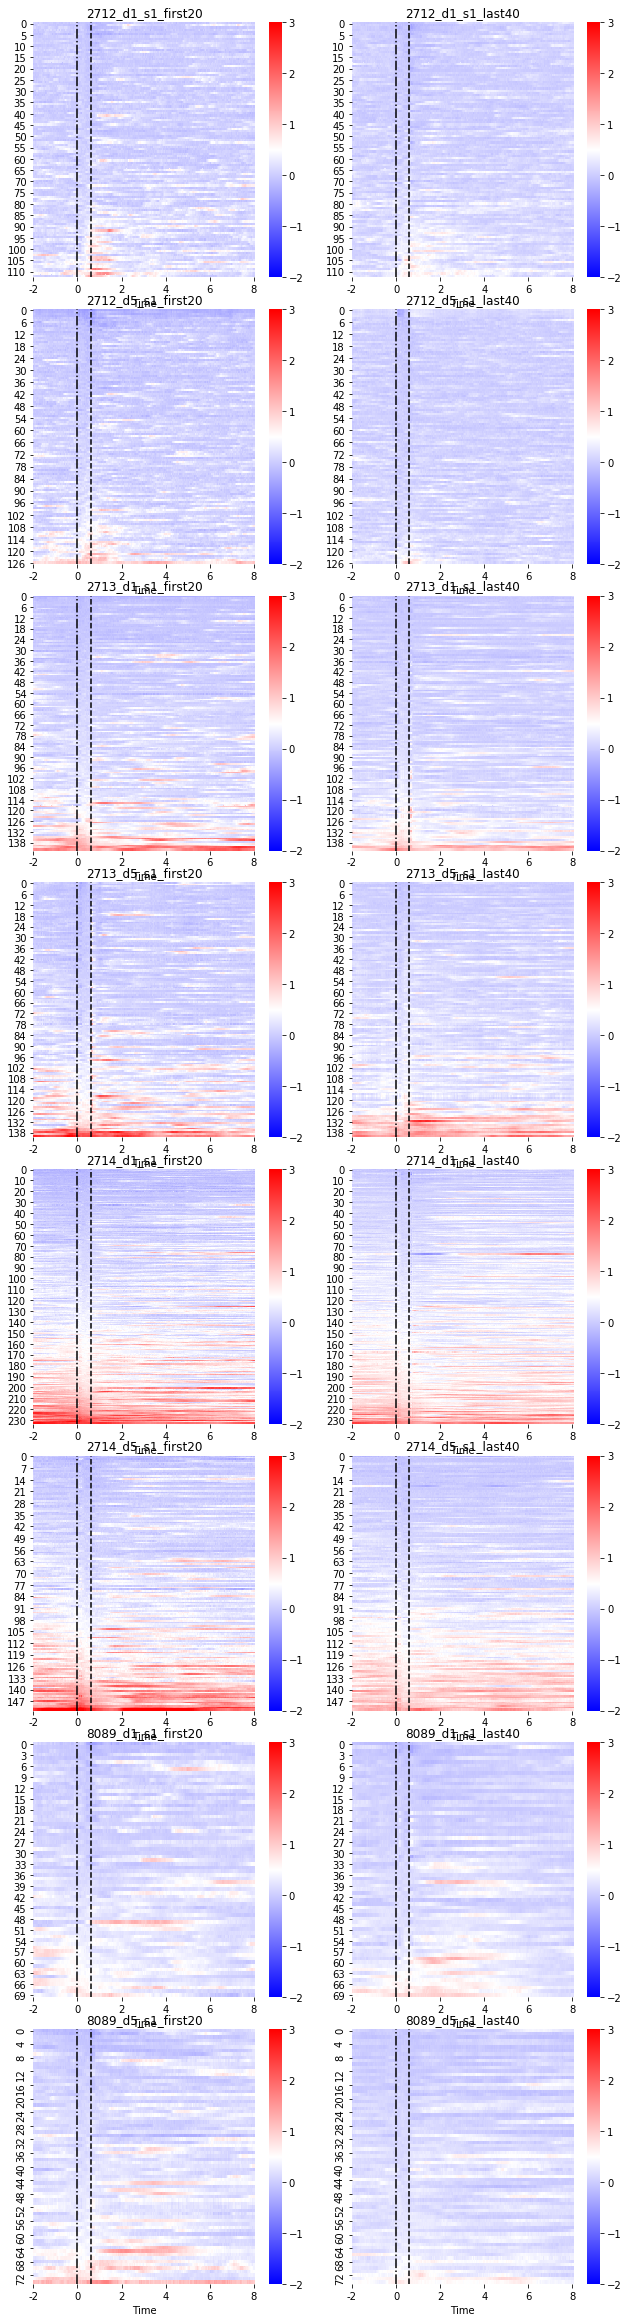

In [186]:
nrBlockAverages, nrSortedInds = makeTrialAveragePlots(nrTraceBlocks, whichData='NewRebecca')

2982_d1_s1_first20
2982_d1_s1_last40
2982_d2_s1
2982_d9_s1_first20
2982_d9_s1_last40
4540_d1_s1_first20
4540_d1_s1_last40
4540_d2_s1
4540_d9_s1_first20
4540_d9_s1_last40


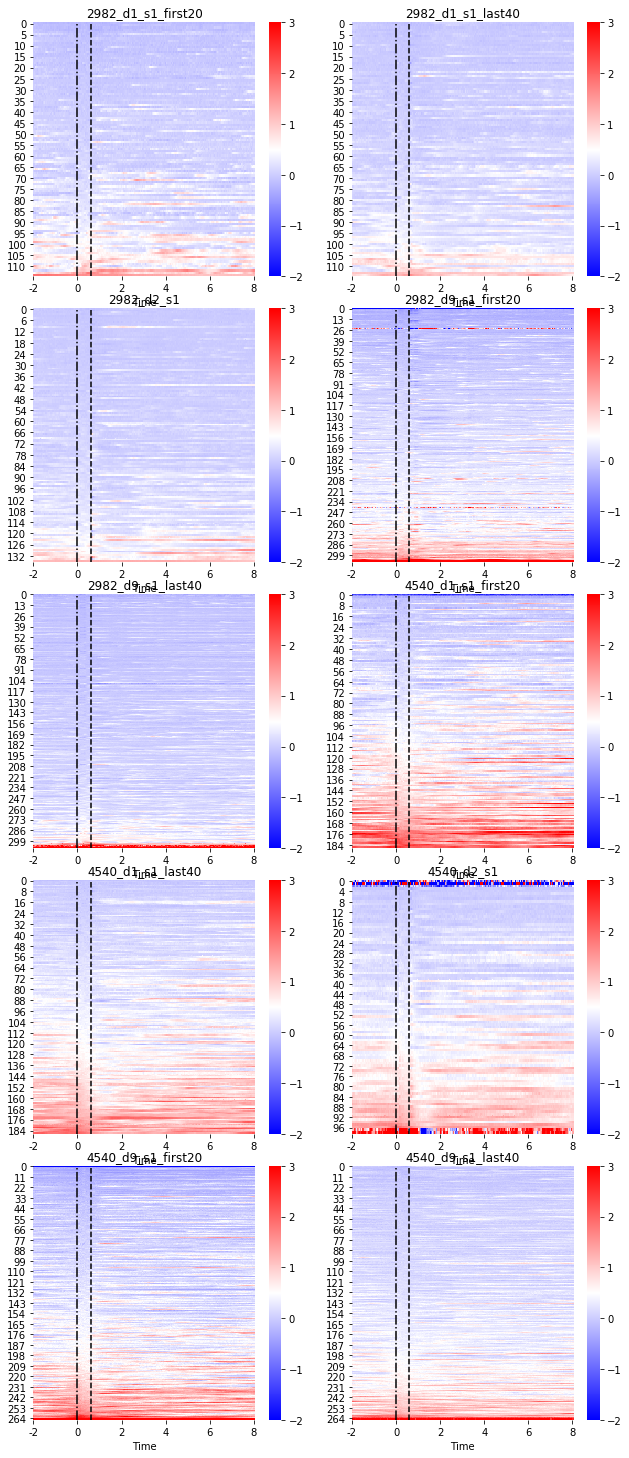

In [187]:
rBlockAverages, rSortedInds = makeTrialAveragePlots(rTraceBlocks, whichData='Rebecca')

ali24_d2_s1
ali24_d5_s1
ali24_d5_s2
ali25_d2_s1
ali25_d5_s1
ali25_d5_s2
ali26_d2_s1
ali26_d5_s1
ali26_d5_s2


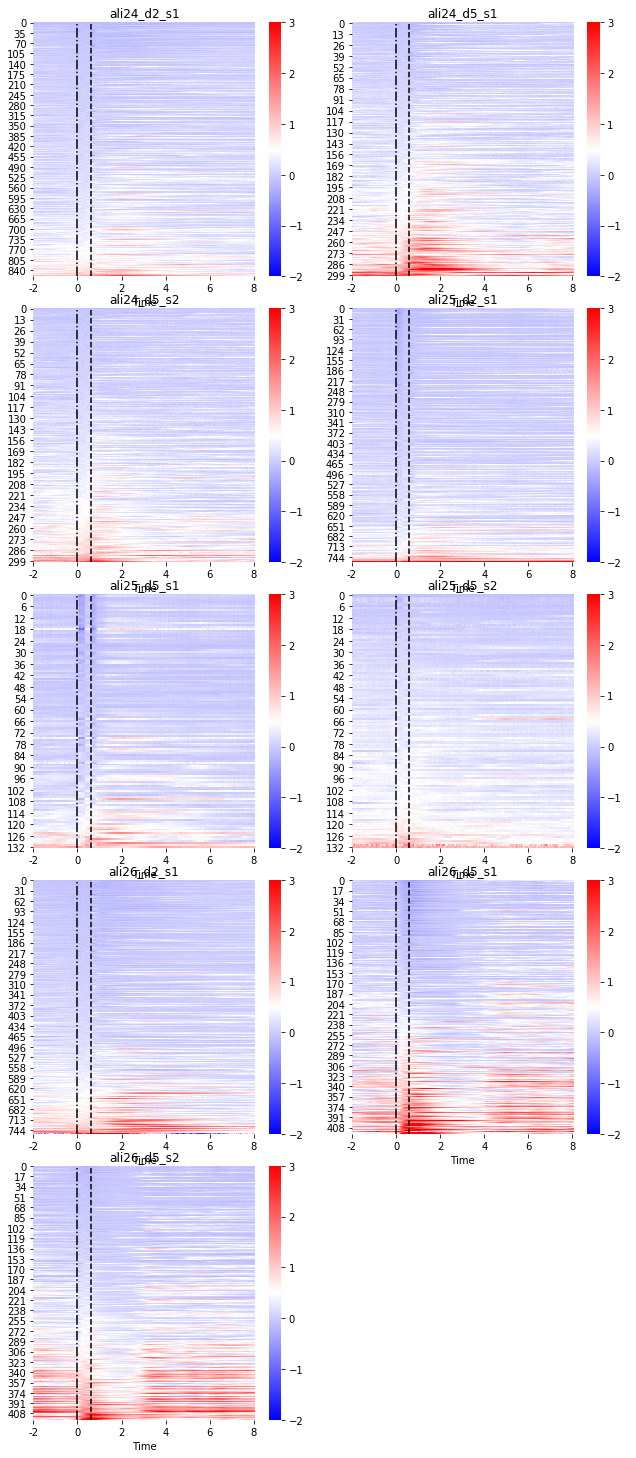

In [188]:
aliBlockAverages, aliSortedInds = makeTrialAveragePlots(aliTraceBlocks, whichData='Ali')

cell_num       0         1         2         3         4         5    \
Time                                                                   
0         0.297539  0.076435  1.387943  0.377777 -0.000622  0.591939   
1         0.235500  0.108736  1.313912  0.354122 -0.000851  0.648423   
2         0.271958  0.102726  1.216146  0.358418  0.100779  0.617119   
3         0.223882  0.071885  1.246579  0.331950 -0.048004  0.659532   
4         0.231049  0.116580  1.200608  0.337322  0.024217  0.747268   
...            ...       ...       ...       ...       ...       ...   
196       0.243293  0.254045  1.192746  0.278130  0.237953  1.212975   
197       0.271481  0.208689  1.099148  0.254601  0.199323  1.259421   
198       0.198164  0.283591  1.100633  0.258777  0.333622  1.203727   
199       0.244911  0.315489  1.080015  0.281877  0.229717  1.311984   
200       0.250674  0.255817  1.009075  0.264789  0.229689  1.106857   

cell_num       6         7         8         9    ...       291       292  \
Time                                              ...                       
0        -0.106899 -0.178340 -0.130173  0.101794  ...  0.105475  0.015888   
1        -0.078472 -0.166131 -0.104319  0.084753  ...  0.169065  0.072220   
2        -0.021408 -0.208410 -0.119869  0.119112  ...  0.117361 -0.028623   
3        -0.105235 -0.163364 -0.088709  0.111877  ...  0.120262 -0.014203   
4        -0.119244 -0.168043 -0.116788  0.101823  ...  0.064162 -0.046433   
...            ...       ...       ...       ...  ...       ...       ...   
196       0.107146 -0.016179 -0.043816  0.416303  ...  0.229090  0.172334   
197       0.160011 -0.075085 -0.140513  0.409388  ...  0.206922  0.192380   
198       0.136179 -0.021760 -0.071643  0.414322  ...  0.299502  0.157275   
199       0.114920 -0.069430 -0.050678  0.370295  ...  0.293554  0.175655   
200       0.054650 -0.041851 -0.078285  0.378114  ...  0.227568  0.176733   

cell_num       293       294       295       296       297       298  \
Time                                                                   
0        -0.059833  0.388262  0.034267  0.013946  0.099824 -0.023731   
1        -0.039456  0.495287 -0.040482 -0.045226  0.041584 -0.007304   
2        -0.065995  0.541271  0.010810 -0.050538  0.048934 -0.013887   
3        -0.064644  0.585479  0.048010 -0.096026  0.086194 -0.115101   
4        -0.102825  0.544434  0.034897 -0.085471  0.098343 -0.130651   
...            ...       ...       ...       ...       ...       ...   
196       0.256056  0.319772  0.006851 -0.034503  0.077837  0.012661   
197       0.215063  0.218759 -0.061814 -0.060469  0.141385 -0.031452   
198       0.243276  0.216048 -0.033078 -0.064240  0.101315 -0.045378   
199       0.241683  0.246302 -0.015135 -0.110423  0.201434 -0.048754   
200       0.239941  0.214945 -0.044987 -0.074513  0.151168  0.024231   

cell_num       299       300  
Time                          
0         0.294366  0.004642  
1         0.256706  0.015118  
2         0.312320  0.044908  
3         0.191767 -0.000866  
4         0.222903 -0.033404  
...            ...       ...  
196       0.074828  0.014539  
197       0.055391 -0.014041  
198       0.066365 -0.012831  
199       0.010360  0.014454  
200       0.046692  0.022268  

[201 rows x 301 columns]

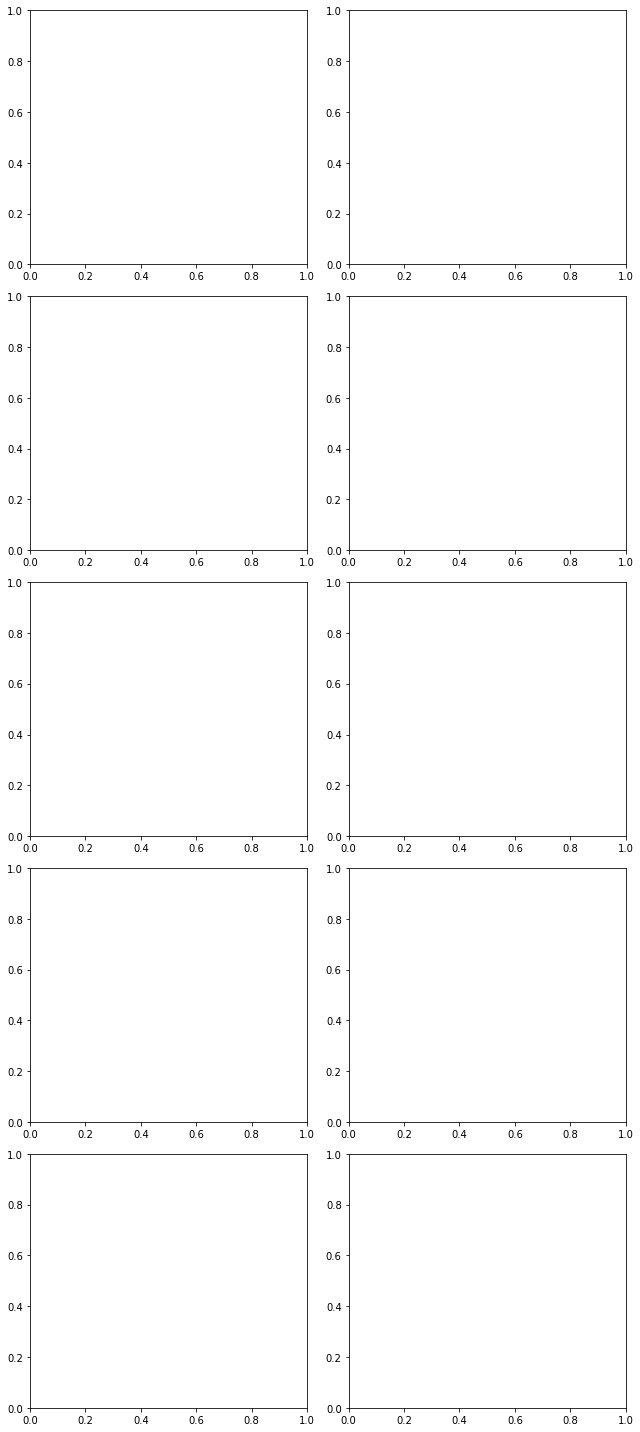

In [189]:
aliBlockAverages_last20 = makeTrialAveragePlots_Ali(aliTraceBlocks, whichData='Ali')
aliBlockAverages_last20['ali24_d5_s1_last20']

## Concatenate all averages across animals - all sessions last day 

In [190]:
concatenated_average= pd.concat([aliBlockAverages_last20['ali24_d5_s1_last20'],aliBlockAverages_last20['ali25_d5_s1_last20'],aliBlockAverages_last20['ali26_d5_s1_last20'],rBlockAverages['2982_d9_s1_first20'],rBlockAverages['4540_d9_s1_first20'],nrBlockAverages['2712_d5_s1_first20'],nrBlockAverages['2713_d5_s1_first20'],nrBlockAverages['2714_d5_s1_first20'],nrBlockAverages['8089_d5_s1_first20']],axis=1)
concatenated_average

cell_num        0         1         2         3         4         5   \
Time                                                                   
0         0.297539  0.076435  1.387943  0.377777 -0.000622  0.591939   
1         0.235500  0.108736  1.313912  0.354122 -0.000851  0.648423   
2         0.271958  0.102726  1.216146  0.358418  0.100779  0.617119   
3         0.223882  0.071885  1.246579  0.331950 -0.048004  0.659532   
4         0.231049  0.116580  1.200608  0.337322  0.024217  0.747268   
...            ...       ...       ...       ...       ...       ...   
196       0.243293  0.254045  1.192746  0.278130  0.237953  1.212975   
197       0.271481  0.208689  1.099148  0.254601  0.199323  1.259421   
198       0.198164  0.283591  1.100633  0.258777  0.333622  1.203727   
199       0.244911  0.315489  1.080015  0.281877  0.229717  1.311984   
200       0.250674  0.255817  1.009075  0.264789  0.229689  1.106857   

cell_num        6         7         8         9   ...        65        66  \
Time                                              ...                       
0        -0.106899 -0.178340 -0.130173  0.101794  ...  0.419431  0.358321   
1        -0.078472 -0.166131 -0.104319  0.084753  ...  0.432758  0.319315   
2        -0.021408 -0.208410 -0.119869  0.119112  ...  0.382202  0.337503   
3        -0.105235 -0.163364 -0.088709  0.111877  ...  0.490627  0.365112   
4        -0.119244 -0.168043 -0.116788  0.101823  ...  0.447092  0.349187   
...            ...       ...       ...       ...  ...       ...       ...   
196       0.107146 -0.016179 -0.043816  0.416303  ...  0.321638  0.531961   
197       0.160011 -0.075085 -0.140513  0.409388  ...  0.430960  0.516277   
198       0.136179 -0.021760 -0.071643  0.414322  ...  0.494026  0.496969   
199       0.114920 -0.069430 -0.050678  0.370295  ...  0.522692  0.438733   
200       0.054650 -0.041851 -0.078285  0.378114  ...  0.481778  0.453105   

cell_num        67        68        69        70        71        72  \
Time                                                                   
0         0.239633  0.005015  0.096042  0.268319  0.213465 -0.003874   
1         0.196059  0.013930  0.138405  0.187647  0.248115  0.023368   
2         0.200119  0.010144  0.083528  0.159379  0.335945  0.069874   
3         0.289628  0.028510  0.108394  0.140361  0.372255  0.119255   
4         0.313023 -0.005274  0.089710  0.174338  0.400569  0.161849   
...            ...       ...       ...       ...       ...       ...   
196       0.380764  0.130324  0.230478  0.334193  0.344786 -0.020447   
197       0.404917  0.112970  0.233603  0.335081  0.364145 -0.041445   
198       0.378155  0.135324  0.219324  0.366564  0.369543 -0.022364   
199       0.297993  0.105983  0.223869  0.288221  0.437348 -0.011651   
200       0.402000  0.112539  0.203423  0.259296  0.404729  0.008321   

cell_num        73        74  
Time                          
0        -0.045422  0.592398  
1        -0.028637  0.585298  
2        -0.020129  0.554925  
3        -0.019407  0.587714  
4         0.007381  0.666703  
...            ...       ...  
196      -0.007510  0.012944  
197       0.008576 -0.002382  
198       0.007839 -0.022523  
199       0.018073  0.030576  
200       0.034132  0.019480  

[201 rows x 1923 columns]

In [191]:
full_gist = cm.get_cmap('gist_stern',256)
topgist_cm = ListedColormap(full_gist(np.linspace(0.25, 1, 256)))

### Supplemental figure - last session all cells 

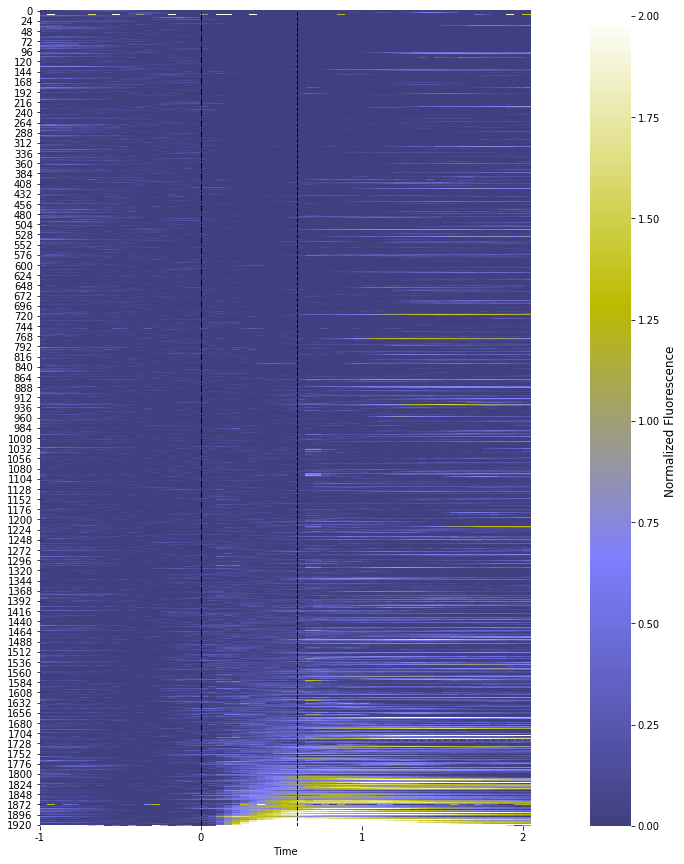

In [192]:
# Plot heatmap 
label_size=12
tick_size=10
title_size=9
start_ind=20 #40
end_ind=32 #52
sort_start=40 #40
sort_end=52 
cmin=0
cmax=2.0
fig, all_ax = plt.subplots(figsize=(11, 15), nrows=1, ncols=1)
cur_block =concatenated_average
bef_interval_mean = cur_block.loc[28:39,:].mean(axis=0)
cur_block=cur_block-bef_interval_mean
#print(cur_block)
sort_inds=np.argsort(cur_block.loc[sort_start:sort_end,:].mean())
cur_sorted = cur_block.iloc[20:81,sort_inds]
cur_sorted.columns = range(cur_block.shape[1])
sns.heatmap(cur_sorted.T,ax=all_ax, vmin=cmin, vmax=cmax,cmap=topgist_cm)
all_ax.axvline(x=start_ind, linestyle='-.', color='k', linewidth=1)
all_ax.axvline(x=end_ind, linestyle='--', color='k', linewidth=1)
all_ax.set_xticks(range(0,61,20))
all_ax.set_xticklabels(range(-1,3,1), rotation=0)
all_ax.tick_params(labelsize=tick_size)

cbar_axes=fig.axes[1]
cbar_axes.tick_params(labelsize=tick_size)
cbar_axes.set_ylabel('Normalized Fluorescence', fontsize=label_size)
cbar_axes.set_position([0.82, 0.125, 0.08, 0.75])
#plt.savefig('concatenated_average_subtracted_last day_-1to2_correct_topgist.png', bbox_inches='tight', format='png', dpi=1400, transparent=True)
plt.savefig('concatenated_average_subtracted_last day_-1to2_correct_topgist.eps', format='eps')

### Supplemental figure- first session across all animals

In [193]:
concatenated_average_first_session= pd.concat([aliBlockAverages['ali24_d2_s1'],aliBlockAverages['ali25_d2_s1'],aliBlockAverages['ali26_d2_s1'],rBlockAverages['2982_d1_s1_last40'],rBlockAverages['4540_d1_s1_last40'],nrBlockAverages['2712_d1_s1_last40'],nrBlockAverages['2713_d1_s1_last40'],nrBlockAverages['2714_d1_s1_last40'],nrBlockAverages['8089_d1_s1_last40']],axis=1)
concatenated_average_first_session

cell_num        0         1         2         3         4         5   \
Time                                                                   
0        -0.094486 -0.113726 -0.092486  0.026099  0.090885  0.119670   
1        -0.096122 -0.112806 -0.090090  0.020956  0.097627  0.119818   
2        -0.096419 -0.103805 -0.085458  0.051449  0.101181  0.109961   
3        -0.105687 -0.094648 -0.085259  0.041040  0.097995  0.123309   
4        -0.089260 -0.084639 -0.070985  0.040503  0.106119  0.115185   
...            ...       ...       ...       ...       ...       ...   
196      -0.131218 -0.127593 -0.123509 -0.125123 -0.088449  0.074268   
197      -0.128792 -0.130599 -0.109590 -0.118143 -0.079683  0.058336   
198      -0.124294 -0.128179 -0.120756 -0.132357 -0.101040  0.072584   
199      -0.130066 -0.145611 -0.105594 -0.135752 -0.087251  0.058362   
200      -0.143760 -0.141795 -0.131800 -0.126399 -0.111939  0.056481   

cell_num        6         7         8         9   ...        60        61  \
Time                                              ...                       
0         0.002345  0.052278  0.060485  0.219277  ...  0.181765  0.149595   
1         0.016620  0.062697  0.058919  0.249292  ...  0.173660  0.129348   
2         0.010481  0.078915  0.050934  0.242580  ...  0.161456  0.152424   
3         0.000990  0.037069  0.065093  0.240062  ...  0.108702  0.127466   
4         0.007096  0.048926  0.055661  0.265519  ...  0.096759  0.117908   
...            ...       ...       ...       ...  ...       ...       ...   
196       0.026191  0.032563 -0.075258  0.318989  ...  0.111766 -0.012000   
197       0.035810  0.013026 -0.052247  0.317797  ...  0.115479 -0.009958   
198       0.029997 -0.022412 -0.079450  0.332209  ...  0.072932  0.009509   
199       0.035409  0.010702 -0.073154  0.336618  ...  0.057938 -0.021355   
200       0.017672  0.015663 -0.076187  0.322901  ...  0.057362  0.002223   

cell_num        62        63        64        65        66        67  \
Time                                                                   
0        -0.024101  0.162429  0.158677  0.405614  0.411464  0.237883   
1        -0.011109  0.198916  0.164988  0.388537  0.402814  0.137191   
2        -0.020787  0.209121  0.174244  0.374342  0.395649  0.191105   
3        -0.044465  0.234117  0.176308  0.380327  0.397229  0.172719   
4        -0.070192  0.156828  0.189737  0.424261  0.424220  0.185771   
...            ...       ...       ...       ...       ...       ...   
196      -0.037040 -0.028790  0.135598  0.117751  0.122849  0.065556   
197      -0.038713 -0.042568  0.115086  0.101579  0.129847  0.053347   
198      -0.026144  0.017560  0.129576  0.087353  0.114401  0.066293   
199      -0.076048 -0.024346  0.111992  0.047157  0.107288 -0.012555   
200      -0.078773 -0.059395  0.108168  0.028883  0.125862 -0.029414   

cell_num        68        69  
Time                          
0         0.407135 -0.003599  
1         0.415557 -0.004457  
2         0.424766 -0.034593  
3         0.434661 -0.001775  
4         0.417151 -0.020847  
...            ...       ...  
196       0.024546  0.082423  
197       0.034513  0.092026  
198       0.054338  0.107242  
199       0.016904  0.067488  
200      -0.004324  0.095401  

[201 rows x 3241 columns]

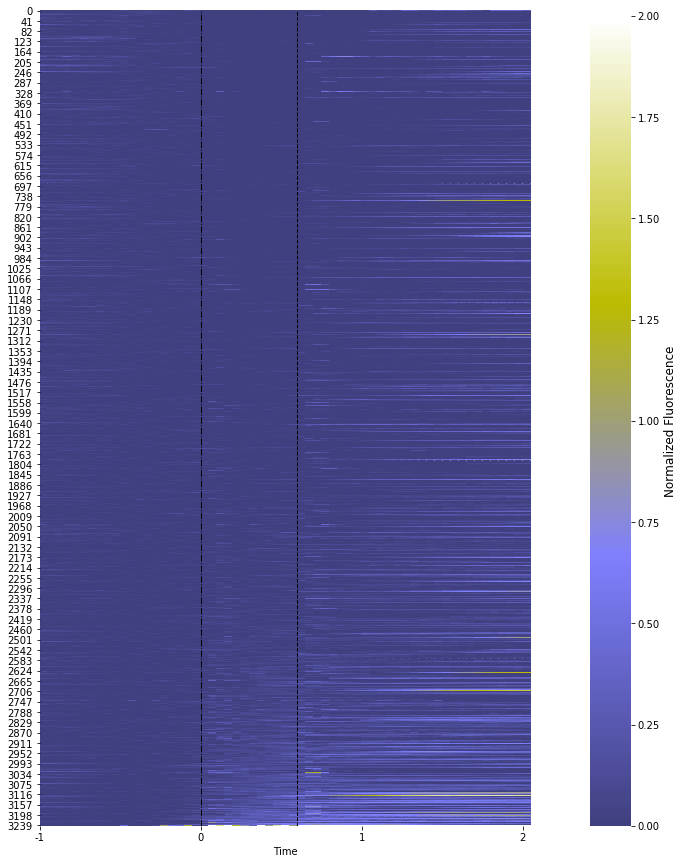

In [194]:
# Plot heatmap 
label_size=12
tick_size=10
title_size=9
start_ind=20 #40
end_ind=32 #52
sort_start=40 #40
sort_end=52 
cmin=0
cmax=2.0
fig, all_ax = plt.subplots(figsize=(11, 15), nrows=1, ncols=1)
cur_block =concatenated_average_first_session
bef_interval_mean = cur_block.loc[28:39,:].mean(axis=0)
cur_block=cur_block-bef_interval_mean
#print(cur_block)
sort_inds=np.argsort(cur_block.loc[sort_start:sort_end,:].mean())
cur_sorted = cur_block.iloc[20:81,sort_inds]
cur_sorted.columns = range(cur_block.shape[1])
sns.heatmap(cur_sorted.T,ax=all_ax, vmin=cmin, vmax=cmax,cmap=topgist_cm)
all_ax.axvline(x=start_ind, linestyle='-.', color='k', linewidth=1)
all_ax.axvline(x=end_ind, linestyle='--', color='k', linewidth=1)
all_ax.set_xticks(range(0,61,20))
all_ax.set_xticklabels(range(-1,3,1), rotation=0)
all_ax.tick_params(labelsize=tick_size)

cbar_axes=fig.axes[1]
cbar_axes.tick_params(labelsize=tick_size)
cbar_axes.set_ylabel('Normalized Fluorescence', fontsize=label_size)
cbar_axes.set_position([0.82, 0.125, 0.08, 0.75])
#plt.savefig('concatenated_average_subtracted_first_day_-1to2_correct_topgist.png', bbox_inches='tight', format='png', dpi=1400, transparent=True)
plt.savefig('concatenated_average_subtracted_first_day_-1to2_correct_topgist.eps',format='eps')

In [195]:
concatenated_average_ext_session= pd.concat([aliBlockAverages['ali24_d5_s2'],aliBlockAverages['ali25_d5_s2'],aliBlockAverages['ali26_d5_s2'],rBlockAverages['2982_d9_s1_last40'],rBlockAverages['4540_d9_s1_last40'],nrBlockAverages['2712_d5_s1_last40'],nrBlockAverages['2713_d5_s1_last40'],nrBlockAverages['2714_d5_s1_last40'],nrBlockAverages['8089_d5_s1_last40']],axis=1)
concatenated_average_ext_session

cell_num        0         1         2         3         4         5   \
Time                                                                   
0         0.263051  0.723090  0.637956  0.112024  0.201835  0.739527   
1         0.225541  0.678277  0.677548  0.096941  0.234506  0.696559   
2         0.267821  0.786342  0.682616  0.095158  0.266776  0.730767   
3         0.257178  0.825921  0.702097  0.093685  0.373230  0.729158   
4         0.257544  0.771765  0.675437  0.091649  0.307967  0.778540   
...            ...       ...       ...       ...       ...       ...   
196       0.134257  0.372627  0.105397 -0.044647  0.035243  0.120377   
197       0.127789  0.385256  0.113889 -0.062132  0.085511  0.131171   
198       0.113520  0.254518  0.151849  0.003201  0.055313  0.084352   
199       0.105201  0.283266  0.123001 -0.036529  0.121045  0.184047   
200       0.163690  0.444711  0.080736 -0.058209  0.149790  0.147463   

cell_num        6         7         8         9   ...        65        66  \
Time                                              ...                       
0         0.090831  0.097715  0.198215 -0.028301  ...  0.139766  0.060842   
1         0.110337  0.085500  0.148376 -0.030370  ...  0.154861  0.103546   
2         0.115945  0.139214  0.146302  0.004122  ...  0.120135  0.079710   
3         0.096886  0.120878  0.195721 -0.047035  ...  0.196016  0.088495   
4         0.086137  0.149624  0.205957 -0.053793  ...  0.176967  0.101479   
...            ...       ...       ...       ...  ...       ...       ...   
196       0.023254 -0.037181  0.087022 -0.060140  ...  0.210432  0.117206   
197       0.008061 -0.056103  0.099008 -0.027978  ...  0.149925  0.108024   
198       0.053460  0.018051  0.113941 -0.020496  ...  0.150657  0.113691   
199       0.051288  0.042972  0.122999  0.014305  ...  0.110525  0.112077   
200       0.049810 -0.003528  0.116084 -0.054083  ...  0.116081  0.135890   

cell_num        67        68        69        70        71        72  \
Time                                                                   
0         0.181375  0.036775  0.054988  0.062356  0.170096  0.257764   
1         0.236201  0.036274  0.040722  0.104710  0.122032  0.264735   
2         0.198234  0.028265  0.074525  0.115197  0.108637  0.229545   
3         0.166805 -0.012324  0.074339  0.157873  0.140053  0.265204   
4         0.158472 -0.006230  0.095543  0.091309  0.074310  0.247765   
...            ...       ...       ...       ...       ...       ...   
196       0.232501  0.087966 -0.023449  0.188773  0.062073  0.018974   
197       0.184603  0.051045 -0.041802  0.232199  0.060821  0.028877   
198       0.191324  0.052095 -0.054970  0.189322  0.050203  0.066413   
199       0.220350  0.068813 -0.050416  0.174139  0.001876  0.027248   
200       0.163505  0.018147 -0.059822  0.200637  0.034332  0.026656   

cell_num        73        74  
Time                          
0         0.116328  0.154398  
1         0.135468  0.161394  
2         0.129445  0.152198  
3         0.129487  0.174819  
4         0.106624  0.154212  
...            ...       ...  
196       0.049003  0.228322  
197       0.056673  0.242085  
198       0.064699  0.253302  
199       0.064449  0.213186  
200       0.055027  0.264851  

[201 rows x 1923 columns]

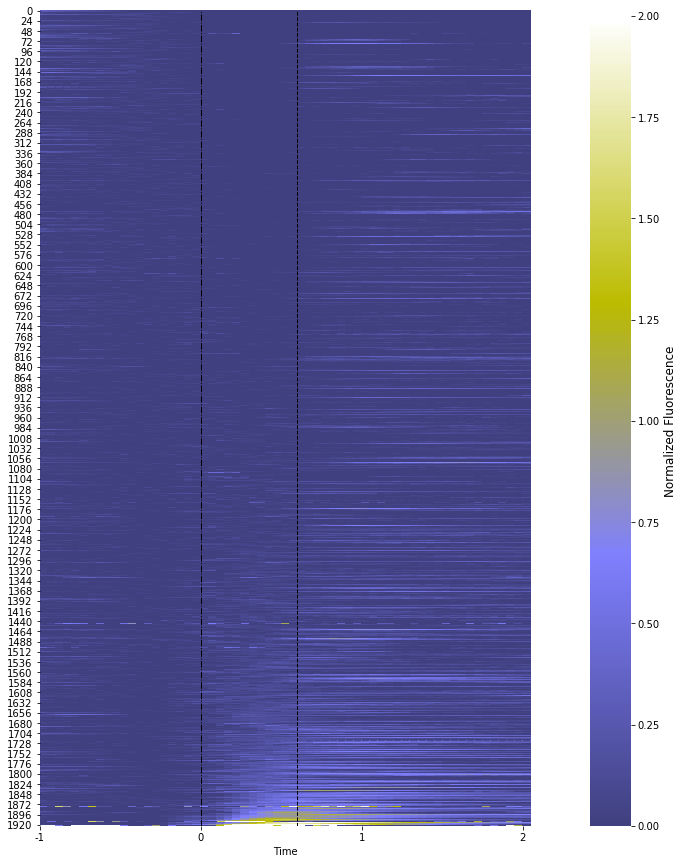

In [196]:
# Plot heatmap 
label_size=12
tick_size=10
title_size=9
start_ind=20 #40
end_ind=32 #52
sort_start=40 #40
sort_end=52 
cmin=0
cmax=2.0
fig, all_ax = plt.subplots(figsize=(11, 15), nrows=1, ncols=1)
cur_block =concatenated_average_ext_session
bef_interval_mean = cur_block.loc[28:39,:].mean(axis=0)
cur_block=cur_block-bef_interval_mean
#print(cur_block)
sort_inds=np.argsort(cur_block.loc[sort_start:sort_end,:].mean())
cur_sorted = cur_block.iloc[20:81,sort_inds]
cur_sorted.columns = range(cur_block.shape[1])
sns.heatmap(cur_sorted.T,ax=all_ax, vmin=cmin, vmax=cmax,cmap=topgist_cm)
all_ax.axvline(x=start_ind, linestyle='-.', color='k', linewidth=1)
all_ax.axvline(x=end_ind, linestyle='--', color='k', linewidth=1)
all_ax.set_xticks(range(0,61,20))
all_ax.set_xticklabels(range(-1,3,1), rotation=0)
all_ax.tick_params(labelsize=tick_size)

cbar_axes=fig.axes[1]
cbar_axes.tick_params(labelsize=tick_size)
cbar_axes.set_ylabel('Normalized Fluorescence', fontsize=label_size)
cbar_axes.set_position([0.82, 0.125, 0.08, 0.75])
#plt.savefig('concatenated_average_subtracted_ext_day_-1to2_correct_topgist.png', bbox_inches='tight', format='png', dpi=1400, transparent=True)
plt.savefig('concatenated_average_subtracted_ext_day_-1to2_correct_topgist.eps', format='eps')

# Blink/NoBlink Sorted Average Plots

In [197]:
def makeBehavAveragePlots(block_df, behav_df, whichData=None):
    #Generage Averaged & Sorted Plots For All Cells in MultiIndex DataFrame
    #Fixed Plot Parameters
    maxWidth = 2.
    cmax = 3
    cmin = -2
    start_ind=40 #40
    end_ind=52 #52
    sort_start=40 #40
    sort_end=52 #80
    #Dynamic Parameters
    mice = block_df.columns.levels[0]
    if whichData == 'Rebecca':
        Nmice = mice.shape[0] / 3
        Nplots = (mice.shape[0] + Nmice*2) * 2 #Multiply by 2 for Blink/NoBlink
    elif whichData == 'Ali':
        Nplots = mice.shape[0] * 2
    layoutR, layoutC = [np.ceil(Nplots/maxWidth).astype(int), int(min(Nplots, maxWidth))]
    #Make Plots
    fig, all_ax = plt.subplots(figsize=(9, layoutR*4), nrows=layoutR, ncols=layoutC)
    fig.tight_layout()
    try: #Reshape if only one row of axes indexes
        all_ax.shape[1]
    except:
        all_ax = all_ax.reshape(1,-1)
    #Calculate Average Across Trials if All One Trial Type
    if whichData == 'Rebecca':
        block_averages, blockMice = calcSliceAverages(block_df, mice)
        behav_averages, mice = behavSliceAverages(block_df, behav_df, mice)
    elif whichData == 'Ali':
        block_averages = block_df.groupby(level=['mouse','cell_num'], axis=1).mean()
        blockMice = mice
        behav_averages, mice = generateBehavAverages(block_df, behav_df, mice)
    step=0
    bstep=0
    for ridx, ax_row in enumerate(all_ax):
        for cidx, sel_ax in enumerate(ax_row):
            if step == Nplots:
                sel_ax.set_axis_off()
            else:
                print(mice[step])
                #Sorting Based on All Averages
                cur_block=block_averages[blockMice[bstep]]
                sort_inds=np.argsort(cur_block.loc[sort_start:sort_end,:].mean())
                if (cidx%maxWidth == 1):
                    bstep+=1
                cur_behav=behav_averages[mice[step]]
                cur_sorted = cur_behav.loc[:,sort_inds]
                cur_sorted.columns = range(cur_behav.shape[1])
                sns.heatmap(cur_sorted.T, ax=sel_ax, vmin=cmin, vmax=cmax, cmap=plt.get_cmap("bwr"))
                sel_ax.axvline(x=start_ind, linestyle='-.', color='k')
                sel_ax.axvline(x=end_ind, linestyle='--', color='k')
                sel_ax.set_xticks(range(0,201,40))
                sel_ax.set_xticklabels(range(-2,9,2), rotation=0)
                sel_ax.set_title(mice[step])
                step+=1

In [198]:
def behavSliceAverages(block_df, behav_df, mice):
    #Take MultiIndex DataFrame and average traces first few trials and last remaining trials independently
    #Assume MultiIndex is (mouse, trials, cells)
    #Fixed Parameters
    Nfirst = 20
    #Dynamic Parameters
    Nmice = mice.shape[0] / 3
    Nplots = (mice.shape[0] + Nmice*2) * 2 #Additional *2 is for blink/noBlink
    #Loop Through and Generate Plots
    all_dfs=[]
    new_mice=[]
    for name in mice:
        #Break into Blink/NoBlink
        cur_behav=behav_df[name]
        blinkTrials=cur_behav.index[cur_behav]
        noBlinkTrials=cur_behav.index[~cur_behav]
        if ('d1' in name) or ('d9' in name):
            Ntrials = block_df[name].columns.get_level_values('trial').max()+1
            #Average for First Set of Trials
            first_df = block_df[name].loc[:, block_df[name].columns.get_level_values('trial').isin(range(Nfirst))]
            #Blinking Info
            firstBlink = blinkTrials[blinkTrials<Nfirst]
            firstNoBlink = noBlinkTrials[noBlinkTrials<Nfirst]
            #Average
            meanBlink_first = first_df.loc(axis=1)[firstBlink].groupby(level=['cell_num'], axis=1).mean()
            meanNoBlink_first = first_df.loc(axis=1)[firstNoBlink].groupby(level=['cell_num'], axis=1).mean()
            firstBlink_name = name + '_Blink_first{}'.format(Nfirst)
            firstNoBlink_name = name + '_NoBlink_first{}'.format(Nfirst)
            meanBlink_first.columns = pd.MultiIndex.from_product([[firstBlink_name], meanBlink_first.columns], names=['mouse','cell_num'])
            meanNoBlink_first.columns = pd.MultiIndex.from_product([[firstNoBlink_name], meanNoBlink_first.columns], names=['mouse','cell_num'])
            all_dfs.append(meanBlink_first)
            new_mice.append(firstBlink_name)
            all_dfs.append(meanNoBlink_first)
            new_mice.append(firstNoBlink_name)
            #Average for Remaining Trials
            last_df = block_df[name].loc[:, block_df[name].columns.get_level_values('trial').isin(range(Nfirst,Ntrials))]
            #Blinking Info
            lastBlink = blinkTrials[blinkTrials>=Nfirst]
            lastNoBlink = noBlinkTrials[noBlinkTrials>=Nfirst]
            #Average
            meanBlink_last = last_df.loc(axis=1)[lastBlink].groupby(level=['cell_num'], axis=1).mean()
            meanNoBlink_last = last_df.loc(axis=1)[lastNoBlink].groupby(level=['cell_num'], axis=1).mean()
            lastBlink_name = name + '_Blink_last{}'.format(Ntrials-Nfirst)
            lastNoBlink_name = name + '_NoBlink_last{}'.format(Ntrials-Nfirst)
            meanBlink_last.columns = pd.MultiIndex.from_product([[lastBlink_name], meanBlink_last.columns], names=['mouse','cell_num'])
            meanNoBlink_last.columns = pd.MultiIndex.from_product([[lastNoBlink_name], meanNoBlink_last.columns], names=['mouse','cell_num'])
            all_dfs.append(meanBlink_last)
            new_mice.append(lastBlink_name)
            all_dfs.append(meanNoBlink_last)
            new_mice.append(lastNoBlink_name)
        else:
            blink_df = block_df.loc(axis=1)[name, blinkTrials].groupby(level=['cell_num'], axis=1).mean()
            noBlink_df = block_df.loc(axis=1)[name, noBlinkTrials].groupby(level=['cell_num'], axis=1).mean()
            blink_df.columns = pd.MultiIndex.from_product([[name+'_Blink'], blink_df.columns], names=['mouse', 'cell_num'])
            noBlink_df.columns = pd.MultiIndex.from_product([[name+'_NoBlink'], noBlink_df.columns], names=['mouse', 'cell_num'])
            all_dfs.append(blink_df)
            new_mice.append(name+'_Blink')
            all_dfs.append(noBlink_df)
            new_mice.append(name+'_NoBlink')
    split_blocks_df = pd.concat(all_dfs, axis=1)
    new_mice_Idx = pd.Index(new_mice)
    return split_blocks_df, new_mice_Idx

In [199]:
def generateBehavAverages(block_df, behav_df, mice):
    #Pick Blink/NoBlink traces and intersperse them to output in one DataFrame
    #Loop Through and Generate Plots
    all_dfs=[]
    new_mice=[]
    for name in mice:
        #Break into Blink/NoBlink
        cur_behav=behav_df[name]
        blinkTrials=cur_behav.index[cur_behav]
        noBlinkTrials=cur_behav.index[~cur_behav]
        #Update Values
        blink_df = block_df.loc(axis=1)[name, blinkTrials].groupby(level=['cell_num'], axis=1).mean()
        noBlink_df = block_df.loc(axis=1)[name, noBlinkTrials].groupby(level=['cell_num'], axis=1).mean()
        blink_df.columns = pd.MultiIndex.from_product([[name+'_Blink'], blink_df.columns], names=['mouse', 'cell_num'])
        noBlink_df.columns = pd.MultiIndex.from_product([[name+'_NoBlink'], noBlink_df.columns], names=['mouse', 'cell_num'])
        all_dfs.append(blink_df)
        new_mice.append(name+'_Blink')
        all_dfs.append(noBlink_df)
        new_mice.append(name+'_NoBlink')
    split_blocks_df = pd.concat(all_dfs, axis=1)
    new_mice_Idx = pd.Index(new_mice)
    return split_blocks_df, new_mice_Idx

2982_d1_s1_Blink_first20
2982_d1_s1_NoBlink_first20
2982_d1_s1_Blink_last40
2982_d1_s1_NoBlink_last40
2982_d2_s1_Blink
2982_d2_s1_NoBlink
2982_d9_s1_Blink_first20
2982_d9_s1_NoBlink_first20
2982_d9_s1_Blink_last40
2982_d9_s1_NoBlink_last40
4540_d1_s1_Blink_first20
4540_d1_s1_NoBlink_first20
4540_d1_s1_Blink_last40
4540_d1_s1_NoBlink_last40
4540_d2_s1_Blink
4540_d2_s1_NoBlink
4540_d9_s1_Blink_first20
4540_d9_s1_NoBlink_first20
4540_d9_s1_Blink_last40
4540_d9_s1_NoBlink_last40


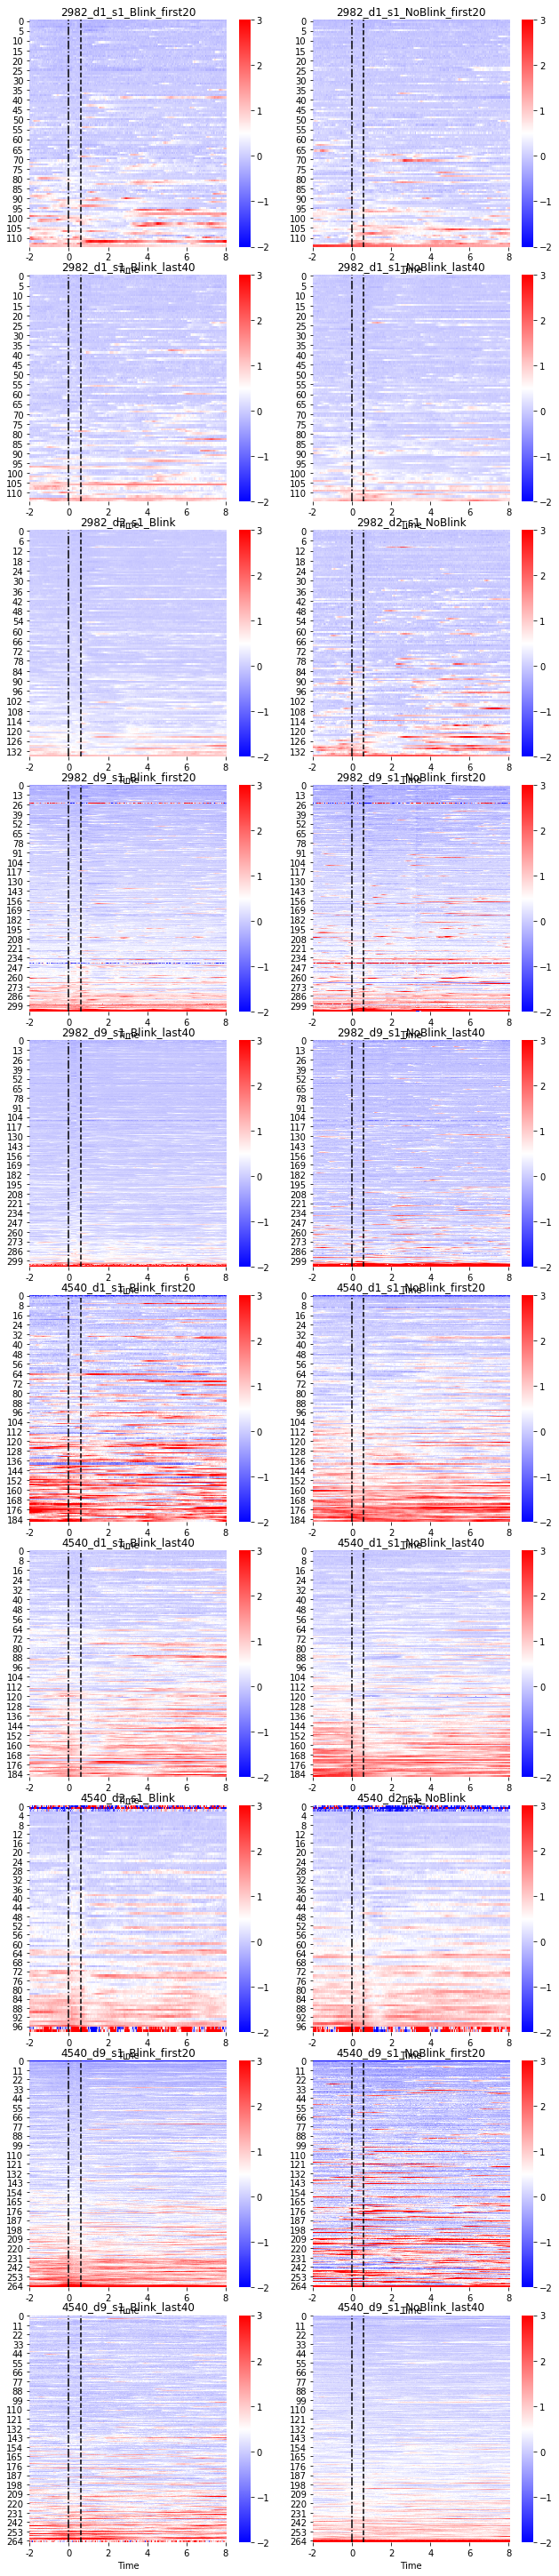

In [200]:
makeBehavAveragePlots(rTraceBlocks, rBehaviorScoring, whichData='Rebecca')

# Make Matched Sorted Average Plots

In [201]:
def plotMatchedSortedAverages(blockAvgs, whichData=None):
    #Take Average Plot Blocks and Plot Side-by-side plots of matched cells and matched sorted cells
    #Fixed Plot Parameters
    maxWidth = 3.
    cmax = 3
    cmin = -2
    start_ind=40 #40
    end_ind=52 #52
    sort_start=40 #40
    sort_end=52 #80
    #Dynamic Parameters
    mice = blockAvgs.columns.unique('mouse')
    if whichData == 'Rebecca':
        Nmice = mice.shape[0] / 5
        plotMice = mice[mice.str.contains('d9')]
    elif whichData == 'Ali':
        Nmice = mice.shape[0] / 3
        plotMice = mice[mice.str.contains('d5')]
    Nplots = Nmice*3
    layoutR, layoutC = [np.ceil(Nplots/maxWidth).astype(int), int(min(Nplots, maxWidth))]
    #Make Plots
    fig, all_ax = plt.subplots(figsize=(9, layoutR*4), nrows=layoutR, ncols=layoutC)
    fig.tight_layout()
    try: #Reshape if only one row of axes indexes
        all_ax.shape[1]
    except:
        all_ax = all_ax.reshape(1,-1)
    step=0
    all_sortedInds=[]
    for ridx, ax_row in enumerate(all_ax):
        for cidx, sel_ax in enumerate(ax_row):
            if step == Nplots:
                sel_ax.set_axis_off()
            else:
                print(plotMice[step])
                if (cidx%3 == 0): #Select New Mouse
                    cur_block=blockAvgs[plotMice[step]]
                    sort_inds=np.argsort(cur_block.loc[sort_start:sort_end,:].mean())
                    all_sortedInds.append(sort_inds)
                    cur_sorted = cur_block.loc[:,sort_inds]
                    cur_sorted.columns = range(cur_block.shape[1]) #Renumber Columns
                    sns.heatmap(cur_sorted.T, ax=sel_ax, vmin=cmin, vmax=cmax, cmap=plt.get_cmap("bwr"))
                    sel_ax.axvline(x=start_ind, linestyle='-.', color='k')
                    sel_ax.axvline(x=end_ind, linestyle='--', color='k')
                    sel_ax.set_xticks(range(0,201,40))
                    sel_ax.set_xticklabels(range(-2,9,2), rotation=0)
                    sel_ax.set_title(plotMice[step])
                    step+=1
                elif (cidx%3 == 1): #Select Next Mouse but keep sorting for above
                    cur_block=blockAvgs[plotMice[step]]
                    cur_sorted = cur_block.loc[:,sort_inds]
                    cur_sorted.columns = range(cur_block.shape[1]) #Renumber Columns
                    sns.heatmap(cur_sorted.T, ax=sel_ax, vmin=cmin, vmax=cmax, cmap=plt.get_cmap("bwr"))
                    sel_ax.axvline(x=start_ind, linestyle='-.', color='k')
                    sel_ax.axvline(x=end_ind, linestyle='--', color='k')
                    sel_ax.set_xticks(range(0,201,40))
                    sel_ax.set_xticklabels(range(-2,9,2), rotation=0)
                    sel_ax.set_title(plotMice[step])
                elif (cidx%3 == 2): #Keep Same Mouse but use own sorting
                    cur_block=blockAvgs[plotMice[step]]
                    sort_inds=np.argsort(cur_block.loc[sort_start:sort_end,:].mean())
                    all_sortedInds.append(sort_inds)
                    cur_sorted = cur_block.loc[:,sort_inds]
                    cur_sorted.columns = range(cur_block.shape[1]) #Renumber Columns
                    sns.heatmap(cur_sorted.T, ax=sel_ax, vmin=cmin, vmax=cmax, cmap=plt.get_cmap("bwr"))
                    sel_ax.axvline(x=start_ind, linestyle='-.', color='k')
                    sel_ax.axvline(x=end_ind, linestyle='--', color='k')
                    sel_ax.set_xticks(range(0,201,40))
                    sel_ax.set_xticklabels(range(-2,9,2), rotation=0)
                    sel_ax.set_title(plotMice[step])
                    step+=1 #Iterate to next mouse
    return all_sortedInds

2982_d9_s1_first20
2982_d9_s1_last40
2982_d9_s1_last40
4540_d9_s1_first20
4540_d9_s1_last40
4540_d9_s1_last40


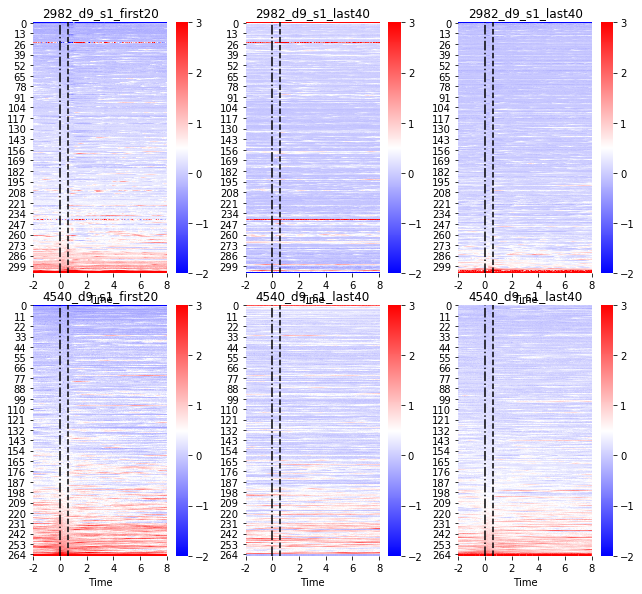

In [202]:
_ = plotMatchedSortedAverages(rBlockAverages, whichData='Rebecca')

ali24_d5_s1
ali24_d5_s2
ali24_d5_s2
ali25_d5_s1
ali25_d5_s2
ali25_d5_s2
ali26_d5_s1
ali26_d5_s2
ali26_d5_s2


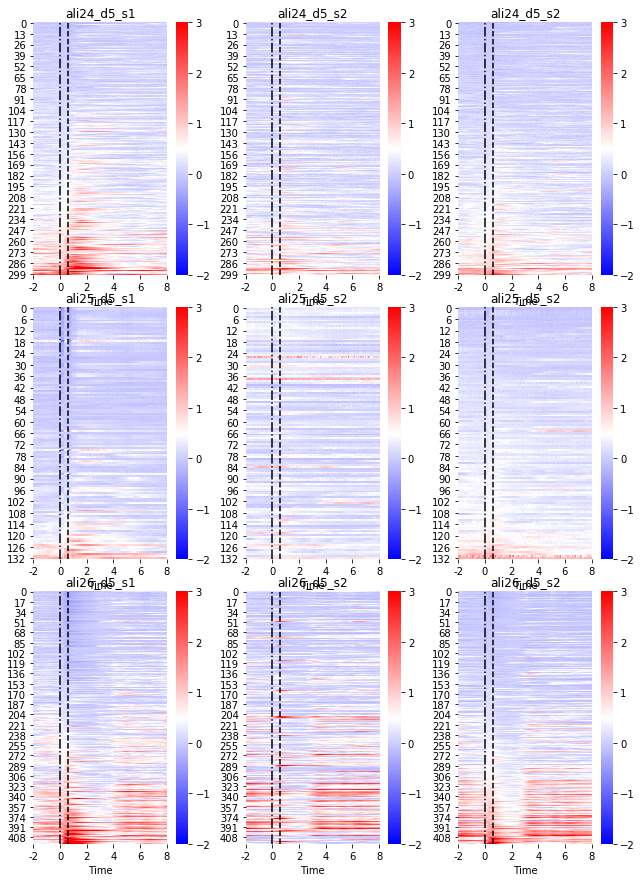

In [203]:
_ = plotMatchedSortedAverages(aliBlockAverages, whichData='Ali')

ali24_d5_s1
ali24_d5_s2
ali24_d5_s2


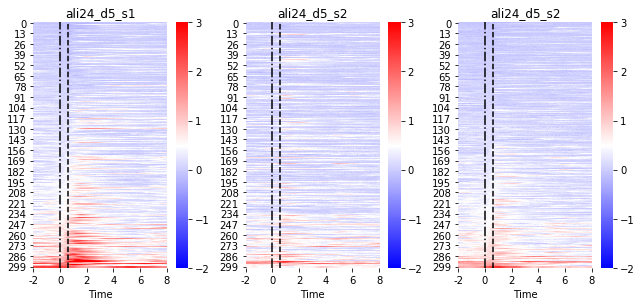

In [204]:
_ = plotMatchedSortedAverages(aliBlockAverages.loc(axis=1)[('ali24_d2_s1'):('ali24_d5_s2')], whichData='Ali')
#plt.savefig('ali24_d5_matched.png')

2982_d9_s1_first20
2982_d9_s1_last40
2982_d9_s1_last40


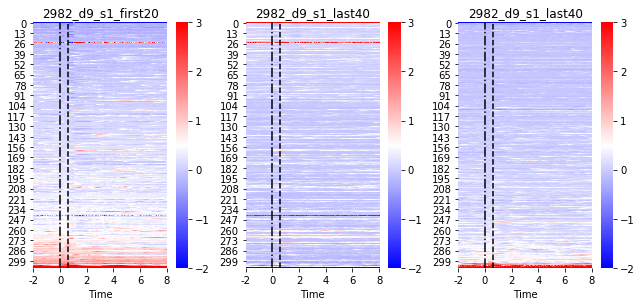

In [205]:
#Just Select One Mouse to Plot
sel_sortedInds = plotMatchedSortedAverages(rBlockAverages.loc[:, ('2982_d1_s1'):('4540_d1_s1')], whichData='Rebecca')

# Plot Single Cells over Trials

## Cells of Interest:

### Ali26:

LastTraining Sorted High Alone: 247, 73, 256, 251, 245, 307, 13, 301, 311, 240, 368, 357, 259 (Super Consistent), 140, 283 (A Little Almost Every Trial), 284, 96, 360

LastTraining Sorted High Both: 309, 320 (First 5 of Extinct), 390 (Tons lT, some Extinct), 261 (First 5 of Extinct), 118 (Locked in Extinct, early on lT), 312, 382 (First Few, and Blinking Fit), 250 (Extinct High, but shows both)

Extinction Sorted High Alone: 25, 308, 44, 213, 216, 118, 250, 382, 274, 109, 344, 100, 172, 154, 156, 293, 295, 142

### Rebecca2982:

LastTraining Sorted High Alone: 

Both: 106, 277, 306, 13, 287

Extinction Sorted High Alone: 215, 158, 287

### Ali24:


In [206]:
def getTrialScorePlots(binScores, NoBlinkColor, BlinkColor, nameCM='Not_Named'):
    #Output binary scoring values as 0s and 1s, with corresponding colormap for display in plot
    #Assume NoBlinkColor and BlinkColor are RGB Arrays
    #Output Scores
    outScores = binScores.copy()
    outScores[outScores==True] = 1
    outScores[outScores==False] = 0
    #Output Colormaps
    outCM = LinearSegmentedColormap.from_list(nameCM, colors=[NoBlinkColor, BlinkColor], N=2)
    return outScores.values.reshape(-1,1), outCM

In [207]:
def setupYaxes(Nvals, Nstep):
    #Setup Values for Y-Axes for Plots
    trial_ticks = np.arange(-1, Nvals+.1, Nstep).astype(np.int)+0.5 #Ticks along Y Axis
    np.put(trial_ticks,0,0.5) #Adjust first index to be for first row, rather than -1
    trial_labels = np.arange(0, Nvals+.1, Nstep).astype(np.int) #Tick Labels along y axis
    np.put(trial_labels,0,1) #Put first index at Beginning, rather than 0
    return trial_ticks, trial_labels

In [208]:
def singleCellAliTrialPlot(block_df, behav_df, last_sess, extinct_sess, cell_choice):
    #From one cell identity, plot that cell across all trials, in addition to plotting the matched session/trials
    #Parameters for Plot
    trial=0
    step=10
    sound_ind=40
    sound_diff = 7
    puff_ind=52
    puff_diff = 2
    Ntrials=block_df.columns.unique('trial').shape[0]
    Ngroups = Ntrials/step
    #Parameters for Axes
    ypeak = np.ceil(block_df.loc(axis=1)[last_sess, :, cell_choice].max().max())
    yfloor = np.floor(block_df.loc(axis=1)[last_sess, :, cell_choice].min().min())
    #Setup Plot Grids
    fig = plt.figure(figsize=(15, 10)) #(20,15) for saving figure
    fig.tight_layout()
    gs_left = plt.GridSpec(Ngroups, 1)
    gs_center = plt.GridSpec(1, 2)
    gs_behav = plt.GridSpec(1, 2)
    gs_cbar = plt.GridSpec(1,1)
    gs_right = plt.GridSpec(Ngroups, 1)
    ax_col1 = []; ax_col4 = [];
    for idx in np.arange(0,Ngroups):
        ax_col1.append(fig.add_subplot(gs_left[idx,0]))
        ax_col4.append(fig.add_subplot(gs_right[idx,0]))
    ax_col2 = fig.add_subplot(gs_center[0, 0])
    ax_col3 = fig.add_subplot(gs_center[0, 1])
    ax_behav1 = fig.add_subplot(gs_behav[0, 0])
    ax_behav2 = fig.add_subplot(gs_behav[0, 1])
    ax_cbar = fig.add_subplot(gs_cbar[0,0])
    #Update Extents of Plot Grids
    gs_left.update(left=0.02, right=0.25, wspace=0.05, hspace=0.05)
    gs_center.update(left=0.29, right=0.7, wspace=0.1, hspace=0.05)
    gs_behav.update(left=0.487, right=0.503, wspace=0.5, hspace=0.05)
    gs_cbar.update(left=0.71, right=0.72)
    gs_right.update(left=0.75, right=0.98, wspace=0.05, hspace=0.05)
    #Do Outside Column Plots
    for idx, c in enumerate(zip(ax_col1, ax_col4)):
        #Loop Through and Plot each Trace
        for tr in np.arange(trial,trial+step):
            c[0].plot(block_df.loc(axis=1)[last_sess, tr, cell_choice], color=[0.5,0.5,0.5])
            c[1].plot(block_df.loc(axis=1)[extinct_sess, tr, cell_choice], color=[0.5,0.5,0.5])
        #Calculate Average
        plt_mean = []
        plt_mean.append(block_df.loc(axis=1)[last_sess, trial:(trial+step), cell_choice].mean(axis=1))
        plt_mean.append(block_df.loc(axis=1)[extinct_sess, trial:(trial+step), cell_choice].mean(axis=1))
        #Loop Through Each Axes for all Plots
        for val, c_sel in enumerate(c):
            #Mean Plotting
            c_sel.plot(plt_mean[val], color=[1,0,0])
            #Set Axes Parameters
            c_sel.set_ylim([yfloor,ypeak])
            c_sel.set_ylabel('Trials {}-{}\nNormalized Fluorescence'.format(trial+1, trial+step))
            if val == 1: #Second Column
                c_sel.yaxis.tick_right()
                c_sel.yaxis.set_label_position('right')
            if idx != (Ntrials/step)-1:
                c_sel.tick_params(axis='x',bottom=False,labelbottom=False)
            #Add Tone-Puff Color Patches
            tone_patch = patches.Rectangle((sound_ind,yfloor), sound_diff, ypeak-yfloor, color=[1,0,1,0.25])
            puff_patch = patches.Rectangle((puff_ind,yfloor), puff_diff, ypeak-yfloor, color=[1,0.65,0,0.25])
            c_sel.add_patch(tone_patch)
            c_sel.add_patch(puff_patch)
        trial+=step
    #Do Inner Trial Plots
    #Setup Center Trial Y-Axes
    trial_ticks = np.arange(-1, Ntrials+.1, step).astype(np.int)+0.5 #Ticks along Y Axis
    np.put(trial_ticks,0,0.5) #Adjust first index to be for first row, rather than -1
    trial_labels = np.arange(0, Ntrials+.1, step).astype(np.int) #Tick Labels along y axis
    np.put(trial_labels,0,1) #Put first index at Beginning, rather than 0
    #Plot First Set
    sns.heatmap(block_df.loc(axis=1)[last_sess,:,cell_choice].T, vmin=yfloor, vmax=ypeak, cmap=plt.get_cmap("bwr"), ax=ax_col2, cbar=False);
    plt.sca(ax_col2)
    plt.xticks(np.arange(0, 201, 40), np.arange(-2, 8.1, 2).astype(np.int), rotation=0)
    plt.yticks(trial_ticks, trial_labels, rotation=0)
    ax_col2.axvline(x=sound_ind, linestyle='--', color='k')
    ax_col2.axvline(x=puff_ind, linestyle=':', color='k')
    ax_col2.set_xlabel('Time (sec)')
    ax_col2.set_ylabel('Trial Number')
    ax_col2.set_title('{} Cell {}'.format(last_sess, cell_choice))
    #Plot Second Set
    sns.heatmap(block_df.loc(axis=1)[extinct_sess,:,cell_choice].T, vmin=yfloor, vmax=ypeak, cmap=plt.get_cmap("bwr"), ax=ax_col3, cbar=True, cbar_ax=ax_cbar);
    plt.sca(ax_col3)
    plt.xticks(np.arange(0, 201, 40), np.arange(-2, 8.1, 2).astype(np.int), rotation=0)
    plt.yticks([])
    ax_col3.axvline(x=sound_ind, linestyle='--', color='k')
    ax_col3.axvline(x=puff_ind, linestyle=':', color='k')
    ax_col3.set_xlabel('Time (sec)')
    ax_col3.set_ylabel('')
    ax_col3.set_title('{} Cell {}'.format(extinct_sess, cell_choice))
    #Plot Behavior Stuff
    lastScore, lastCM = getTrialScorePlots(behav_df[last_sess], (1,0,0), (0,0,0), nameCM='lastTraining')
    extinctScore, extinctCM = getTrialScorePlots(behav_df[extinct_sess], (0,0,1), (0,0,0), nameCM='extinction')
    #Behavior Session 1
    sns.heatmap(lastScore, vmin=0, vmax=1, cmap=lastCM, ax=ax_behav1, cbar=False)
    plt.sca(ax_behav1)
    plt.xticks([])
    plt.yticks([])
    #Behavior Session 2
    sns.heatmap(extinctScore, vmin=0, vmax=1, cmap=extinctCM, ax=ax_behav2, cbar=False)
    plt.sca(ax_behav2)
    plt.xticks([])
    plt.yticks([])

In [209]:
def singleCellRebeccaTrialPlot(block_df, behav_df, sess_choice, Nfirst, cell_choice):
    #From one cell identity, plot that cell across all trials, in addition to plotting the matched session/trials
    #Parameters for Plot
    trialF=0 #First Trial Number
    trialL=0 #Last Trial Number
    Ngroups = 4
    sound_ind=40
    sound_diff = 7
    puff_ind=52
    puff_diff = 2
    Ntrials=block_df.columns.unique('trial').shape[0]
    Nlast = Ntrials-Nfirst
    Nfirst_step= Nfirst/Ngroups
    Nlast_step = Nlast/Ngroups
    #Parameters for Axes
    ypeak = np.ceil(block_df.loc(axis=1)[sess_choice, :, cell_choice].max().max())
    yfloor = np.floor(block_df.loc(axis=1)[sess_choice, :, cell_choice].min().min())
    #Setup Plot Grids
    fig = plt.figure(figsize=(10,7)) #(20,15) for saving figure
    fig.tight_layout()
    gs_left = plt.GridSpec(Ngroups, 1)
    gs_center = plt.GridSpec(1, 2)
    gs_behav = plt.GridSpec(1, 2)
    gs_cbar = plt.GridSpec(1,1)
    gs_right = plt.GridSpec(Ngroups, 1)
    ax_col1 = []; ax_col4 = [];
    for idx in np.arange(0,Ngroups):
        ax_col1.append(fig.add_subplot(gs_left[idx,0]))
        ax_col4.append(fig.add_subplot(gs_right[idx,0]))
    ax_col2 = fig.add_subplot(gs_center[0, 0])
    ax_col3 = fig.add_subplot(gs_center[0, 1])
    ax_behav1 = fig.add_subplot(gs_behav[0, 0])
    ax_behav2 = fig.add_subplot(gs_behav[0, 1])
    ax_cbar = fig.add_subplot(gs_cbar[0,0])
    #Update Extents of Plot Grids
    gs_left.update(left=0.02, right=0.25, wspace=0.05, hspace=0.05)
    gs_center.update(left=0.29, right=0.7, wspace=0.1, hspace=0.05)
    gs_behav.update(left=0.487, right=0.503, wspace=0.5, hspace=0.05)
    gs_cbar.update(left=0.71, right=0.72)
    gs_right.update(left=0.75, right=0.98, wspace=0.05, hspace=0.05)
    #Do Outside Column Plots
    for idx, c in enumerate(zip(ax_col1, ax_col4)):
        #Loop Through and Plot each Trace
        for trF in np.arange(trialF,trialF+Nfirst_step):
            c[0].plot(block_df.loc(axis=1)[sess_choice, trF, cell_choice], color=[0.5,0.5,0.5])
        for trL in np.arange(trialL,trialL+Nlast_step):
            c[1].plot(block_df.loc(axis=1)[sess_choice, trL, cell_choice], color=[0.5,0.5,0.5])
        #Calculate Average
        plt_mean = []
        plt_mean.append(block_df.loc(axis=1)[sess_choice, trialF:(trialF+Nfirst_step), cell_choice].mean(axis=1))
        plt_mean.append(block_df.loc(axis=1)[sess_choice, trialL:(trialL+Nlast_step), cell_choice].mean(axis=1))
        #Loop Through Each Axes for all Plots
        for val, c_sel in enumerate(c):
            #Mean Plotting
            c_sel.plot(plt_mean[val], color=[1,0,0])
            #Set Axes Parameters
            c_sel.set_ylim([yfloor,ypeak])
            if val == 1: #Second Column
                c_sel.yaxis.tick_right()
                c_sel.yaxis.set_label_position('right')
                c_sel.set_ylabel('Trials {}-{}\nNormalized Fluorescence'.format(trialL+1, trialL+Nlast_step))
            else:
                c_sel.set_ylabel('Trials {}-{}\nNormalized Fluorescence'.format(trialF+1, trialF+Nfirst_step))
            if idx != (Ngroups-1):
                c_sel.tick_params(axis='x',bottom=False,labelbottom=False)
            #Add Tone-Puff Color Patches
            tone_patch = patches.Rectangle((sound_ind,yfloor), sound_diff, ypeak-yfloor, color=[1,0,1,0.25])
            puff_patch = patches.Rectangle((puff_ind,yfloor), puff_diff, ypeak-yfloor, color=[1,0.65,0,0.25])
            c_sel.add_patch(tone_patch)
            c_sel.add_patch(puff_patch)
        trialF+=Nfirst_step
        trialL+=Nlast_step
    #Do Inner Trial Plots
    #Setup Center Trial Y-Axes
    trial_ticksF, trial_labelsF = setupYaxes(Nfirst, Nfirst_step)
    trial_ticksL, trial_labelsL = setupYaxes(Nlast, Nlast_step)
    #Plot First Set
    sns.heatmap(block_df.loc(axis=1)[sess_choice,:(Nfirst-1),cell_choice].T, vmin=yfloor, vmax=ypeak, cmap=plt.get_cmap("bwr"), ax=ax_col2, cbar=False);
    plt.sca(ax_col2)
    plt.xticks(np.arange(0, 201, 40), np.arange(-2, 8.1, 2).astype(np.int), rotation=0)
    plt.yticks(trial_ticksF, trial_labelsF, rotation=0)
    ax_col2.axvline(x=sound_ind, linestyle='--', color='k')
    ax_col2.axvline(x=puff_ind, linestyle=':', color='k')
    ax_col2.set_xlabel('Time (sec)')
    ax_col2.set_ylabel('Trial Number')
    ax_col2.set_title('{} Cell {}'.format(sess_choice, cell_choice))
    #Plot Second Set
    sns.heatmap(block_df.loc(axis=1)[sess_choice,Nfirst:,cell_choice].T, vmin=yfloor, vmax=ypeak, cmap=plt.get_cmap("bwr"), ax=ax_col3, cbar=True, cbar_ax=ax_cbar);
    plt.sca(ax_col3)
    plt.xticks(np.arange(0, 201, 40), np.arange(-2, 8.1, 2).astype(np.int), rotation=0)
    plt.yticks([])
    ax_col3.axvline(x=sound_ind, linestyle='--', color='k')
    ax_col3.axvline(x=puff_ind, linestyle=':', color='k')
    ax_col3.set_xlabel('Time (sec)')
    ax_col3.set_ylabel('')
    ax_col3.set_title('{} Cell {}'.format(sess_choice, cell_choice))
    #Plot Behavior Stuff
    lastScore, lastCM = getTrialScorePlots(behav_df[sess_choice][:(Nfirst-1)], (1,0,0), (0,0,0), nameCM='lastTraining')
    extinctScore, extinctCM = getTrialScorePlots(behav_df[sess_choice][Nfirst:], (0,0,1), (0,0,0), nameCM='extinction')
    #Behavior Session 1
    sns.heatmap(lastScore, vmin=0, vmax=1, cmap=lastCM, ax=ax_behav1, cbar=False)
    plt.sca(ax_behav1)
    plt.xticks([])
    plt.yticks([])
    #Behavior Session 2
    sns.heatmap(extinctScore, vmin=0, vmax=1, cmap=extinctCM, ax=ax_behav2, cbar=False)
    plt.sca(ax_behav2)
    plt.xticks([])
    plt.yticks([])

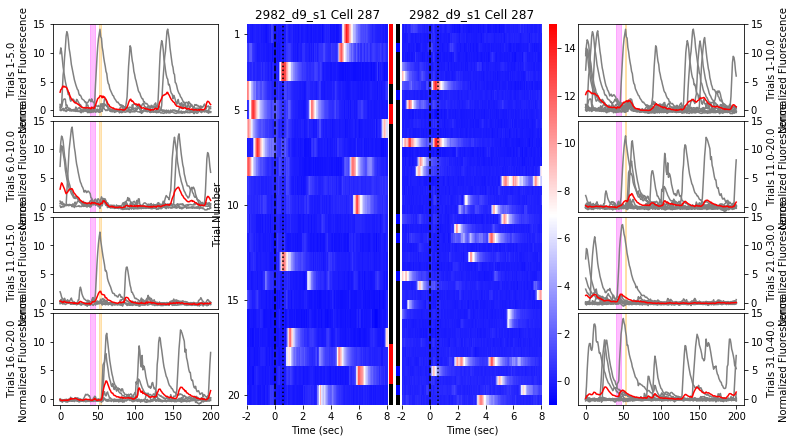

In [210]:
singleCellRebeccaTrialPlot(rTraceBlocks, rBehaviorScoring, '2982_d9_s1', 20, 287)

## Figures for paper 

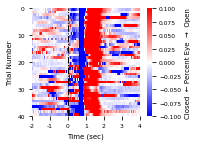

In [211]:
#Plotting For Figure Generation (Figure 1C - Heatmap)
start=40
end=52
endView = 120
cmax = .1
cmin = -.1
#Font Details
label_size=7
tick_size=6
fig = plt.figure(figsize=(2.5,2)) #(2.5, 2)
ax = fig.add_axes([0.15, 0.18, 0.75, 0.75])
sns.heatmap(aliEyeBlocks[1,:,:endView],vmin=cmin, vmax=cmax, cmap=plt.get_cmap("bwr"))
#sns.heatmap(rEyeBlocks[5,:,:endView],vmin=cmin, vmax=cmax, cmap=plt.get_cmap("bwr"))
#Colorbar Font Sizing
cbar_axes=fig.axes[1]
cbar_axes.tick_params(labelsize=tick_size)
cbar_axes.set_ylabel(u'Closed  \u2190 Percent Eye  \u2192  Open', fontsize=label_size)
plt.xticks(range(0,121,20), range(-2, 5, 1), rotation=0, fontsize=tick_size)
plt.yticks(range(0,41,10), range(0, 41, 10), rotation=0, fontsize=tick_size)
plt.ylabel('Trial Number', fontsize=label_size)
plt.xlabel('Time (sec)', fontsize=label_size)
plt.axvline(x=start, linestyle='-.', color='k', linewidth=1)
plt.axvline(x=end, linestyle='--', color='k', linewidth=1)
#plt.savefig('EyeBlinkPlot.png', format='png', dpi=1200, transparent=True)

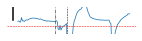

In [212]:
#Plotting For Figure Generation (Figure 1C - Trace)
start=40
end=52
endView = 120
#Font Details
label_size=7
tick_size=6
fig = plt.figure(figsize=(2.3,0.5)) #(2.3, 0.5)
plt.axis('off')
ax = plt.plot(aliEyeBlocks[1,2,:endView], linewidth=0.75)#,vmin=cmin, vmax=cmax, cmap=plt.get_cmap("bwr"))
#plt.xticks(range(0,121,20), range(-2, 5, 1), rotation=0, fontsize=tick_size)
#plt.yticks([0.1*x for x in range(-12,3,2)], [0.1*x for x in range(-12, 3, 2)], rotation=0, fontsize=tick_size)
#plt.ylabel('Percent Eye Closed', fontsize=label_size)
#plt.xlabel('Time (sec)', fontsize=label_size)
plt.ylim([-0.2, 0.2])
plt.axvline(x=start, linestyle='-.', color='k', linewidth=0.5)
plt.axvline(x=end, linestyle='--', color='k', linewidth=0.5)
plt.axhline(y=aliEyeThresholds.loc[0,'ali24_d5_s1'], linestyle='--', color='r', linewidth=0.5)
plt.plot([-5, -5],[0, 0.2], 'k')
plt.savefig('EyeBlinkTrace.png', format='png', dpi=1200, transparent=True)

In [213]:
def makeAliFignames(mouse_numbers, mouse_days, mouse_sessions):
    #Input lists of mouse numbers, days, and sessions to permute to give out directories and dictionary for figure names
    directories = []
    filenames = {}
    for m_num in mouse_numbers:
        for m_day in mouse_days:
            for m_sess in mouse_sessions:
                if ((m_day != 2) | (m_sess != 2)): #Skip d2_s2.  Only do d5_s2
                    mouse_dir = 'ali{}_d{}_s{}/'.format(m_num, m_day, m_sess)
                    directories.append(mouse_dir)
                    filenames[mouse_dir] = 'full_projection_m_f_max_min_batch.fig'
    return directories, filenames

In [214]:
def loadFigures(files):
    #Loop through .mat fig files, load them, and save output as numpy arrays
    imgs = []
    for f in files:
        f_id = f.split('/')[-2] #Take Dir Name as ID
        mat_fig = loadmat(f)
        img = mat_fig['hgS_070000'][0,0][3][0,0][3][0,0][2][0,0][1] #Nasty Figure Children Navigation to CData of Figure
        r, c = img.shape
        mIdx = pd.MultiIndex.from_product([[f_id],range(c)], names=['mouse','pixel_num'])
        imgs.append(pd.DataFrame(data=img, index=range(r), columns=mIdx))
    outImgs = pd.concat(imgs, axis=1)
    return outImgs

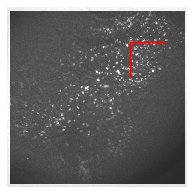

In [215]:
#Plotting Cell Selection Map (Figure 2A - Spatial Map)
#Need to first load functions from "Load and Display ROIs"

#Selected Mice Case
selMouse, selDay, selSess = [[24], [5], [1]]
selFigFolders, selFignames = makeAliFignames(selMouse, selDay, selSess)
selFigs = combineFilenames(aliBase, selFigFolders, selFignames)
selImg = loadFigures(selFigs)

#Window Coordinates
r1, r2, c1, c2 = [200, 400, 700, 900]
ycoords = [r1, r1, r2, r2, r1]
xcoords = [c1, c2, c2, c1, c1]

#Plot the Image
fig, sel_ax = plt.subplots(figsize=(2.5, 2.5), nrows=1, ncols=1) #(2.5,2.5)
grayMin=0
grayMax = selImg.quantile(q=.85).max()
sns.heatmap(selImg.values, ax=sel_ax, vmin=grayMin, vmax=grayMax, cmap=plt.get_cmap("gray"), cbar=False)
sel_ax.plot(xcoords, ycoords, 'r', linewidth=1)
sel_ax.axis('off')
sel_ax.set_position([0,0,1,1])
sel_ax.set_aspect('equal')
#plt.savefig('ali24_d5Map.png', format='png', dpi=1200, transparent=True)


#Color Stuff
#c=310
#r_bound = measure.find_contours(sel_roi[c,:,:], 0.5)[0]
#sel_ax.plot(r_bound[:,0], r_bound[:,1], c=sel_color_df[c])

## Subtracted and sorted heatmaps 

In [216]:
#Colormap Creation from Other Colormap
full_gist = cm.get_cmap('gist_stern',256)
topgist_cm = ListedColormap(full_gist(np.linspace(0.25, 1, 256)))

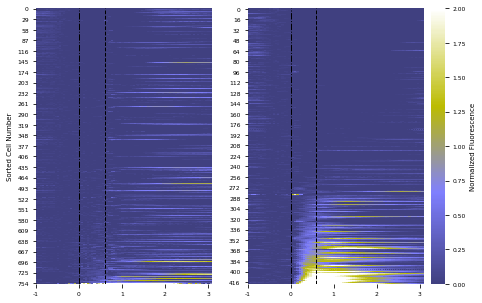

In [217]:
#Plotting for Figure Generation (Figure 2Bii - Day 1 to Last Day Comparisons)#come from aliTraces, not matche traces in the section "Make Temporal Blocks for Averaged Plots"
#Fixed Plot Parameters
# -1 to 3 seconds 
cmax = 2
cmin = 0
start_ind=20 #40
end_ind=32 #52
sort_start=40 #40
sort_end=52 #80
#Font Details
label_size=7
tick_size=6
title_size=9
#Make Plot4.1
fig, all_ax = plt.subplots(figsize=(7,5.1), nrows=1, ncols=2)#(4, 2.5)
#Pull Out Data
block_averages = aliTraceBlocks.groupby(level=['mouse','cell_num'], axis=1).mean()

#Plot 1
cur_block1=block_averages['ali26_d2_s1']

bef_interval_mean = cur_block1.loc[28:39,:].mean(axis=0)
cur_block1=cur_block1-bef_interval_mean
sort_inds1=np.argsort(cur_block1.loc[sort_start:sort_end,:].mean())
cur_sorted1 = cur_block1.loc[20:101,sort_inds1]

cur_sorted1.columns = range(cur_block1.shape[1])
sel_ax1=all_ax[0]
sns.heatmap(cur_sorted1.T, ax=sel_ax1, vmin=cmin, vmax=cmax, cbar=False, cmap=topgist_cm)
sel_ax1.axvline(x=start_ind, linestyle='-.', color='k', linewidth=1)
sel_ax1.axvline(x=end_ind, linestyle='--', color='k', linewidth=1)
sel_ax1.set_xticks(range(0,81,20))
sel_ax1.set_xticklabels(range(-1,4,1), rotation=0)
sel_ax1.tick_params(labelsize=tick_size)
sel_ax1.set_ylabel('Sorted Cell Number', fontsize=label_size)
sel_ax1.set_xlabel('', fontsize=label_size, labelpad=1) #Blank Label
#sel_ax1.set_xlabel('Time (sec)', fontsize=label_size, labelpad=1)
sel_ax1.set_position([0.1, 0.125, 0.35, 0.75])
#sel_ax1.set_title('Day 1 Recording', fontsize=title_size)
#Colorbar Font Sizing
#cbar_axes=fig.axes[2]
#cbar_axes.tick_params(labelsize=tick_size)
#cbar_axes.set_ylabel('Percent Eye Closed', fontsize=label_size)

#Plot 2
cur_block2=block_averages['ali26_d5_s1']
bef_interval_mean = cur_block2.loc[28:39,:].mean(axis=0)
#print(cur_block1
cur_block2=cur_block2-bef_interval_mean
sort_inds2=np.argsort(cur_block2.loc[sort_start:sort_end,:].mean())
cur_sorted2 = cur_block2.loc[20:101,sort_inds2]
cur_sorted2.columns = range(cur_block2.shape[1])
sel_ax2=all_ax[1]
sns.heatmap(cur_sorted2.T, ax=sel_ax2, vmin=cmin, vmax=cmax, cmap=topgist_cm) #cubehelix #inferno #viridis
sel_ax2.axvline(x=start_ind, linestyle='-.', color='k', linewidth=1)
sel_ax2.axvline(x=end_ind, linestyle='--', color='k', linewidth=1)
sel_ax2.set_xticks(range(0,81,20))
sel_ax2.set_xticklabels(range(-1,4,1), rotation=0)
sel_ax2.tick_params(labelsize=tick_size)
sel_ax2.set_position([0.52, 0.125, 0.35, 0.75])
sel_ax2.set_xlabel('', fontsize=label_size, labelpad=1)
#sel_ax2.set_xlabel('Time (sec)', fontsize=label_size, labelpad=1)
#sel_ax2.set_ylabel('Sorted Cell Number', fontsize=label_size)
#sel_ax2.set_title('Last Day Recording', fontsize=title_size)
#Colorbar Font Sizing
cbar_axes=fig.axes[2]
cbar_axes.tick_params(labelsize=tick_size)
cbar_axes.set_ylabel('Normalized Fluorescence', fontsize=label_size)
cbar_axes.set_position([0.885, 0.125, 0.1, 0.75])
#plt.tight_layout()
#plt.savefig('ali26_d2_d5_subtracted_final.png', bbox_inches='tight', format='png', dpi=1200, transparent=True)
plt.savefig('ali26_d2_d5_subtracted_final.eps', format='eps')

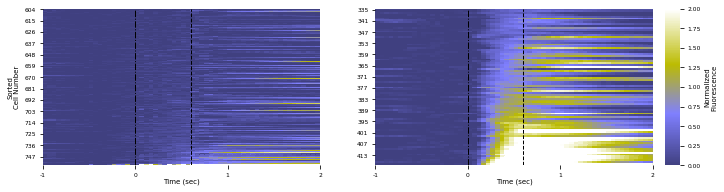

In [218]:
#Plotting for Figure Generation (Figure 2Biii - Day 1 to Last Day Comparisons Zoom In)
#Fixed Parameters
pctShow = 0.2
pctPick = 1-pctShow
#Make Plots
fig, all_ax = plt.subplots(figsize=(11, 2.9), nrows=1, ncols=2)#(4, 0.75)


#Plot 1
indPick1 = np.floor(pctPick*cur_sorted1.shape[1])
sel_ax1=all_ax[0]
sns.heatmap(cur_sorted1.loc[:,indPick1:].T, ax=sel_ax1, vmin=cmin, vmax=cmax, cbar=False, cmap=topgist_cm)
sel_ax1.axvline(x=start_ind, linestyle='-.', color='k', linewidth=1)
sel_ax1.axvline(x=end_ind, linestyle='--', color='k', linewidth=1)
sel_ax1.set_xticks(range(0,81,20))
sel_ax1.set_xticklabels(range(-1,4,1), rotation=0)
sel_ax1.tick_params(labelsize=tick_size)
sel_ax1.set_xlim([0, 60])
sel_ax1.set_ylabel('Sorted\nCell Number', fontsize=label_size)
sel_ax1.set_xlabel('Time (sec)', fontsize=label_size, labelpad=1)
sel_ax1.set_position([0.1, 0.125, 0.35, 0.75])
#sel_ax1.set_title('Day 1 Recording', fontsize=title_size)
#Colorbar Font Sizing
#cbar_axes=fig.axes[2]
#cbar_axes.tick_params(labelsize=tick_size)
#cbar_axes.set_ylabel('Percent Eye Closed', fontsize=label_size)

#Plot 2
indPick2 = np.floor(pctPick*cur_sorted2.shape[1])
sel_ax2=all_ax[1]
sns.heatmap(cur_sorted2.loc[:,indPick2:].T, ax=sel_ax2, vmin=cmin, vmax=cmax, cmap=topgist_cm) #cubehelix #inferno #viridis
sel_ax2.axvline(x=start_ind, linestyle='-.', color='k', linewidth=1)
sel_ax2.axvline(x=end_ind, linestyle='--', color='k', linewidth=1)
sel_ax2.set_xticks(range(0,81,20))
sel_ax2.set_xticklabels(range(-1,4,1), rotation=0)
sel_ax2.tick_params(labelsize=tick_size)
sel_ax2.set_xlim([0, 60])
sel_ax2.set_position([0.52, 0.125, 0.35, 0.75])
sel_ax2.set_xlabel('Time (sec)', fontsize=label_size, labelpad=1)
#sel_ax2.set_ylabel('Sorted Cell Number', fontsize=label_size)
#sel_ax2.set_title('Last Day Recording', fontsize=title_size)
#Colorbar Font Sizing
cbar_axes=fig.axes[2]
cbar_axes.tick_params(labelsize=tick_size)
cbar_axes.set_ylabel('Normalized\nFluorescence', fontsize=label_size)
cbar_axes.set_position([0.885, 0.125, 0.1, 0.75])
cbar_axes.set_aspect(10)
#plt.savefig('ali26_d2_d5_subtracted_Zoom.png', bbox_inches='tight', format='png', dpi=1200, transparent=True)
plt.savefig('ali26_d2_d5_subtracted_Zoom.eps', format='eps')

Text(0.5, 1.0, 'Last Training Session')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


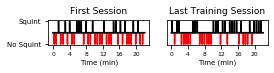

In [219]:
#Plotting for Figure Generation (Figure 2Bi - Day 1 to Last Day Behavior Comparisons)
#Fixed Plot Parameters
#Font Details
label_size=7
tick_size=6
title_size=9
#Make Plots
fig, all_ax = plt.subplots(figsize=(3.5, 0.5), nrows=1, ncols=2) #(3.5, 0.5)
#Initialize Data for Making Traces
trialEdges = aliSounds.apply(findPulses, axis=0)

#Plot 1
mouse='ali24_d2_s1'
curMouse_df = binaryTrialTrace(trialEdges[mouse], aliBehaviorScoring[mouse], mouse)
no_blink_color = 'r'
sel_ax1 = all_ax[0]
sel_ax1.plot(curMouse_df.loc[:,(mouse,'NoBlink')], no_blink_color)
sel_ax1.plot(curMouse_df.loc[:,(mouse,'Blink')], 'k')
sel_ax1.set_xticks(range(0, 24001, 4800))
sel_ax1.set_xticklabels(range(0, 21, 4), fontsize=tick_size)
sel_ax1.set_xlabel('Time (min)', labelpad=2, fontsize=label_size)
sel_ax1.set_yticks([-1, 1])
sel_ax1.set_yticklabels(['No Squint', 'Squint'], fontsize=label_size)
sel_ax1.set_position([.05, .125, .4, .7])
sel_ax1.set_title('First Session', fontsize=title_size)

#Plot 2
mouse='ali24_d5_s1'
curMouse_df = binaryTrialTrace(trialEdges[mouse], aliBehaviorScoring[mouse], mouse)
no_blink_color = 'r'
sel_ax2 = all_ax[1]
sel_ax2.plot(curMouse_df.loc[:,(mouse,'NoBlink')], no_blink_color)
sel_ax2.plot(curMouse_df.loc[:,(mouse,'Blink')], 'k')
sel_ax2.set_xticks(range(0, 24001, 4800))
sel_ax2.set_xticklabels(range(0, 21, 4), fontsize=tick_size)
sel_ax2.set_xlabel('Time (min)', labelpad=2, fontsize=label_size)
sel_ax2.set_yticks([])
sel_ax2.set_position([.52, .125, .4, .7])
sel_ax2.set_title('Last Training Session', fontsize=title_size)
#plt.tight_layout()
#plt.savefig('ali24_d2_d5_Behavior.png', bbox_inches='tight', format='png', dpi=1200, transparent=True)

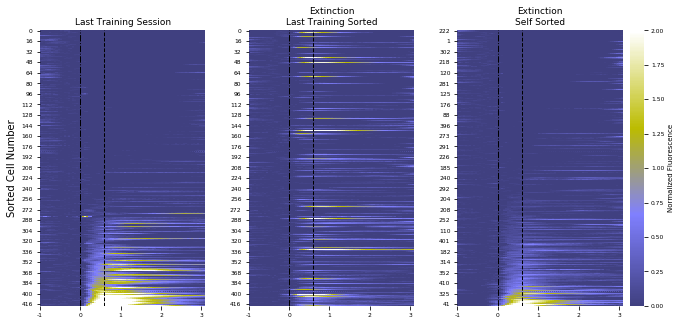

In [220]:
#Plotting for Figure Generation Test 2 after fixing Sorting(Figure 2Cii - Day 5 Last Day and Extinction Comparisons)
#aliTraceBlocks should come from aliMatched, not matched traces in the section "Make Temporal Blocks for Averaged Plots"
#Fixed Plot 1.5arameters
cmax =2
cmin = 0
start_ind=20 #40
end_ind=32 #52
sort_start=40 #40
sort_end=52 #80
#Font Details
label_size=7
tick_size=6
title_size=9
#Make Plots
fig, all_ax = plt.subplots(figsize=(10, 5.1), nrows=1, ncols=3) #(5, 2.5)

#First Plot
sel_ax1 = all_ax[0]
cur_block1 = aliBlockAverages['ali26_d5_s1']
bef_interval_mean =cur_block1.loc[28:39,:].mean(axis=0)
cur_block1=cur_block1-bef_interval_mean
sort_inds1=np.argsort(cur_block1.loc[sort_start:sort_end,:].mean())
cur_sorted1 = cur_block1.loc[20:101,sort_inds1]
cur_sorted1.columns = range(cur_block1.shape[1]) #Renumber Columns
sns.heatmap(cur_sorted1.T, ax=sel_ax1, vmin=cmin, vmax=cmax, cbar=False, cmap=topgist_cm)
sel_ax1.axvline(x=start_ind, linestyle='-.', color='k', linewidth=1)
sel_ax1.axvline(x=end_ind, linestyle='--', color='k', linewidth=1)
sel_ax1.set_xticks(range(0,81,20))
sel_ax1.set_xticklabels(range(-1,4,1), rotation=0)
sel_ax1.tick_params(labelsize=tick_size)
sel_ax1.set_xlabel('', fontsize=label_size, labelpad=1)
#sel_ax1.set_xlabel('Time (sec)', fontsize=label_size, labelpad=1)
sel_ax1.set_ylabel('Sorted Cell Number')
sel_ax1.set_title('Last Training Session', fontsize=title_size)
sel_ax1.set_position([0.1, 0.125, 0.23, 0.75])

#Middle Plot
sel_ax2 = all_ax[1]
cur_block2 = aliBlockAverages['ali26_d5_s2']
bef_interval_mean =cur_block2.loc[28:39,:].mean(axis=0)
cur_block2=cur_block2-bef_interval_mean
cur_sorted2 = cur_block2.loc[20:101,sort_inds1]
cur_sorted2.columns = cur_sorted1.columns #Renumber Columns to match First
sns.heatmap(cur_sorted2.T, ax=sel_ax2, vmin=cmin, vmax=cmax, cbar=False, cmap=topgist_cm)
sel_ax2.axvline(x=start_ind, linestyle='-.', color='k', linewidth=1)
sel_ax2.axvline(x=end_ind, linestyle='--', color='k', linewidth=1)
sel_ax2.set_xticks(range(0,81,20))
sel_ax2.set_xticklabels(range(-1,4,1), rotation=0)
sel_ax2.tick_params(labelsize=tick_size)
sel_ax2.set_xlabel('', fontsize=label_size, labelpad=1)
#sel_ax2.set_xlabel('Time (sec)', fontsize=label_size, labelpad=1)
sel_ax2.set_title('Extinction\nLast Training Sorted', fontsize=title_size)
sel_ax2.set_position([0.39, 0.125, 0.23, 0.75])

#Last Plot
sel_ax3 = all_ax[2]
cur_block3 = cur_sorted2
bef_interval_mean =cur_block3.loc[28:39,:].mean(axis=0)
cur_block3=cur_block3-bef_interval_mean
sort_inds3 = np.argsort(cur_block3.loc[sort_start:sort_end,:].mean())
cur_sorted3 = cur_block3.loc[20:101,sort_inds3]
sns.heatmap(cur_sorted3.T, ax=sel_ax3, vmin=cmin, vmax=cmax, cmap=topgist_cm)
sel_ax3.axvline(x=start_ind, linestyle='-.', color='k', linewidth=1)
sel_ax3.axvline(x=end_ind, linestyle='--', color='k', linewidth=1)
sel_ax3.set_xticks(range(0,81,20))
sel_ax3.set_xticklabels(range(-1,4,1), rotation=0)
sel_ax3.tick_params(labelsize=tick_size)
sel_ax3.set_xlabel('', fontsize=label_size, labelpad=1)
#sel_ax3.set_xlabel('Time (sec)', fontsize=label_size, labelpad=1)
sel_ax3.set_title('Extinction\nSelf Sorted', fontsize=title_size)
sel_ax3.set_position([0.68, 0.125, 0.23, 0.75])

#Colorbar Font Sizing
cbar_axes=fig.axes[3]
cbar_axes.tick_params(labelsize=tick_size)
cbar_axes.set_ylabel('Normalized Fluorescence', fontsize=label_size)
cbar_axes.set_position([0.92, 0.125, 0.08, 0.75])

#plt.savefig('ali26_d5_Comparison_-1to3_subtracted.png', bbox_inches='tight', format='png', dpi=1200, transparent=True)
plt.savefig('ali26_d5_Comparison_-1to3_subtracted.eps',format='eps')

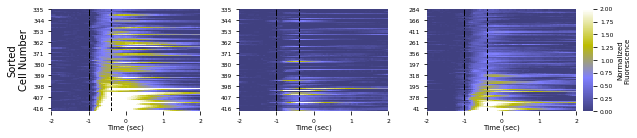

In [221]:
#Plotting for Figure Generation Test 2 after fixing Sorting(Figure 2Ciii - Day 5 Last Day and Extinction Comparisons Zoom In)
#Fixed Plot Parameters
#Fixed Parameters
pctShow = 0.2
pctPick = 1-pctShow
#Make Plots
fig, all_ax = plt.subplots(figsize=(9, 1.9), nrows=1, ncols=3) #(5, 0.75)

#First Plot
indPick1 = int(np.floor(pctPick*cur_sorted1.shape[1]))
sel_ax1 = all_ax[0]
sns.heatmap(cur_sorted1.iloc[:,indPick1:].T, ax=sel_ax1, vmin=cmin, vmax=cmax, cbar=False, cmap=topgist_cm)
sel_ax1.axvline(x=start_ind, linestyle='-.', color='k', linewidth=1)
sel_ax1.axvline(x=end_ind, linestyle='--', color='k', linewidth=1)
sel_ax1.set_xticks(range(0,201,20))
sel_ax1.set_xticklabels(range(-2,9,1), rotation=0)
sel_ax1.tick_params(labelsize=tick_size)
sel_ax1.set_xlim([0, 80])
sel_ax1.set_xlabel('Time (sec)', fontsize=label_size, labelpad=1)
sel_ax1.set_ylabel('Sorted\nCell Number')
sel_ax1.set_position([0.1, 0.125, 0.23, 0.75])

#Middle Plot
indPick2 = int(np.floor(pctPick*cur_sorted2.shape[1]))
sel_ax2 = all_ax[1]
sns.heatmap(cur_sorted2.iloc[:,indPick2:].T, ax=sel_ax2, vmin=cmin, vmax=cmax, cbar=False, cmap=topgist_cm)
sel_ax2.axvline(x=start_ind, linestyle='-.', color='k', linewidth=1)
sel_ax2.axvline(x=end_ind, linestyle='--', color='k', linewidth=1)
sel_ax2.set_xticks(range(0,201,20))
sel_ax2.set_xticklabels(range(-2,9,1), rotation=0)
sel_ax2.tick_params(labelsize=tick_size)
sel_ax2.set_xlim([0, 80])
sel_ax2.set_xlabel('Time (sec)', fontsize=label_size, labelpad=1)
sel_ax2.set_position([0.39, 0.125, 0.23, 0.75])

#Last Plot
indPick3 = int(np.floor(pctPick*cur_sorted3.shape[1]))
sel_ax3 = all_ax[2]
sns.heatmap(cur_sorted3.iloc[:,indPick3:].T, ax=sel_ax3, vmin=cmin, vmax=cmax, cmap=topgist_cm)
sel_ax3.axvline(x=start_ind, linestyle='-.', color='k', linewidth=1)
sel_ax3.axvline(x=end_ind, linestyle='--', color='k', linewidth=1)
sel_ax3.set_xticks(range(0,201,20))
sel_ax3.set_xticklabels(range(-2,9,1), rotation=0)
sel_ax3.tick_params(labelsize=tick_size)
sel_ax3.set_xlim([0, 80])
sel_ax3.set_xlabel('Time (sec)', fontsize=label_size, labelpad=1)
sel_ax3.set_position([0.68, 0.125, 0.23, 0.75])

#Colorbar Font Sizing
cbar_axes=fig.axes[3]
cbar_axes.tick_params(labelsize=tick_size)
cbar_axes.set_ylabel('Normalized\nFluorescence', fontsize=label_size)
cbar_axes.set_position([0.92, 0.125, 0.08, 0.75])
cbar_axes.set_aspect(10)

#plt.savefig('ali26_d5_Comparison_Zoom_subtracted.png', bbox_inches='tight', format='png', dpi=1200, transparent=True)
plt.savefig('ali26_d5_Comparison_Zoom_subtracted.eps', format='eps')

## Supplemental figure 

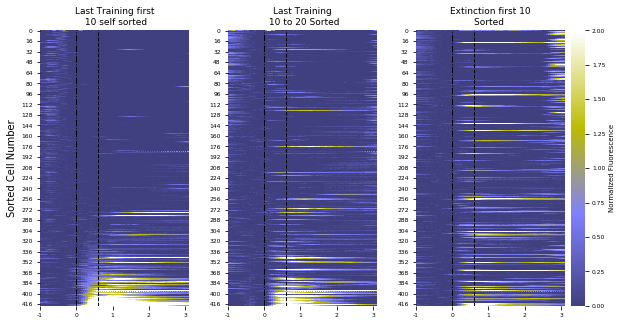

In [222]:
#First 3 figures animal - ali 26 -2 to 8 s or shorter time ? Subtracted 
cmax = 2
cmin = 0
start_ind=20 #40
end_ind=32 #52
sort_start=40 #40
sort_end=52 #80
#Font Details
label_size=7
tick_size=6
title_size=9
#Make Plots
fig, all_ax = plt.subplots(figsize=(9, 5.1), nrows=1, ncols=3) #(5, 2.5)

#First Plot
sel_ax1 = all_ax[0]
Nfirst=10
block_df=aliTraceBlocks['ali26_d5_s1'].loc[:, aliTraceBlocks['ali26_d5_s1'].columns.get_level_values('trial').isin(range(Nfirst))]
cur_block1=block_df.groupby(level=['cell_num'], axis=1).mean()
bef_interval_mean =cur_block1.loc[28:39,:].mean(axis=0)
cur_block1=cur_block1-bef_interval_mean
#cur_block1 = aliBlockAverages['ali24_d5_s1']
sort_inds1=np.argsort(cur_block1.loc[sort_start:sort_end,:].mean())
cur_sorted1 = cur_block1.loc[20:101,sort_inds1]
cur_sorted1.columns = range(cur_block1.shape[1]) #Renumber Columns
sns.heatmap(cur_sorted1.T, ax=sel_ax1, vmin=cmin, vmax=cmax, cbar=False, cmap=topgist_cm)
sel_ax1.axvline(x=start_ind, linestyle='-.', color='k', linewidth=1)
sel_ax1.axvline(x=end_ind, linestyle='--', color='k', linewidth=1)
sel_ax1.set_xticks(range(0,81,20))
sel_ax1.set_xticklabels(range(-1,4,1), rotation=0)
sel_ax1.tick_params(labelsize=tick_size)
sel_ax1.set_xlabel('', fontsize=label_size, labelpad=1)
#sel_ax1.set_xlabel('Time (sec)', fontsize=label_size, labelpad=1)
sel_ax1.set_ylabel('Sorted Cell Number')
sel_ax1.set_title('Last Training first\n 10 self sorted', fontsize=title_size)
sel_ax1.set_position([0.1, 0.125, 0.23, 0.75])

#Middle Plot
sel_ax2 = all_ax[1]
Nfirst=10
Ntrials = 20
block_df=aliTraceBlocks['ali26_d5_s1'].loc[:, aliTraceBlocks['ali26_d5_s1'].columns.get_level_values('trial').isin(range(Nfirst,Ntrials))]
cur_block2=block_df.groupby(level=['cell_num'], axis=1).mean()
bef_interval_mean =cur_block2.loc[28:39,:].mean(axis=0)
cur_block2=cur_block2-bef_interval_mean
cur_sorted2 = cur_block2.loc[20:101,sort_inds1]
cur_sorted2.columns = cur_sorted1.columns #Renumber Columns to match First
sns.heatmap(cur_sorted2.T, ax=sel_ax2, vmin=cmin, vmax=cmax, cbar=False, cmap=topgist_cm)
sel_ax2.axvline(x=start_ind, linestyle='-.', color='k', linewidth=1)
sel_ax2.axvline(x=end_ind, linestyle='--', color='k', linewidth=1)
sel_ax2.set_xticks(range(0,81,20))
sel_ax2.set_xticklabels(range(-1,4,1), rotation=0)
sel_ax2.tick_params(labelsize=tick_size)
sel_ax2.set_xlabel('', fontsize=label_size, labelpad=1)
#sel_ax2.set_xlabel('Time (sec)', fontsize=label_size, labelpad=1)
sel_ax2.set_title('Last Training\n 10 to 20 Sorted', fontsize=title_size)
sel_ax2.set_position([0.39, 0.125, 0.23, 0.75])

#Last Plot
sel_ax3 = all_ax[2]
Nfirst=10
block_df=aliTraceBlocks['ali26_d5_s2'].loc[:, aliTraceBlocks['ali26_d5_s2'].columns.get_level_values('trial').isin(range(Nfirst))]
cur_block3=block_df.groupby(level=['cell_num'], axis=1).mean()
bef_interval_mean =cur_block3.loc[28:39,:].mean(axis=0)
cur_block3=cur_block3-bef_interval_mean
cur_sorted3 = cur_block3.loc[20:101,sort_inds1]
cur_sorted3.columns = cur_sorted1.columns
sns.heatmap(cur_sorted3.T, ax=sel_ax3, vmin=cmin, vmax=cmax, cmap=topgist_cm)
sel_ax3.axvline(x=start_ind, linestyle='-.', color='k', linewidth=1)
sel_ax3.axvline(x=end_ind, linestyle='--', color='k', linewidth=1)
sel_ax3.set_xticks(range(0,81,20))
sel_ax3.set_xticklabels(range(-1,4,1), rotation=0)
sel_ax3.tick_params(labelsize=tick_size)
sel_ax3.set_xlabel('', fontsize=label_size, labelpad=1)
#sel_ax3.set_xlabel('Time (sec)', fontsize=label_size, labelpad=1)
sel_ax3.set_title('Extinction first 10\nSorted ', fontsize=title_size)
sel_ax3.set_position([0.68, 0.125, 0.23, 0.75])

#Colorbar Font Sizing
cbar_axes=fig.axes[3]
cbar_axes.tick_params(labelsize=tick_size)
cbar_axes.set_ylabel('Normalized Fluorescence', fontsize=label_size)
cbar_axes.set_position([0.92, 0.125, 0.08, 0.75])
#plt.savefig('ali26_d5_CSsorted_10and20_subtracted_1to3.png', bbox_inches='tight', format='png', dpi=1200, transparent=True)
plt.savefig('ali26_d5_CSsorted_10and20_subtracted_1to3.eps',  format='eps')

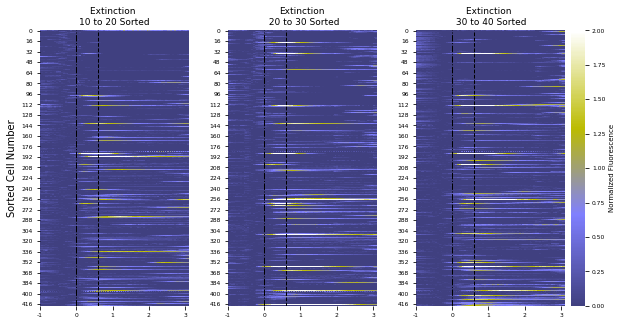

In [223]:
#Plotting for Figure Generation (Figure 2Cii - Day 5 Last Day and Extinction Comparisons)
#aliTraceBlocks should come from aliMatched, not matched traces in the section "Make Temporal Blocks for Averaged Plots"
#Fixed Plot Parameters
cmax = 2
cmin = 0
start_ind=20 #40
end_ind=32 #52
sort_start=40 #40
sort_end=52 #80
#Font Details
label_size=7
tick_size=6
title_size=9
#Make Plots
fig, all_ax = plt.subplots(figsize=(9, 5.1), nrows=1, ncols=3) #(5, 2.5)

#First Plot
sel_ax1 = all_ax[0]
Nfirst=10
Ntrials=20
block_df=aliTraceBlocks['ali26_d5_s2'].loc[:, aliTraceBlocks['ali26_d5_s2'].columns.get_level_values('trial').isin(range(Nfirst,Ntrials))]
cur_block4=block_df.groupby(level=['cell_num'], axis=1).mean()
bef_interval_mean =cur_block4.loc[28:39,:].mean(axis=0)
cur_block4=cur_block4-bef_interval_mean
cur_sorted4 = cur_block4.loc[20:101,sort_inds1]
cur_sorted4.columns = cur_sorted1.columns
#ur_block1 = aliBlockAverages['ali24_d5_s1']
 #Renumber Columns
sns.heatmap(cur_sorted4.T, ax=sel_ax1, vmin=cmin, vmax=cmax, cbar=False, cmap=topgist_cm)
sel_ax1.axvline(x=start_ind, linestyle='-.', color='k', linewidth=1)
sel_ax1.axvline(x=end_ind, linestyle='--', color='k', linewidth=1)
sel_ax1.set_xticks(range(0,81,20))
sel_ax1.set_xticklabels(range(-1,4,1), rotation=0)
sel_ax1.tick_params(labelsize=tick_size)
sel_ax1.set_xlabel('', fontsize=label_size, labelpad=1)
#sel_ax1.set_xlabel('Time (sec)', fontsize=label_size, labelpad=1)
sel_ax1.set_ylabel('Sorted Cell Number')
sel_ax1.set_title('Extinction \n10 to 20 Sorted', fontsize=title_size)
sel_ax1.set_position([0.1, 0.125, 0.23, 0.75])

#Middle Plot
sel_ax2 = all_ax[1]
Nfirst=20
Ntrials = 30
block_df=aliTraceBlocks['ali26_d5_s2'].loc[:, aliTraceBlocks['ali26_d5_s2'].columns.get_level_values('trial').isin(range(Nfirst,Ntrials))]
cur_block5=block_df.groupby(level=['cell_num'], axis=1).mean()
bef_interval_mean =cur_block5.loc[28:39,:].mean(axis=0)
cur_block5=cur_block5-bef_interval_mean
cur_sorted5 = cur_block5.loc[20:101,sort_inds1]
cur_sorted5.columns = cur_sorted1.columns
#Renumber Columns to match First
sns.heatmap(cur_sorted5.T, ax=sel_ax2, vmin=cmin, vmax=cmax, cbar=False, cmap=topgist_cm)
sel_ax2.axvline(x=start_ind, linestyle='-.', color='k', linewidth=1)
sel_ax2.axvline(x=end_ind, linestyle='--', color='k', linewidth=1)
sel_ax2.set_xticks(range(0,81,20))
sel_ax2.set_xticklabels(range(-1,4,1), rotation=0)
sel_ax2.tick_params(labelsize=tick_size)
sel_ax2.set_xlabel('', fontsize=label_size, labelpad=1)
#sel_ax2.set_xlabel('Time (sec)', fontsize=label_size, labelpad=1)
sel_ax2.set_title('Extinction\n 20 to 30 Sorted', fontsize=title_size)
sel_ax2.set_position([0.39, 0.125, 0.23, 0.75])

#Last Plot
sel_ax3 = all_ax[2]
Nfirst=30
Ntrials = 40
block_df=aliTraceBlocks['ali26_d5_s2'].loc[:, aliTraceBlocks['ali26_d5_s2'].columns.get_level_values('trial').isin(range(Nfirst,Ntrials))]
cur_block6=block_df.groupby(level=['cell_num'], axis=1).mean()
bef_interval_mean =cur_block6.loc[28:39,:].mean(axis=0)
cur_block6=cur_block6-bef_interval_mean
cur_sorted6 = cur_block6.loc[20:101,sort_inds1]
cur_sorted6.columns = cur_sorted1.columns
sns.heatmap(cur_sorted6.T, ax=sel_ax3, vmin=cmin, vmax=cmax, cmap=topgist_cm)
sel_ax3.axvline(x=start_ind, linestyle='-.', color='k', linewidth=1)
sel_ax3.axvline(x=end_ind, linestyle='--', color='k', linewidth=1)
sel_ax3.set_xticks(range(0,81,20))
sel_ax3.set_xticklabels(range(-1,4,1), rotation=0)
sel_ax3.tick_params(labelsize=tick_size)
sel_ax3.set_xlabel('', fontsize=label_size, labelpad=1)
#sel_ax3.set_xlabel('Time (sec)', fontsize=label_size, labelpad=1)
sel_ax3.set_title('Extinction \n 30 to 40 Sorted', fontsize=title_size)
sel_ax3.set_position([0.68, 0.125, 0.23, 0.75])

#Colorbar Font Sizing
cbar_axes=fig.axes[3]
cbar_axes.tick_params(labelsize=tick_size)
cbar_axes.set_ylabel('Normalized Fluorescence', fontsize=label_size)
cbar_axes.set_position([0.92, 0.125, 0.08, 0.75])
#plt.savefig('ali26_d5_CSsorted_30and40_subtracted_1to3.png', bbox_inches='tight', format='png', dpi=1200, transparent=True)
plt.savefig('ali26_d5_CSsorted_30and40_subtracted_1to3.eps', format='eps')

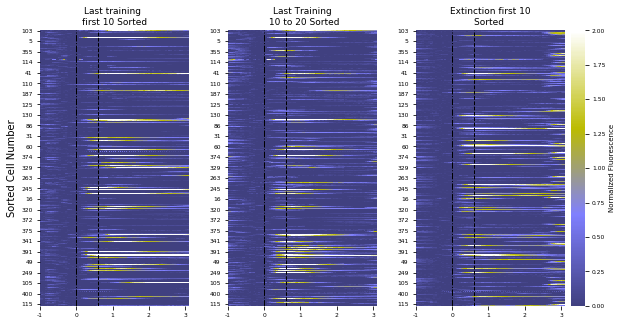

In [224]:
#Fixed Plo1.5 Parameters
cmax = 2
cmin = 0
start_ind=20 #40
end_ind=32 #52
sort_start=40 #40
sort_end=52 #80
#Font Details
label_size=7
tick_size=6
title_size=9
#Make Plo
fig, all_ax = plt.subplots(figsize=(9, 5.1), nrows=1, ncols=3)
Nfirst=10
block_df=aliTraceBlocks['ali26_d5_s1'].loc[:, aliTraceBlocks['ali26_d5_s1'].columns.get_level_values('trial').isin(range(Nfirst))]
cur_block1=block_df.groupby(level=['cell_num'], axis=1).mean()
bef_interval_mean =cur_block1.loc[28:39,:].mean(axis=0)
cur_block1=cur_block1-bef_interval_mean
#cur_block1 = aliBlockAverages['ali24_d5_s1']
sort_inds1=np.argsort(cur_block1.loc[sort_start:sort_end,:].mean())
cur_sorted1 = cur_block1.loc[:,sort_inds1]
cur_sorted1.columns = range(cur_block1.shape[1])

Nfirst=30
Ntrials=40
block_df=aliTraceBlocks['ali26_d5_s2'].loc[:, aliTraceBlocks['ali26_d5_s2'].columns.get_level_values('trial').isin(range(Nfirst,Ntrials))]
cur_block2=block_df.groupby(level=['cell_num'], axis=1).mean()
bef_interval_mean =cur_block2.loc[28:39,:].mean(axis=0)
cur_block2=cur_block2-bef_interval_mean
cur_sorted2 = cur_block2.loc[20:101,sort_inds1]
cur_sorted2.columns = cur_sorted1.columns

sort_inds2 = np.argsort(cur_sorted2.loc[sort_start:sort_end,:].mean())
cur_sorted7 = cur_sorted2.loc[:,sort_inds2]


#First Plot
sel_ax1 = all_ax[0]

Nfirst=10

block_df=aliTraceBlocks['ali26_d5_s1'].loc[:, aliTraceBlocks['ali26_d5_s1'].columns.get_level_values('trial').isin(range(Nfirst))]
cur_block12=block_df.groupby(level=['cell_num'], axis=1).mean()
bef_interval_mean =cur_block12.loc[28:39,:].mean(axis=0)
cur_block12=cur_block12-bef_interval_mean
cur_sorted12 = cur_block12.loc[20:101,sort_inds2]
cur_sorted12.columns = cur_sorted7.columns #Renumber Columns to match First
sns.heatmap(cur_sorted12.T, ax=sel_ax1, vmin=cmin, vmax=cmax, cbar=False, cmap=topgist_cm)
sel_ax1.axvline(x=start_ind, linestyle='-.', color='k', linewidth=1)
sel_ax1.axvline(x=end_ind, linestyle='--', color='k', linewidth=1)
sel_ax1.set_xticks(range(0,81,20))
sel_ax1.set_xticklabels(range(-1,4,1), rotation=0)
sel_ax1.tick_params(labelsize=tick_size)
sel_ax1.set_xlabel('', fontsize=label_size, labelpad=1)
#sel_ax1.set_xlabel('Time (sec)', fontsize=label_size, labelpad=1)
sel_ax1.set_ylabel('Sorted Cell Number')
sel_ax1.set_title('Last training \nfirst 10 Sorted', fontsize=title_size)
sel_ax1.set_position([0.1, 0.125, 0.23, 0.75])

# Second plot 
sel_ax2 = all_ax[1]
Nfirst=10
Ntrials = 20
block_df=aliTraceBlocks['ali26_d5_s1'].loc[:, aliTraceBlocks['ali26_d5_s1'].columns.get_level_values('trial').isin(range(Nfirst,Ntrials))]
cur_block2=block_df.groupby(level=['cell_num'], axis=1).mean()
bef_interval_mean =cur_block2.loc[28:39,:].mean(axis=0)
cur_block2=cur_block2-bef_interval_mean
cur_sorted2 = cur_block2.loc[20:101,sort_inds2]
cur_sorted2.columns = cur_sorted7.columns #Renumber Columns to match First
sns.heatmap(cur_sorted2.T, ax=sel_ax2, vmin=cmin, vmax=cmax, cbar=False, cmap=topgist_cm)
sel_ax2.axvline(x=start_ind, linestyle='-.', color='k', linewidth=1)
sel_ax2.axvline(x=end_ind, linestyle='--', color='k', linewidth=1)
sel_ax2.set_xticks(range(0,81,20))
sel_ax2.set_xticklabels(range(-1,4,1), rotation=0)
sel_ax2.tick_params(labelsize=tick_size)
sel_ax2.set_xlabel('', fontsize=label_size, labelpad=1)
#sel_ax2.set_xlabel('Time (sec)', fontsize=label_size, labelpad=1)
sel_ax2.set_title('Last Training\n 10 to 20 Sorted', fontsize=title_size)
sel_ax2.set_position([0.39, 0.125, 0.23, 0.75])

# Third plot


#Last Plot
sel_ax3 = all_ax[2]
Nfirst=10
block_df=aliTraceBlocks['ali26_d5_s2'].loc[:, aliTraceBlocks['ali26_d5_s2'].columns.get_level_values('trial').isin(range(Nfirst))]
cur_block3=block_df.groupby(level=['cell_num'], axis=1).mean()
bef_interval_mean =cur_block3.loc[28:39,:].mean(axis=0)
cur_block3=cur_block3-bef_interval_mean
cur_sorted3 = cur_block3.loc[20:101,sort_inds2]
cur_sorted3.columns = cur_sorted7.columns
sns.heatmap(cur_sorted3.T, ax=sel_ax3, vmin=cmin, vmax=cmax, cmap=topgist_cm)
sel_ax3.axvline(x=start_ind, linestyle='-.', color='k', linewidth=1)
sel_ax3.axvline(x=end_ind, linestyle='--', color='k', linewidth=1)
sel_ax3.set_xticks(range(0,81,20))
sel_ax3.set_xticklabels(range(-1,4,1), rotation=0)
sel_ax3.tick_params(labelsize=tick_size)
sel_ax3.set_xlabel('', fontsize=label_size, labelpad=1)
#sel_ax3.set_xlabel('Time (sec)', fontsize=label_size, labelpad=1)
sel_ax3.set_title('Extinction first 10\nSorted ', fontsize=title_size)
sel_ax3.set_position([0.68, 0.125, 0.23, 0.75])

#Colorbar Font Sizing
cbar_axes=fig.axes[3]
cbar_axes.tick_params(labelsize=tick_size)
cbar_axes.set_ylabel('Normalized Fluorescence', fontsize=label_size)
cbar_axes.set_position([0.92, 0.125, 0.08, 0.75])
#plt.savefig('ali26_d5_EX_sorted_10and20_subtracted_-1to3_correct.png', bbox_inches='tight', format='png', dpi=1400, transparent=True)
plt.savefig('ali26_d5_EX_sorted_10and20_subtracted_-1to3_correct.eps',format='eps')

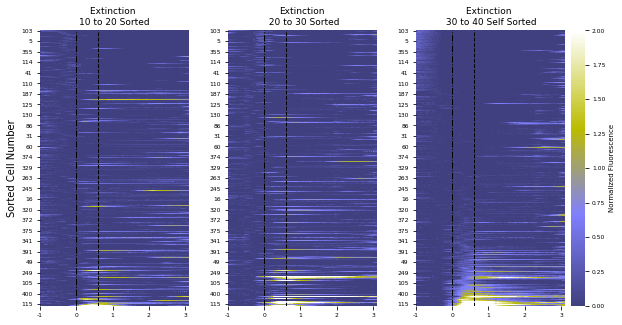

In [225]:
#Plotting for Figure Generation (Figure 2Cii - Day 5 Last Day and Extinction Comparisons)
#aliTraceBlocks should come from aliMatched, not matched traces in the section "Make Temporal Blocks for Averaged Plots"
#Fixed Plot Parameters
cmax = 2
cmin = 0
start_ind=20 #40
end_ind=32 #52
sort_start=40 #40
sort_end=52 #80
#Font Details
label_size=7
tick_size=6
title_size=9
#Make Plots
fig, all_ax = plt.subplots(figsize=(9, 5.1), nrows=1, ncols=3) #(5, 2.5)
Nfirst=10
block_df=aliTraceBlocks['ali26_d5_s1'].loc[:, aliTraceBlocks['ali26_d5_s1'].columns.get_level_values('trial').isin(range(Nfirst))]
cur_block1=block_df.groupby(level=['cell_num'], axis=1).mean()
bef_interval_mean =cur_block1.loc[28:39,:].mean(axis=0)
cur_block1=cur_block1-bef_interval_mean
#cur_block1 = aliBlockAverages['ali24_d5_s1']
sort_inds1=np.argsort(cur_block1.loc[sort_start:sort_end,:].mean())
cur_sorted1 = cur_block1.loc[:,sort_inds1]
cur_sorted1.columns = range(cur_block1.shape[1])

Nfirst=30
Ntrials=40
block_df=aliTraceBlocks['ali26_d5_s2'].loc[:, aliTraceBlocks['ali26_d5_s2'].columns.get_level_values('trial').isin(range(Nfirst,Ntrials))]
cur_block2=block_df.groupby(level=['cell_num'], axis=1).mean()
bef_interval_mean =cur_block2.loc[28:39,:].mean(axis=0)
cur_block2=cur_block2-bef_interval_mean
cur_sorted2 = cur_block2.loc[20:101,sort_inds1]
cur_sorted2.columns = cur_sorted1.columns

sort_inds2 = np.argsort(cur_sorted2.loc[sort_start:sort_end,:].mean())
cur_sorted7 = cur_sorted2.loc[:,sort_inds2]

#First Plot
sel_ax1 = all_ax[0]
Nfirst=30
Ntrials=40
block_df=aliTraceBlocks['ali26_d5_s2'].loc[:, aliTraceBlocks['ali26_d5_s2'].columns.get_level_values('trial').isin(range(Nfirst,Ntrials))]
cur_block2=block_df.groupby(level=['cell_num'], axis=1).mean()
bef_interval_mean =cur_block2.loc[28:39,:].mean(axis=0)
cur_block2=cur_block2-bef_interval_mean
sort_inds2 = np.argsort(cur_block2.loc[sort_start:sort_end,:].mean())
cur_sorted1 = cur_block2.loc[20:101,sort_inds2]
Nfirst=10
Ntrials=20
block_df=aliTraceBlocks['ali26_d5_s2'].loc[:, aliTraceBlocks['ali26_d5_s2'].columns.get_level_values('trial').isin(range(Nfirst,Ntrials))]
cur_block4=block_df.groupby(level=['cell_num'], axis=1).mean()
bef_interval_mean =cur_block4.loc[28:39,:].mean(axis=0)
cur_block4=cur_block4-bef_interval_mean
cur_sorted4 = cur_block4.loc[20:101,sort_inds2]
cur_sorted4.columns = cur_sorted7.columns
#ur_block1 = aliBlockAverages['ali24_d5_s1']
 #Renumber Columns
sns.heatmap(cur_sorted4.T, ax=sel_ax1, vmin=cmin, vmax=cmax, cbar=False, cmap=topgist_cm)
sel_ax1.axvline(x=start_ind, linestyle='-.', color='k', linewidth=1)
sel_ax1.axvline(x=end_ind, linestyle='--', color='k', linewidth=1)
sel_ax1.set_xticks(range(0,81,20))
sel_ax1.set_xticklabels(range(-1,4,1), rotation=0)
sel_ax1.tick_params(labelsize=tick_size)
sel_ax1.set_xlabel('', fontsize=label_size, labelpad=1)
#sel_ax1.set_xlabel('Time (sec)', fontsize=label_size, labelpad=1)
sel_ax1.set_ylabel('Sorted Cell Number')
sel_ax1.set_title('Extinction \n10 to 20 Sorted', fontsize=title_size)
sel_ax1.set_position([0.1, 0.125, 0.23, 0.75])

#Middle Plot
sel_ax2 = all_ax[1]
Nfirst=20
Ntrials = 30
block_df=aliTraceBlocks['ali26_d5_s2'].loc[:, aliTraceBlocks['ali26_d5_s2'].columns.get_level_values('trial').isin(range(Nfirst,Ntrials))]
cur_block5=block_df.groupby(level=['cell_num'], axis=1).mean()
bef_interval_mean =cur_block5.loc[28:39,:].mean(axis=0)
cur_block5=cur_block5-bef_interval_mean
cur_sorted5 = cur_block5.loc[20:101,sort_inds2]
cur_sorted5.columns = cur_sorted7.columns
#Renumber Columns to match First
sns.heatmap(cur_sorted5.T, ax=sel_ax2, vmin=cmin, vmax=cmax, cbar=False, cmap=topgist_cm)
sel_ax2.axvline(x=start_ind, linestyle='-.', color='k', linewidth=1)
sel_ax2.axvline(x=end_ind, linestyle='--', color='k', linewidth=1)
sel_ax2.set_xticks(range(0,81,20))
sel_ax2.set_xticklabels(range(-1,4,1), rotation=0)
sel_ax2.tick_params(labelsize=tick_size)
sel_ax2.set_xlabel('', fontsize=label_size, labelpad=1)
#sel_ax2.set_xlabel('Time (sec)', fontsize=label_size, labelpad=1)
sel_ax2.set_title('Extinction\n 20 to 30 Sorted', fontsize=title_size)
sel_ax2.set_position([0.39, 0.125, 0.23, 0.75])

#Last Plot
sel_ax3 = all_ax[2]
Nfirst=30
Ntrials = 40
block_df=aliTraceBlocks['ali26_d5_s2'].loc[:, aliTraceBlocks['ali26_d5_s2'].columns.get_level_values('trial').isin(range(Nfirst,Ntrials))]
cur_block6=block_df.groupby(level=['cell_num'], axis=1).mean()
bef_interval_mean =cur_block6.loc[28:39,:].mean(axis=0)
cur_block6=cur_block6-bef_interval_mean
cur_sorted6 = cur_block6.loc[20:101,sort_inds2]
cur_sorted6.columns = cur_sorted7.columns
sns.heatmap(cur_sorted6.T, ax=sel_ax3, vmin=cmin, vmax=cmax, cmap=topgist_cm)
sel_ax3.axvline(x=start_ind, linestyle='-.', color='k', linewidth=1)
sel_ax3.axvline(x=end_ind, linestyle='--', color='k', linewidth=1)
sel_ax3.set_xticks(range(0,81,20))
sel_ax3.set_xticklabels(range(-1,4,1), rotation=0)
sel_ax3.tick_params(labelsize=tick_size)
sel_ax3.set_xlabel('', fontsize=label_size, labelpad=1)
#sel_ax3.set_xlabel('Time (sec)', fontsize=label_size, labelpad=1)
sel_ax3.set_title('Extinction \n 30 to 40 Self Sorted', fontsize=title_size)
sel_ax3.set_position([0.68, 0.125, 0.23, 0.75])

#Colorbar Font Sizing
cbar_axes=fig.axes[3]
cbar_axes.tick_params(labelsize=tick_size)
cbar_axes.set_ylabel('Normalized Fluorescence', fontsize=label_size)
cbar_axes.set_position([0.92, 0.125, 0.08, 0.75])
#plt.savefig('ali26_d5_EX_sorted_30and40_subtracted_-1to3.png', bbox_inches='tight', format='png', dpi=1200, transparent=True)
plt.savefig('ali26_d5_EX_sorted_30and40_subtracted_-1to3.eps', format='eps')

Text(0.5, 1.0, 'Extinction Session')

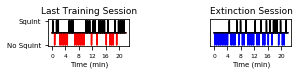

In [226]:
#Plotting for Figure Generation (Figure 2Ci - Day 5 Last Day and Extinction Behavior Comparisons)
#Fixed Plot Parameters
#Font Details
label_size=7
tick_size=6
title_size=9
#Make Plots
fig, all_ax = plt.subplots(figsize=(4.5, 0.5), nrows=1, ncols=2) #(4.5, 0.5)
#Initialize Data for Making Traces
trialEdges = aliSounds.apply(findPulses, axis=0)

#Plot 1
mouse='ali24_d5_s1'
curMouse_df = binaryTrialTrace(trialEdges[mouse], aliBehaviorScoring[mouse], mouse)
no_blink_color = 'r'
sel_ax1 = all_ax[0]
sel_ax1.plot(curMouse_df.loc[:,(mouse,'NoBlink')], no_blink_color)
sel_ax1.plot(curMouse_df.loc[:,(mouse,'Blink')], 'k')
sel_ax1.set_xticks(range(0, 24001, 4800))
sel_ax1.set_xticklabels(range(0, 21, 4), fontsize=tick_size)
sel_ax1.set_xlabel('Time (min)', labelpad=2, fontsize=label_size)
sel_ax1.set_yticks([-1, 1])
sel_ax1.set_yticklabels(['No Squint', 'Squint'], fontsize=label_size)
sel_ax1.set_position([.05, .125, .25, .75])
sel_ax1.set_title('Last Training Session', fontsize=title_size)

#Plot 2
mouse='ali24_d5_s2'
curMouse_df = binaryTrialTrace(trialEdges[mouse], aliBehaviorScoring[mouse], mouse)
no_blink_color = 'b'
sel_ax2 = all_ax[1]
sel_ax2.plot(curMouse_df.loc[:,(mouse,'NoBlink')], no_blink_color)
sel_ax2.plot(curMouse_df.loc[:,(mouse,'Blink')], 'k')
sel_ax2.set_xticks(range(0, 24001, 4800))
sel_ax2.set_xticklabels(range(0, 21, 4), fontsize=tick_size)
sel_ax2.set_xlabel('Time (min)', labelpad=2, fontsize=label_size)
sel_ax2.set_yticks([])
sel_ax2.set_position([.55, .125, .25, .75])
sel_ax2.set_title('Extinction Session', fontsize=title_size)
#plt.tight_layout()
#plt.savefig('ali24_d5_BehaviorComparison.png', bbox_inches='tight', format='png', dpi=1200, transparent=True)

In [227]:
#Loading ROI Data for Figure 3
#Selected Mice Case - Day 5 - Last Day & Extinction
selMouse, selDay, selSess = [[24], [5], [1,2]]
#Load ROI Data for Figure 3B
selFolders, selFilenames = makeAliFilenames(selMouse, selDay, selSess)
selFiles = combineFilenames(aliBase, selFolders, selFilenames)
#Load ROI Masks
print('Loading ROIs')
roiColors, roiArrays = loadSelROIs(selFiles)
roiArrayDF = pd.concat(roiArrays,axis=1)
print(roiArrayDF.columns.unique('mouse'))

#Match ROI Arrays
aliMatchROIs = matchCellMap(roiArrayDF, aliMatchInds)

Loading ROIs
Loading ROIs for ali24_d5_s1
Loading ROIs for ali24_d5_s2
Index(['ali24_d5_s1', 'ali24_d5_s2'], dtype='object', name='mouse')
ali24_d5_s1
ali24_d5_s2


In [230]:
# From the event detection final notebook
firstf="Active_Cells_ali24.h5"
f = h5py.File(firstf, 'r')
print(f.keys())
ali24_Last_Inc_Cells=np.array(f['CS_cells'])
ali24_Ext_Inc_Cells =np.array(f['EX_cells'])

<KeysViewHDF5 ['CS_cells', 'EX_cells']>


In [231]:
# From the event detection final notebook
firstf="Active_Cells_ali26.h5"
f = h5py.File(firstf, 'r')
print(f.keys())
ali26_Last_Inc_Cells=np.array(f['CS_cells'])
ali26_Ext_Inc_Cells =np.array(f['EX_cells'])

<KeysViewHDF5 ['CS_cells', 'EX_cells']>


In [232]:
#Match up ROIs and select only overlapping
#Create Projection Images
allRoisLast = (aliMatchROIs['ali24_d5_s1'].groupby(level='pixel_num',axis=1).sum() > 0).astype(int)
for cell in ali24_Last_Inc_Cells:
    allRoisLast += aliMatchROIs['ali24_d5_s1',cell].astype(int)

allRoisExt = (aliMatchROIs['ali24_d5_s2'].groupby(level='pixel_num',axis=1).sum() > 0).astype(int)
for cell in ali24_Ext_Inc_Cells:
    allRoisExt += aliMatchROIs['ali24_d5_s2',cell].astype(int)

In [233]:
#Make LinearSegmentedColormap for ROI Extent Plotting
#clrsLast = [[0.95,0.95,0.95], [.13,0.8,.13], [1,.1,.1]]
clrsLast = [[1,1,1], [.4,0.4,.4], [1,.1,.1]]
cmLast = LinearSegmentedColormap.from_list('spatialLast', clrsLast, N=3)
#clrsExt = [[0.95,0.95,0.95], [.13,0.8,.13], [0,.4,1]]
clrsExt = [[1,1,1], [.4,0.4,.4], [0,.4,1]]
cmExt = LinearSegmentedColormap.from_list('spatialExt', clrsExt, N=3)

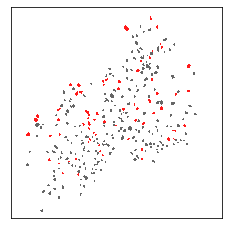

In [234]:
#Plotting for Figure Generation (Figure 3B - Spatial Map of CS Cells)
fig = plt.figure(figsize=(3,3)) #(3,3)
ax = fig.add_axes([0.01, 0.01, 0.98, 0.98])
sns.heatmap(allRoisLast, cmap=cmLast, cbar=False, ax=ax)
#ax.axis('off')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)
#plt.savefig('CSCellMapCorrectSort.png', format='png', dpi=1200, transparent=True)
plt.savefig('CSCellMapCorrectSort.eps', format='eps')

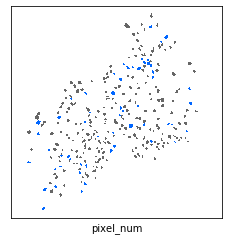

In [235]:
#Plotting for Figure Generation (Figure 3D - Spatial Map of EX Cells)
fig = plt.figure(figsize=(3,3)) #(3,3)
ax = fig.add_axes([0.01, 0.01, 0.98, 0.98])
sns.heatmap(allRoisExt, cmap=cmExt, cbar=False, ax=ax)
#ax.axis('off')
ax.set_xticks([])
ax.set_yticks([])
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.savefig('EXCellMapCorrectSort.eps', format='eps')
#plt.savefig('EXCellMap.png', format='png', dpi=1200, transparent=True)

In [236]:
def singleCellFigureTrialPlot(block_df, behav_df, last_sess, extinct_sess, cell_choice, title_prefix, lblpad=0, ypeak=None, cmapChoice=plt.get_cmap("bwr")):
    #From one cell identity, plot that cell across all trials, in addition to plotting the matched session/trials
    #Parameters for Plot
    trial=0
    step=10
    sound_ind=20
    sound_diff = 7
    puff_ind=32
    puff_diff = 2
    strtInd = 20
    endInd = 81
    xtickInds = np.arange(0, 61, 20)
    xtickLabels = np.arange(-1, 2.1, 1).astype(np.int)
    Ntrials=block_df.columns.unique('trial').shape[0]
    Ngroups = Ntrials//step
    #Font Details
    title_size=8
    label_size=7
    tick_size=6
    #Parameters for Axes
    if ypeak==None:
        ypeak = np.ceil(block_df.loc(axis=1)[last_sess, :, cell_choice].max().max())
    yfloor = np.floor(block_df.loc(axis=1)[last_sess, :, cell_choice].min().min())
    #Setup Plot Grids
    fig = plt.figure(figsize=(5, 3)) #(5,3) for saving figure
    #fig.tight_layout()
    gs_left = plt.GridSpec(Ngroups, 1)
    gs_center = plt.GridSpec(1, 2)
    gs_behav = plt.GridSpec(1, 2)
    gs_cbar = plt.GridSpec(1,1)
    gs_right = plt.GridSpec(Ngroups, 1)
    ax_col1 = []; ax_col4 = [];
    for idx in np.arange(0,Ngroups):
        ax_col1.append(fig.add_subplot(gs_left[idx,0]))
        ax_col4.append(fig.add_subplot(gs_right[idx,0]))
    ax_col2 = fig.add_subplot(gs_center[0, 0])
    ax_col3 = fig.add_subplot(gs_center[0, 1])
    ax_behav1 = fig.add_subplot(gs_behav[0, 0])
    ax_behav2 = fig.add_subplot(gs_behav[0, 1])
    ax_cbar = fig.add_subplot(gs_cbar[0,0])
    #Update Extents of Plot Grids
    gs_left.update(left=0.08, right=0.22, wspace=0.05, hspace=0.05)
    gs_center.update(left=0.29, right=0.7, wspace=0.12, hspace=0.05)
    gs_behav.update(left=0.487, right=0.503, wspace=0.5, hspace=0.05)
    gs_cbar.update(left=0.71, right=0.72)
    gs_right.update(left=0.78, right=0.92, wspace=0.05, hspace=0.05)
    #Do Outside Column Plots
    for idx, c in enumerate(zip(ax_col1, ax_col4)):
        #Loop Through and Plot each Trace
        for tr in np.arange(trial,trial+step):
            c[0].plot(block_df.loc(axis=0)[strtInd:endInd].loc(axis=1)[last_sess, tr, cell_choice].reset_index(drop=True), color=[0.5,0.5,0.5])
            c[1].plot(block_df.loc(axis=0)[strtInd:endInd].loc(axis=1)[extinct_sess, tr, cell_choice].reset_index(drop=True), color=[0.5,0.5,0.5])
        #Calculate Average
        plt_mean = []
        plt_mean.append(block_df.loc(axis=0)[strtInd:endInd].loc(axis=1)[last_sess, trial:(trial+step), cell_choice].mean(axis=1).reset_index(drop=True))
        plt_mean.append(block_df.loc(axis=0)[strtInd:endInd].loc(axis=1)[extinct_sess, trial:(trial+step), cell_choice].mean(axis=1).reset_index(drop=True))
        #Loop Through Each Axes for all Plots
        for val, c_sel in enumerate(c):
            #Mean Plotting
            c_sel.plot(plt_mean[val], color=[1,0,0])
            #Set Axes Parameters
            plt.sca(c_sel)
            plt.xticks(xtickInds, xtickLabels, rotation=0, fontsize=tick_size)
            plt.yticks(np.arange(0,ypeak,5), np.arange(0,ypeak,5).astype(int), rotation=0, fontsize=tick_size)
            c_sel.set_ylim([yfloor,ypeak])
            c_sel.set_ylabel('Trial {}-{}'.format(trial+1, trial+step), fontsize=tick_size, labelpad=lblpad)
            c_sel.tick_params(labelsize=tick_size)
            if val == 1: #Second Column
                c_sel.yaxis.tick_right()
                c_sel.yaxis.set_label_position('right')
            if idx != (Ntrials/step)-1:
                c_sel.tick_params(axis='x',bottom=False,labelbottom=False,labelsize=tick_size)
            if idx == (Ntrials/step)-1:
                c_sel.set_xlabel('Time (sec)', fontsize=label_size)
            #Add Tone-Puff Color Patches
            tone_patch = patches.Rectangle((sound_ind,yfloor), sound_diff, ypeak-yfloor, color=[1,0,1,0.25])
            puff_patch = patches.Rectangle((puff_ind,yfloor), puff_diff, ypeak-yfloor, color=[1,0.65,0,0.25])
            c_sel.add_patch(tone_patch)
            c_sel.add_patch(puff_patch)
        trial+=step
    fig.text(0.01, 0.5, 'Normalized Fluorescence', fontsize=label_size, va='center', ha='center', rotation=90)
    fig.text(0.99, 0.5, 'Normalized Fluorescence', fontsize=label_size, va='center', ha='center', rotation=90)
    #Do Inner Trial Plots
    #Setup Center Trial Y-Axes
    trial_ticks = np.arange(-1, Ntrials+.1, step).astype(np.int)+0.5 #Ticks along Y Axis
    np.put(trial_ticks,0,0.5) #Adjust first index to be for first row, rather than -1
    trial_labels = np.arange(0, Ntrials+.1, step).astype(np.int) #Tick Labels along y axis
    np.put(trial_labels,0,1) #Put first index at Beginning, rather than 0
    #Plot First Set
    sns.heatmap(block_df.loc(axis=0)[strtInd:endInd].loc(axis=1)[last_sess,:,cell_choice].T, vmin=0, vmax=ypeak, cmap=cmapChoice, ax=ax_col2, cbar=False);
    plt.sca(ax_col2)
    plt.xticks(xtickInds, xtickLabels, rotation=0, fontsize=tick_size)
    plt.yticks(trial_ticks, trial_labels, rotation=0, fontsize=tick_size)
    ax_col2.axvline(x=sound_ind, linestyle='--', color='k')
    ax_col2.axvline(x=puff_ind, linestyle=':', color='k')
    ax_col2.set_xlabel('Time (sec)', fontsize=label_size)
    ax_col2.set_ylabel('Trial Number', fontsize=label_size, labelpad=1)
    ax_col2.set_title(title_prefix+'Last Session', fontsize=title_size)
    #Plot Second Set
    sns.heatmap(block_df.loc(axis=0)[strtInd:endInd].loc(axis=1)[extinct_sess,:,cell_choice].T, vmin=0, vmax=ypeak, cmap=cmapChoice, ax=ax_col3, cbar=True, cbar_ax=ax_cbar);
    plt.sca(ax_col3)
    plt.xticks(xtickInds, xtickLabels, rotation=0, fontsize=tick_size)
    plt.yticks([])
    ax_col3.axvline(x=sound_ind, linestyle='--', color='k')
    ax_col3.axvline(x=puff_ind, linestyle=':', color='k')
    ax_col3.set_xlabel('Time (sec)', fontsize=label_size)
    ax_col3.set_ylabel('')
    ax_col3.set_title(title_prefix+'Extinction', fontsize=title_size)
    #Color Bar
    ax_cbar.tick_params(labelsize=tick_size)
    #Plot Behavior Stuff
    lastScore, lastCM = getTrialScorePlots(behav_df[last_sess], (1,0,0), (0,0,0), nameCM='lastTraining')
    extinctScore, extinctCM = getTrialScorePlots(behav_df[extinct_sess], (0,0,1), (0,0,0), nameCM='extinction')
    #Behavior Session 1
    sns.heatmap(lastScore, vmin=0, vmax=1, cmap=lastCM, ax=ax_behav1, cbar=False)
    plt.sca(ax_behav1)
    plt.xticks([])
    plt.yticks([])
    #Behavior Session 2
    sns.heatmap(extinctScore, vmin=0, vmax=1, cmap=extinctCM, ax=ax_behav2, cbar=False)
    plt.sca(ax_behav2)
    plt.xticks([])
    plt.yticks([])

In [237]:
def singleCellFigureTrialPlot_last20(block_df, behav_df, last_sess, extinct_sess, cell_choice, title_prefix, lblpad=0, ypeak=None, cmapChoice=plt.get_cmap("bwr")):
    #From one cell identity, plot that cell across all trials, in addition to plotting the matched session/trials
    #Parameters for Plot
    trial=0
    step=10
    sound_ind=20
    sound_diff = 7
    puff_ind=32
    puff_diff = 2
    strtInd = 20
    endInd = 81
    xtickInds = np.arange(0, 61, 20)
    xtickLabels = np.arange(-1, 2.1, 1).astype(np.int)
    Ntrials=block_df.columns.unique('trial').shape[0]
    Ngroups = Ntrials//step
    #Font Details
    title_size=8
    label_size=7
    tick_size=6
    #Parameters for Axes
    if ypeak==None:
        ypeak = np.ceil(block_df.loc(axis=1)[last_sess, :, cell_choice].max().max())
    yfloor = np.floor(block_df.loc(axis=1)[last_sess, :, cell_choice].min().min())
    #Setup Plot Grids
    fig = plt.figure(figsize=(5, 3)) #(5,3) for saving figure
    #fig.tight_layout()
    gs_left = plt.GridSpec(Ngroups, 1)
    gs_center = plt.GridSpec(1, 2)
    gs_behav = plt.GridSpec(1, 2)
    gs_cbar = plt.GridSpec(1,1)
    gs_right = plt.GridSpec(Ngroups, 1)
    ax_col1 = []; ax_col4 = [];
    for idx in np.arange(0,Ngroups):
        ax_col1.append(fig.add_subplot(gs_left[idx,0]))
        ax_col4.append(fig.add_subplot(gs_right[idx,0]))
    ax_col2 = fig.add_subplot(gs_center[0, 0])
    ax_col3 = fig.add_subplot(gs_center[0, 1])
    ax_behav1 = fig.add_subplot(gs_behav[0, 0])
    ax_behav2 = fig.add_subplot(gs_behav[0, 1])
    ax_cbar = fig.add_subplot(gs_cbar[0,0])
    #Update Extents of Plot Grids
    gs_left.update(left=0.08, right=0.22, wspace=0.05, hspace=0.05)
    gs_center.update(left=0.29, right=0.7, wspace=0.12, hspace=0.05)
    gs_behav.update(left=0.487, right=0.503, wspace=0.5, hspace=0.05)
    gs_cbar.update(left=0.71, right=0.72)
    gs_right.update(left=0.78, right=0.92, wspace=0.05, hspace=0.05)
    #Do Outside Column Plots
    for idx, c in enumerate(zip(ax_col1, ax_col4)):
        #Loop Through and Plot each Trace
        for tr in np.arange(trial,trial+step):
            c[0].plot(block_df.loc(axis=0)[strtInd:endInd].loc(axis=1)[last_sess, tr, cell_choice].reset_index(drop=True), color=[0.5,0.5,0.5])
            c[1].plot(block_df.loc(axis=0)[strtInd:endInd].loc(axis=1)[extinct_sess, tr, cell_choice].reset_index(drop=True), color=[0.5,0.5,0.5])
        #Calculate Average
        plt_mean = []
        plt_mean.append(block_df.loc(axis=0)[strtInd:endInd].loc(axis=1)[last_sess, trial:(trial+step), cell_choice].mean(axis=1).reset_index(drop=True))
        plt_mean.append(block_df.loc(axis=0)[strtInd:endInd].loc(axis=1)[extinct_sess, trial:(trial+step), cell_choice].mean(axis=1).reset_index(drop=True))
        #Loop Through Each Axes for all Plots
        for val, c_sel in enumerate(c):
            #Mean Plotting
            c_sel.plot(plt_mean[val], color=[1,0,0])
            #Set Axes Parameters
            plt.sca(c_sel)
            plt.xticks(xtickInds, xtickLabels, rotation=0, fontsize=tick_size)
            plt.yticks(np.arange(0,ypeak,5), np.arange(0,ypeak,5).astype(int), rotation=0, fontsize=tick_size)
            c_sel.set_ylim([yfloor,ypeak])
            c_sel.set_ylabel('Trial {}-{}'.format(trial+1, trial+step), fontsize=tick_size, labelpad=lblpad)
            c_sel.tick_params(labelsize=tick_size)
            if val == 1: #Second Column
                c_sel.yaxis.tick_right()
                c_sel.yaxis.set_label_position('right')
            if idx != (Ntrials/step)-1:
                c_sel.tick_params(axis='x',bottom=False,labelbottom=False,labelsize=tick_size)
            if idx == (Ntrials/step)-1:
                c_sel.set_xlabel('Time (sec)', fontsize=label_size)
            #Add Tone-Puff Color Patches
            tone_patch = patches.Rectangle((sound_ind,yfloor), sound_diff, ypeak-yfloor, color=[1,0,1,0.25])
            puff_patch = patches.Rectangle((puff_ind,yfloor), puff_diff, ypeak-yfloor, color=[1,0.65,0,0.25])
            c_sel.add_patch(tone_patch)
            c_sel.add_patch(puff_patch)
        trial+=step
    fig.text(0.01, 0.5, 'Normalized Fluorescence', fontsize=label_size, va='center', ha='center', rotation=90)
    fig.text(0.99, 0.5, 'Normalized Fluorescence', fontsize=label_size, va='center', ha='center', rotation=90)
    #Do Inner Trial Plots
    #Setup Center Trial Y-Axes
    step1=5
    trial_ticks = np.arange(-1, 20+.1, step1).astype(np.int)+0.5 #Ticks along Y Axis
    np.put(trial_ticks,0,0.5) #Adjust first index to be for first row, rather than -1
    trial_labels = np.arange(0, 20+.1, step1).astype(np.int) #Tick Labels along y axis
    np.put(trial_labels,0,1) #Put first index at Beginning, rather than 0
    #Plot First Set
    sns.heatmap(block_df.loc(axis=0)[strtInd:endInd].loc(axis=1)[last_sess,20:40,cell_choice].T, vmin=0, vmax=ypeak, cmap=cmapChoice, ax=ax_col2, cbar=False);
    plt.sca(ax_col2)
    plt.xticks(xtickInds, xtickLabels, rotation=0, fontsize=tick_size)
    plt.yticks(trial_ticks, trial_labels, rotation=0, fontsize=tick_size)
    ax_col2.axvline(x=sound_ind, linestyle='--', color='k')
    ax_col2.axvline(x=puff_ind, linestyle=':', color='k')
    ax_col2.set_xlabel('Time (sec)', fontsize=label_size)
    ax_col2.set_ylabel('Trial Number', fontsize=label_size, labelpad=1)
    ax_col2.set_title(title_prefix+'Last Session', fontsize=title_size)
    #Plot Second Set
    sns.heatmap(block_df.loc(axis=0)[strtInd:endInd].loc(axis=1)[extinct_sess,20:40,cell_choice].T, vmin=0, vmax=ypeak, cmap=cmapChoice, ax=ax_col3, cbar=True, cbar_ax=ax_cbar);
    plt.sca(ax_col3)
    plt.xticks(xtickInds, xtickLabels, rotation=0, fontsize=tick_size)
    plt.yticks([])
    ax_col3.axvline(x=sound_ind, linestyle='--', color='k')
    ax_col3.axvline(x=puff_ind, linestyle=':', color='k')
    ax_col3.set_xlabel('Time (sec)', fontsize=label_size)
    ax_col3.set_ylabel('')
    ax_col3.set_title(title_prefix+'Extinction', fontsize=title_size)
    #Color Bar
    ax_cbar.tick_params(labelsize=tick_size)
    #Plot Behavior Stuff
    lastScore, lastCM = getTrialScorePlots(behav_df[last_sess], (1,0,0), (0,0,0), nameCM='lastTraining')
    extinctScore, extinctCM = getTrialScorePlots(behav_df[extinct_sess], (0,0,1), (0,0,0), nameCM='extinction')
    #Behavior Session 1
    sns.heatmap(lastScore, vmin=0, vmax=1, cmap=lastCM, ax=ax_behav1, cbar=False)
    plt.sca(ax_behav1)
    plt.xticks([])
    plt.yticks([])
    #Behavior Session 2
    sns.heatmap(extinctScore, vmin=0, vmax=1, cmap=extinctCM, ax=ax_behav2, cbar=False)
    plt.sca(ax_behav2)
    plt.xticks([])
    plt.yticks([])

In [238]:
def singleCellFigureTrialPlot_last20(block_df, behav_df, last_sess, extinct_sess, cell_choice, title_prefix, lblpad=0, ypeak=None, cmapChoice=plt.get_cmap("bwr")):
    #From one cell identity, plot that cell across all trials, in addition to plotting the matched session/trials
    #Parameters for Plot
    trial=20
    step=5
    sound_ind=20
    sound_diff = 7
    puff_ind=32
    puff_diff = 2
    strtInd = 20
    endInd = 81
    xtickInds = np.arange(0, 61, 20)
    xtickLabels = np.arange(-1, 2.1, 1).astype(np.int)
    Ntrials=20
    Ngroups = Ntrials//step
    #Font Details
    title_size=8
    label_size=7
    tick_size=6
    #Parameters for Axes
    if ypeak==None:
        ypeak = np.ceil(block_df.loc(axis=1)[last_sess, :, cell_choice].max().max())
    yfloor = np.floor(block_df.loc(axis=1)[last_sess, :, cell_choice].min().min())
    #Setup Plot Grids
    fig = plt.figure(figsize=(5, 3)) #(5,3) for saving figure
    #fig.tight_layout()
    gs_left = plt.GridSpec(Ngroups, 1)
    gs_center = plt.GridSpec(1, 2)
    gs_behav = plt.GridSpec(1, 2)
    gs_cbar = plt.GridSpec(1,1)
    gs_right = plt.GridSpec(Ngroups, 1)
    ax_col1 = []; ax_col4 = [];
    for idx in np.arange(0,Ngroups):
        ax_col1.append(fig.add_subplot(gs_left[idx,0]))
        ax_col4.append(fig.add_subplot(gs_right[idx,0]))
    ax_col2 = fig.add_subplot(gs_center[0, 0])
    ax_col3 = fig.add_subplot(gs_center[0, 1])
    ax_behav1 = fig.add_subplot(gs_behav[0, 0])
    ax_behav2 = fig.add_subplot(gs_behav[0, 1])
    ax_cbar = fig.add_subplot(gs_cbar[0,0])
    #Update Extents of Plot Grids
    gs_left.update(left=0.08, right=0.22, wspace=0.05, hspace=0.05)
    gs_center.update(left=0.29, right=0.7, wspace=0.12, hspace=0.05)
    gs_behav.update(left=0.487, right=0.503, wspace=0.5, hspace=0.05)
    gs_cbar.update(left=0.71, right=0.72)
    gs_right.update(left=0.78, right=0.92, wspace=0.05, hspace=0.05)
    #Do Outside Column Plots
    for idx, c in enumerate(zip(ax_col1, ax_col4)):
        #Loop Through and Plot each Trace
        for tr in np.arange(trial,trial+step):
            c[0].plot(block_df.loc(axis=0)[strtInd:endInd].loc(axis=1)[last_sess, tr, cell_choice].reset_index(drop=True), color=[0.5,0.5,0.5])
            c[1].plot(block_df.loc(axis=0)[strtInd:endInd].loc(axis=1)[extinct_sess, tr, cell_choice].reset_index(drop=True), color=[0.5,0.5,0.5])
        #Calculate Average
        plt_mean = []
        plt_mean.append(block_df.loc(axis=0)[strtInd:endInd].loc(axis=1)[last_sess, trial:(trial+step), cell_choice].mean(axis=1).reset_index(drop=True))
        plt_mean.append(block_df.loc(axis=0)[strtInd:endInd].loc(axis=1)[extinct_sess, trial:(trial+step), cell_choice].mean(axis=1).reset_index(drop=True))
        #Loop Through Each Axes for all Plots
        for val, c_sel in enumerate(c):
            #Mean Plotting
            c_sel.plot(plt_mean[val], color=[1,0,0])
            #Set Axes Parameters
            plt.sca(c_sel)
            plt.xticks(xtickInds, xtickLabels, rotation=0, fontsize=tick_size)
            plt.yticks(np.arange(0,ypeak,5), np.arange(0,ypeak,5).astype(int), rotation=0, fontsize=tick_size)
            c_sel.set_ylim([yfloor,ypeak])
            c_sel.set_ylabel('Trial {}-{}'.format(trial+1, trial+step), fontsize=tick_size, labelpad=lblpad)
            c_sel.tick_params(labelsize=tick_size)
            if val == 1: #Second Column
                c_sel.yaxis.tick_right()
                c_sel.yaxis.set_label_position('right')
            if idx != (Ntrials/step)-1:
                c_sel.tick_params(axis='x',bottom=False,labelbottom=False,labelsize=tick_size)
            if idx == (Ntrials/step)-1:
                c_sel.set_xlabel('Time (sec)', fontsize=label_size)
            #Add Tone-Puff Color Patches
            tone_patch = patches.Rectangle((sound_ind,yfloor), sound_diff, ypeak-yfloor, color=[1,0,1,0.25])
            puff_patch = patches.Rectangle((puff_ind,yfloor), puff_diff, ypeak-yfloor, color=[1,0.65,0,0.25])
            c_sel.add_patch(tone_patch)
            c_sel.add_patch(puff_patch)
        trial+=step
    fig.text(0.01, 0.5, 'Normalized Fluorescence', fontsize=label_size, va='center', ha='center', rotation=90)
    fig.text(0.99, 0.5, 'Normalized Fluorescence', fontsize=label_size, va='center', ha='center', rotation=90)
    #Do Inner Trial Plots
    #Setup Center Trial Y-Axes
    step1=5
    trial_ticks = np.arange(-1, 20+.1, step1).astype(np.int)+0.5 #Ticks along Y Axis
    np.put(trial_ticks,0,0.5) #Adjust first index to be for first row, rather than -1
    trial_labels = np.arange(0, 20+.1, step1).astype(np.int) #Tick Labels along y axis
    np.put(trial_labels,0,1) #Put first index at Beginning, rather than 0
    #Plot First Set
    sns.heatmap(block_df.loc(axis=0)[strtInd:endInd].loc(axis=1)[last_sess,20:40,cell_choice].T, vmin=0, vmax=ypeak, cmap=cmapChoice, ax=ax_col2, cbar=False);
    plt.sca(ax_col2)
    plt.xticks(xtickInds, xtickLabels, rotation=0, fontsize=tick_size)
    plt.yticks(trial_ticks, trial_labels, rotation=0, fontsize=tick_size)
    ax_col2.axvline(x=sound_ind, linestyle='--', color='k')
    ax_col2.axvline(x=puff_ind, linestyle=':', color='k')
    ax_col2.set_xlabel('Time (sec)', fontsize=label_size)
    ax_col2.set_ylabel('Trial Number', fontsize=label_size, labelpad=1)
    ax_col2.set_title(title_prefix+'Last Session', fontsize=title_size)
    #Plot Second Set
    sns.heatmap(block_df.loc(axis=0)[strtInd:endInd].loc(axis=1)[extinct_sess,20:40,cell_choice].T, vmin=0, vmax=ypeak, cmap=cmapChoice, ax=ax_col3, cbar=True, cbar_ax=ax_cbar);
    plt.sca(ax_col3)
    plt.xticks(xtickInds, xtickLabels, rotation=0, fontsize=tick_size)
    plt.yticks([])
    ax_col3.axvline(x=sound_ind, linestyle='--', color='k')
    ax_col3.axvline(x=puff_ind, linestyle=':', color='k')
    ax_col3.set_xlabel('Time (sec)', fontsize=label_size)
    ax_col3.set_ylabel('')
    ax_col3.set_title(title_prefix+'Extinction', fontsize=title_size)
    #Color Bar
    ax_cbar.tick_params(labelsize=tick_size)
    #Plot Behavior Stuff
    lastScore, lastCM = getTrialScorePlots(behav_df[last_sess], (1,0,0), (0,0,0), nameCM='lastTraining')
    extinctScore, extinctCM = getTrialScorePlots(behav_df[extinct_sess], (0,0,1), (0,0,0), nameCM='extinction')
    #Behavior Session 1
    sns.heatmap(lastScore, vmin=0, vmax=1, cmap=lastCM, ax=ax_behav1, cbar=False)
    plt.sca(ax_behav1)
    plt.xticks([])
    plt.yticks([])
    #Behavior Session 2
    sns.heatmap(extinctScore, vmin=0, vmax=1, cmap=extinctCM, ax=ax_behav2, cbar=False)
    plt.sca(ax_behav2)
    plt.xticks([])
    plt.yticks([])

In [239]:
def singleCellFigureTrialPlot_last20_3(block_df, behav_df, last_sess, extinct_sess, cell_choice, title_prefix, lblpad=0, ypeak=None, cmapChoice=plt.get_cmap("bwr")):
    #From one cell identity, plot that cell across all trials, in addition to plotting the matched session/trials
    #Parameters for Plot
    trial=20
    step=5
    sound_ind=20
    sound_diff = 7
    puff_ind=32
    puff_diff = 2
    strtInd = 20
    endInd = 81
    xtickInds = np.arange(0, 61, 20)
    xtickLabels = np.arange(-1, 2.1, 1).astype(np.int)
    Ntrials=20
    Ngroups = Ntrials//step
    #Font Details
    title_size=8
    label_size=7
    tick_size=6
    #Parameters for Axes
    if ypeak==None:
        ypeak = np.ceil(block_df.loc(axis=1)[last_sess, :, cell_choice].max().max())
    yfloor = np.floor(block_df.loc(axis=1)[last_sess, :, cell_choice].min().min())
    #Setup Plot Grids
    fig = plt.figure(figsize=(8, 4)) #(5,3) for saving figure
    #fig.tight_layout()
    gs_left = plt.GridSpec(Ngroups, 1)
    gs_center = plt.GridSpec(1, 3)
    gs_cbar = plt.GridSpec(1,1)
    gs_right = plt.GridSpec(Ngroups, 1)
    ax_col1 = []; ax_col4 = [];
    for idx in np.arange(0,Ngroups):
        ax_col1.append(fig.add_subplot(gs_left[idx,0]))
        ax_col4.append(fig.add_subplot(gs_right[idx,0]))
    ax_col2 = fig.add_subplot(gs_center[0, 0])
    ax_col3 = fig.add_subplot(gs_center[0, 1])
    ax_col5 = fig.add_subplot(gs_center[0, 2])
    ax_cbar = fig.add_subplot(gs_cbar[0,0])
    #Update Extents of Plot Grids
    gs_left.update(left=0.08, right=0.22, wspace=0.05, hspace=0.05)
    gs_center.update(left=0.29, right=0.7, wspace=0.12, hspace=0.05)
   
    gs_cbar.update(left=0.71, right=0.72)
    gs_right.update(left=0.78, right=0.92, wspace=0.05, hspace=0.05)
    #Do Outside Column Plots
    for idx, c in enumerate(zip(ax_col1, ax_col4)):
        #Loop Through and Plot each Trace
        for tr in np.arange(trial,trial+step):
            c[0].plot(block_df.loc(axis=0)[strtInd:endInd].loc(axis=1)[last_sess, tr, cell_choice].reset_index(drop=True), color=[0.5,0.5,0.5])
            c[1].plot(block_df.loc(axis=0)[strtInd:endInd].loc(axis=1)[extinct_sess, tr, cell_choice].reset_index(drop=True), color=[0.5,0.5,0.5])
        #Calculate Average
        plt_mean = []
        plt_mean.append(block_df.loc(axis=0)[strtInd:endInd].loc(axis=1)[last_sess, trial:(trial+step), cell_choice].mean(axis=1).reset_index(drop=True))
        plt_mean.append(block_df.loc(axis=0)[strtInd:endInd].loc(axis=1)[extinct_sess, trial:(trial+step), cell_choice].mean(axis=1).reset_index(drop=True))
        #Loop Through Each Axes for all Plots
        for val, c_sel in enumerate(c):
            #Mean Plotting
            c_sel.plot(plt_mean[val], color=[1,0,0])
            #Set Axes Parameters
            plt.sca(c_sel)
            plt.xticks(xtickInds, xtickLabels, rotation=0, fontsize=tick_size)
            plt.yticks(np.arange(0,ypeak,5), np.arange(0,ypeak,5).astype(int), rotation=0, fontsize=tick_size)
            c_sel.set_ylim([yfloor,ypeak])
            c_sel.set_ylabel('Trial {}-{}'.format(trial+1, trial+step), fontsize=tick_size, labelpad=lblpad)
            c_sel.tick_params(labelsize=tick_size)
            if val == 1: #Second Column
                c_sel.yaxis.tick_right()
                c_sel.yaxis.set_label_position('right')
            if idx != (Ntrials/step)-1:
                c_sel.tick_params(axis='x',bottom=False,labelbottom=False,labelsize=tick_size)
            if idx == (Ntrials/step)-1:
                c_sel.set_xlabel('Time (sec)', fontsize=label_size)
            #Add Tone-Puff Color Patches
            tone_patch = patches.Rectangle((sound_ind,yfloor), sound_diff, ypeak-yfloor, color=[1,0,1,0.25])
            puff_patch = patches.Rectangle((puff_ind,yfloor), puff_diff, ypeak-yfloor, color=[1,0.65,0,0.25])
            c_sel.add_patch(tone_patch)
            c_sel.add_patch(puff_patch)
        trial+=step
    fig.text(0.01, 0.5, 'Normalized Fluorescence', fontsize=label_size, va='center', ha='center', rotation=90)
    fig.text(0.99, 0.5, 'Normalized Fluorescence', fontsize=label_size, va='center', ha='center', rotation=90)
    #Do Inner Trial Plots
    #Setup Center Trial Y-Axes
    step1=5
    trial_ticks = np.arange(-1, 20+.1, step1).astype(np.int)+0.5 #Ticks along Y Axis
    np.put(trial_ticks,0,0.5) #Adjust first index to be for first row, rather than -1
    trial_labels = np.arange(0, 20+.1, step1).astype(np.int) #Tick Labels along y axis
    np.put(trial_labels,0,1) #Put first index at Beginning, rather than 0
    #Plot First Set
    sns.heatmap(block_df.loc(axis=0)[strtInd:endInd].loc(axis=1)[last_sess,20:40,cell_choice].T, vmin=0, vmax=ypeak, cmap=cmapChoice, ax=ax_col2, cbar=False);
    plt.sca(ax_col2)
    plt.xticks(xtickInds, xtickLabels, rotation=0, fontsize=tick_size)
    plt.yticks(trial_ticks, trial_labels, rotation=0, fontsize=tick_size)
    ax_col2.axvline(x=sound_ind, linestyle='--', color='k')
    ax_col2.axvline(x=puff_ind, linestyle=':', color='k')
    ax_col2.set_xlabel('Time (sec)', fontsize=label_size)
    ax_col2.set_ylabel('Trial Number', fontsize=label_size, labelpad=1)
    ax_col2.set_title(title_prefix+'Last Session', fontsize=title_size)
    #Plot Second Set
    sns.heatmap(block_df.loc(axis=0)[strtInd:endInd].loc(axis=1)[extinct_sess,0:20,cell_choice].T, vmin=0, vmax=ypeak, cmap=cmapChoice, ax=ax_col3, cbar=True, cbar_ax=ax_cbar);
    plt.sca(ax_col3)
    plt.xticks(xtickInds, xtickLabels, rotation=0, fontsize=tick_size)
    plt.yticks([])
    ax_col3.axvline(x=sound_ind, linestyle='--', color='k')
    ax_col3.axvline(x=puff_ind, linestyle=':', color='k')
    ax_col3.set_xlabel('Time (sec)', fontsize=label_size)
    ax_col3.set_ylabel('')
    ax_col3.set_title(title_prefix+'Extinction', fontsize=title_size)
    #Plot Third Set
    sns.heatmap(block_df.loc(axis=0)[strtInd:endInd].loc(axis=1)[extinct_sess,20:40,cell_choice].T, vmin=0, vmax=ypeak, cmap=cmapChoice, ax=ax_col5, cbar=True, cbar_ax=ax_cbar);
    plt.sca(ax_col5)
    plt.xticks(xtickInds, xtickLabels, rotation=0, fontsize=tick_size)
    plt.yticks([])
    ax_col5.axvline(x=sound_ind, linestyle='--', color='k')
    ax_col5.axvline(x=puff_ind, linestyle=':', color='k')
    ax_col5.set_xlabel('Time (sec)', fontsize=label_size)
    ax_col5.set_ylabel('')
    ax_col5.set_title(title_prefix+'Extinction', fontsize=title_size)
    #Color Bar
    ax_cbar.tick_params(labelsize=tick_size)
    

In [240]:
def getTrialScorePlots(binScores, NoBlinkColor, BlinkColor, nameCM='Not_Named'):
    #Output binary scoring values as 0s and 1s, with corresponding colormap for display in plot
    #Assume NoBlinkColor and BlinkColor are RGB Arrays
    #Output Scores
    outScores = binScores.copy()
    outScores[outScores==True] = 1
    outScores[outScores==False] = 0
    #Output Colormaps
    outCM = LinearSegmentedColormap.from_list(nameCM, colors=[NoBlinkColor, BlinkColor], N=2)
    return outScores.values.reshape(-1,1), outCM

In [241]:
ali26_Last_Inc_Cells, ali26_Ext_Inc_Cells

(array([  5,   9,  10,  12,  13,  16,  20,  27,  29,  45,  48,  53,  60,
         73,  91,  94, 103, 105, 108, 110, 117, 120, 133, 136, 137, 138,
        139, 140, 141, 142, 176, 179, 188, 195, 206, 208, 209, 210, 224,
        229, 230, 231, 232, 234, 235, 236, 239, 240, 241, 242, 243, 245,
        247, 249, 250, 251, 254, 255, 256, 257, 258, 259, 264, 267, 269,
        272, 274, 278, 283, 284, 285, 286, 287, 301, 309, 311, 312, 313,
        318, 319, 320, 322, 323, 328, 329, 331, 334, 340, 342, 343, 344,
        345, 347, 351, 354, 358, 359, 368, 369, 374, 387, 390, 401, 404,
        406]),
 array([ 25,  31,  48,  58, 120, 129, 133, 139, 141, 157, 207, 209, 210,
        213, 217, 227, 230, 231, 238, 239, 240, 242, 250, 256, 258, 259,
        273, 278, 280, 293, 304, 334, 362, 385, 386, 388, 390]))

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


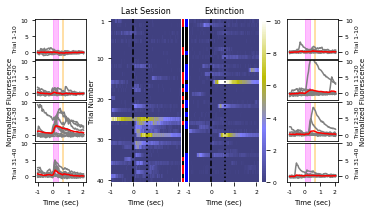

In [242]:
# Used ali 26 for CO cells 
singleCellFigureTrialPlot(aliTraceBlocks, aliBehaviorScoring, 'ali26_d5_s1', 'ali26_d5_s2',20,'', lblpad=3, ypeak=10.1, cmapChoice=topgist_cm)
#plt.savefig('SingleBothCellCorrectSort_293.png', format='png', dpi=1200, transparent=True)

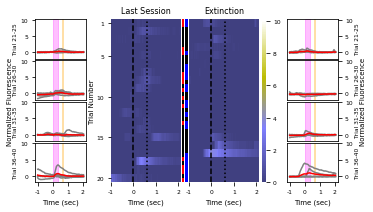

In [243]:
# Used ali 26 for not CO and not EX cells 
singleCellFigureTrialPlot_last20(aliTraceBlocks, aliBehaviorScoring, 'ali26_d5_s1', 'ali26_d5_s2',363,'', lblpad=3, ypeak=10.1, cmapChoice=topgist_cm)
#plt.savefig('SingleBothCellCorrectSort_none_363_changed_scale.png', format='png', dpi=1200, transparent=True)

In [244]:
ali24_Last_Inc_Cells, ali24_Ext_Inc_Cells

(array([  0,   1,   5,   7,   8,  19,  25,  27,  28,  39,  40,  41,  43,
         55,  56,  59,  60,  64,  65,  66,  73,  74,  81,  83,  84,  88,
        106, 108, 113, 122, 126, 131, 143, 145, 147, 150, 157, 158, 159,
        160, 161, 162, 163, 164, 165, 168, 171, 182, 188, 200, 201, 202,
        204, 210, 221, 225, 232, 241, 242, 245, 246, 259, 263, 264, 268,
        271, 275, 277, 290, 291, 299]),
 array([  6,  11,  12,  15,  16,  17,  18,  20,  21,  23,  24,  29,  34,
         44,  57,  65,  74,  81,  86,  95,  97, 104, 107, 108, 110, 118,
        120, 145, 152, 155, 162, 163, 166, 168, 170, 172, 173, 177, 178,
        184, 187, 190, 191, 193, 194, 204, 212, 233, 253, 258, 259, 262,
        284, 286, 289, 291, 297]))

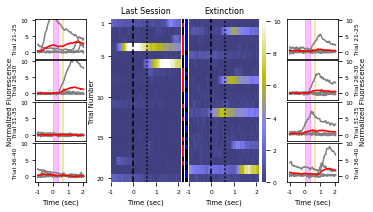

In [245]:
singleCellFigureTrialPlot_last20(aliTraceBlocks, aliBehaviorScoring, 'ali24_d5_s1', 'ali24_d5_s2',177,'', lblpad=3, ypeak=10.1, cmapChoice=topgist_cm)
#plt.savefig('Ali24_SingleBothCellCorrectSort_last20_258_changed_scale.png', format='png', dpi=1200, bbox_inches='tight',transparent=True)

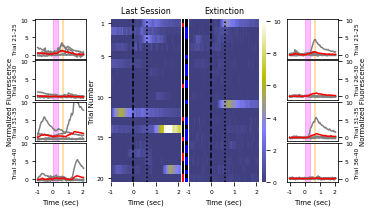

In [246]:
singleCellFigureTrialPlot_last20(aliTraceBlocks, aliBehaviorScoring, 'ali25_d5_s1', 'ali25_d5_s2',107,'', lblpad=3, ypeak=10.1, cmapChoice=topgist_cm)
#plt.savefig('Ali24_SingleBothCellCorrectSort_last20_258_changed_scale.png', format='png', dpi=1200, bbox_inches='tight',transparent=True)

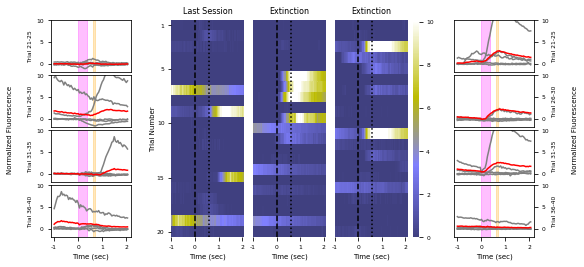

In [247]:
#Plotting for Figure Generation (Figure 4A - Single Extinction Cell Plot) Lost Cell in First Round of Figures.  New one with Sorting
#Potentially Interesting Cells: 8, 17, 20
singleCellFigureTrialPlot_last20_3(aliTraceBlocks, aliBehaviorScoring, 'ali26_d5_s1', 'ali26_d5_s2', 239, '', lblpad=3, ypeak=10.1, cmapChoice=topgist_cm)
plt.savefig('SingleBothCellCorrectSort_last20_239_3.png', format='png', dpi=1200,bbox_inches='tight', transparent=True)